In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
import bisect 
from numpy import sqrt, cosh, cos, sinh

from utils.root2df import Root2Df
import xgboost as xgb

import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Rectangle

In [2]:
res = Root2Df(data_dir=Path('../data/raw')).read_df()
res.keys()

[INFO] Reading skim configuration file: ..\data\raw\processing.cfg
[INFO] ..\data\raw\MinBiasPU140_MTD.root loaded!
[INFO] ..\data\raw\MinBiasPU200_MTD.root loaded!
[INFO] ..\data\raw\MinBiasPU250_MTD.root loaded!
[INFO] ..\data\raw\DsTau3muPU0_MTD.root loaded!
[INFO] ..\data\raw\DsTau3muPU200_MTD.root loaded!


dict_keys(['MinBiasPU140_MTD', 'MinBiasPU200_MTD', 'MinBiasPU250_MTD', 'DsTau3muPU0_MTD', 'DsTau3muPU200_MTD'])

In [3]:
neg200 = res['MinBiasPU200_MTD']
pos0 = res['DsTau3muPU0_MTD']
pos200 = res['DsTau3muPU200_MTD']
print(len(neg200), len(pos0), len(pos200))
pos0 = pos0[pos0.n_gen_tau == 1].reset_index(drop=True)
pos200 = pos200[pos200.n_gen_tau == 1].reset_index(drop=True)
print(len(neg200), len(pos0), len(pos200))

499600 600000 100000
499600 466320 77883


In [4]:
all_eta = [abs(eta) for each in pos200.apply(lambda x: x['mu_hit_sim_eta'][x['mu_hit_station']==1], axis=1) for eta in each]
all_eta += [abs(eta) for each in neg200.apply(lambda x: x['mu_hit_sim_eta'][x['mu_hit_station']==1], axis=1) for eta in each]


all_phi = [phi*(math.pi/180) for each in pos200.apply(lambda x: x['mu_hit_sim_phi'][x['mu_hit_station']==1], axis=1) for phi in each]
all_phi += [phi*(math.pi/180) for each in neg200.apply(lambda x: x['mu_hit_sim_phi'][x['mu_hit_station']==1], axis=1) for phi in each]

<AxesSubplot:ylabel='Count'>

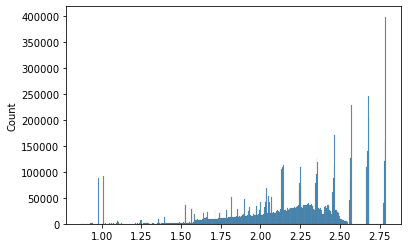

In [5]:
sns.histplot(all_eta)

<AxesSubplot:ylabel='Count'>

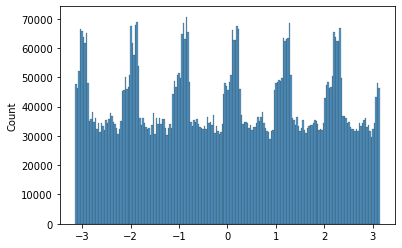

In [6]:
sns.histplot(all_phi)

In [57]:
def get_bins(data, num_bins):
    data = np.sort(data)
    
    bins = []
    for i in range(0, num_bins+1):
        bins.append(np.percentile(data, i * 100 / num_bins))
    return bins, num_bins/100*len(data)

def get_feature_names(eta_bins, phi_bins, num_bins):
    names = []
    figs = []
    for i in range(len(eta_bins) - 1):
        for j in range(len(phi_bins) - 1):
            names.append(f'{len(names)}\n{eta_bins[i]:.2f}<eta<{eta_bins[i+1]:.2f}\n{phi_bins[j]:.2f}<phi<{phi_bins[j+1]:.2f}\n')

            assert (i * num_bins['phi'] + j) == len(names) - 1
            fig = plt.figure(len(names) - 1)
            ax = plt.gca()
            ax.add_patch(Rectangle((eta_bins[i], phi_bins[j]), 
                                   eta_bins[i+1]-eta_bins[i], 
                                   phi_bins[j+1]-phi_bins[j]))
            ax.set_xlim(np.min(eta_bins), np.max(eta_bins))
            ax.set_ylim(np.min(phi_bins), np.max(phi_bins))
            ax.set_xlabel('eta')
            ax.set_ylabel('phi')
            ax.axvline(x=0, ls='--', color='r')
            figs.append(fig)
    return names, figs

def get_prodcut_dim(hit_eta, hit_phi, eta_bins, phi_bins, num_bins):
    
    x = np.zeros(num_bins['eta'] * num_bins['phi'])
    
    hit_phi *= math.pi/180
    
    if len(hit_eta) == 0:
        return x
    
    eta_dim = []
    for eta in hit_eta:
        for i in range(len(eta_bins) - 1):
            if eta_bins[i] <= eta <= eta_bins[i+1]:
                eta_dim.append(i)
                break

    phi_dim = []
    for phi in hit_phi:
        for j in range(len(phi_bins) - 1):
            if phi_bins[j] <= phi <= phi_bins[j+1]:
                phi_dim.append(j)     
                break


    product_dim = []
    for i in range(len(eta_dim)):
        product_dim.append(eta_dim[i] * num_bins['phi'] + phi_dim[i])

    for each in product_dim:
        x[each] += 1
    return x

def get_x_from_one_endcap(df: pd.DataFrame, eta_bins, phi_bins, num_bins):
    x = []
    y = []
    for entry in tqdm(df.itertuples(index=False), total=len(df)):
        idx = (entry.mu_hit_station == 1) * (entry.mu_hit_neighbor == 0)
        pos_endcap_idx = idx * (entry.mu_hit_endcap == 1)
        neg_endcap_idx = idx * (entry.mu_hit_endcap == -1)
        
        pos_hit_eta = entry.mu_hit_sim_eta[pos_endcap_idx]
        pos_hit_phi = entry.mu_hit_sim_phi[pos_endcap_idx]
        pos_endcap_x = get_prodcut_dim(abs(pos_hit_eta), pos_hit_phi, eta_bins, phi_bins, num_bins)
        
        neg_hit_eta = entry.mu_hit_sim_eta[neg_endcap_idx]
        neg_hit_phi = entry.mu_hit_sim_phi[neg_endcap_idx]
        neg_endcap_x = get_prodcut_dim(abs(neg_hit_eta), neg_hit_phi, eta_bins, phi_bins, num_bins)
        
        if entry.y == 1:
            tau_eta = entry.gen_tau_eta
            if ((tau_eta * pos_hit_eta) > 0).sum() == pos_endcap_idx.sum():
                pos_endcap_y = 1
                neg_endcap_y = 0
            else:
                assert ((tau_eta * neg_hit_eta) > 0).sum() == neg_endcap_idx.sum()
                pos_endcap_y = 0
                neg_endcap_y = 1
        else:
            pos_endcap_y = 0
            neg_endcap_y = 0
            
#         x.extend([pos_endcap_x, neg_endcap_x])
#         y.extend([pos_endcap_y, neg_endcap_y])
        x.extend([pos_endcap_x])
        y.extend([pos_endcap_y])
    return np.stack(x), np.stack(y)



In [58]:
times = 3
assert len(neg200) > len(pos200) * times

neg_idx = np.arange(len(neg200))
np.random.shuffle(neg_idx)

neg_num = len(pos200) * times
neg_idx = neg_idx[:neg_num]

print('pos2neg:', 1/times)

pos2neg: 0.3333333333333333


<ipython-input-57-6f0be162c5b5>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(len(names) - 1)


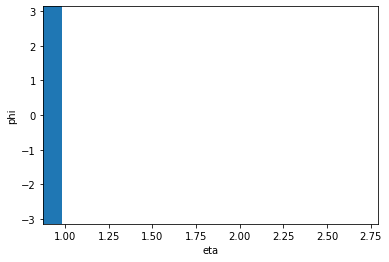

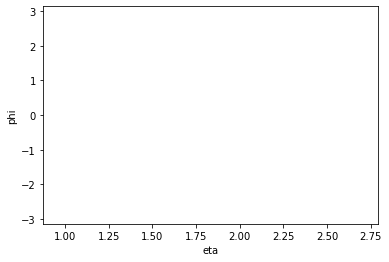

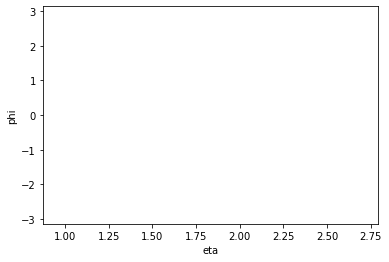

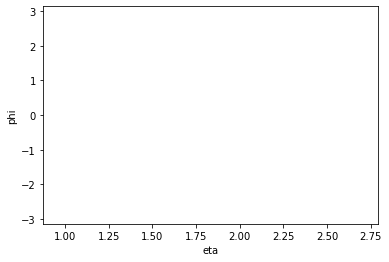

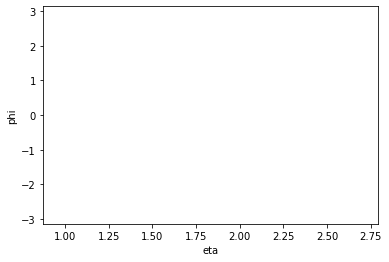

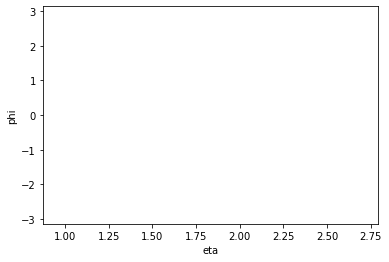

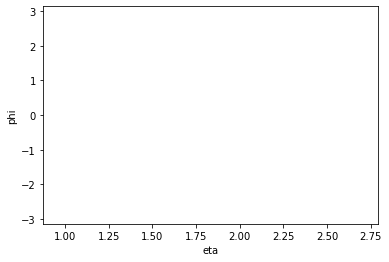

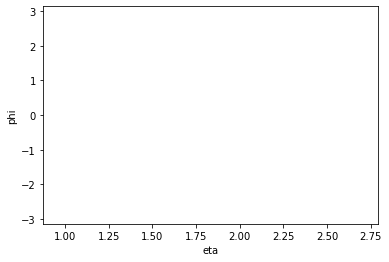

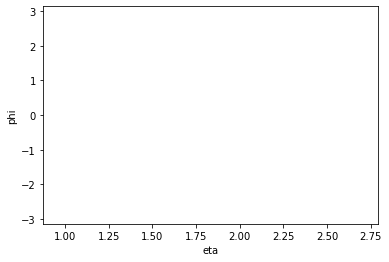

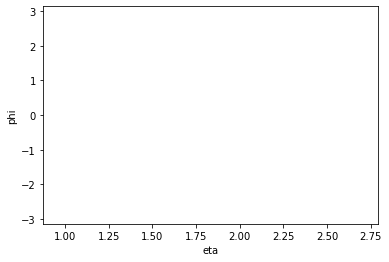

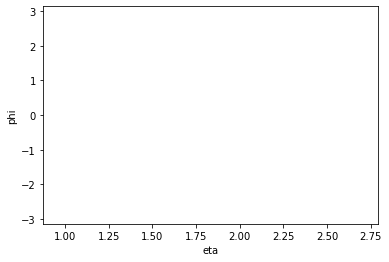

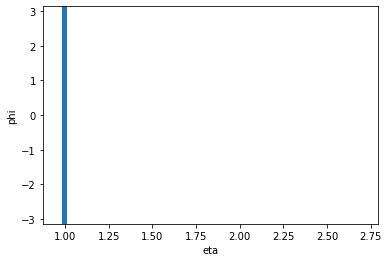

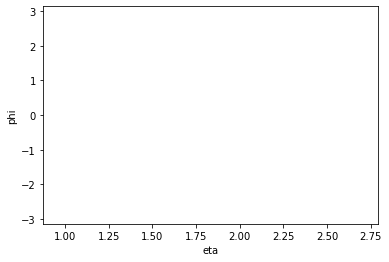

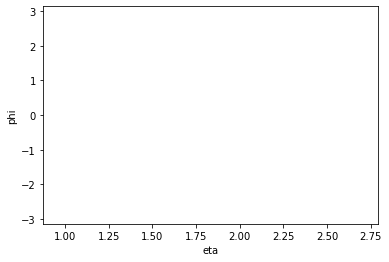

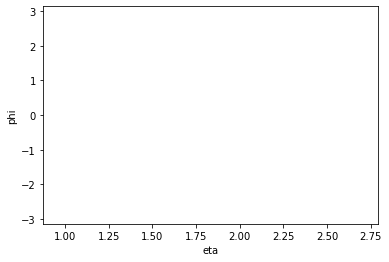

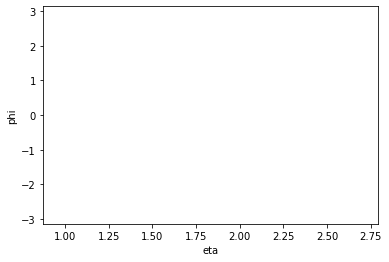

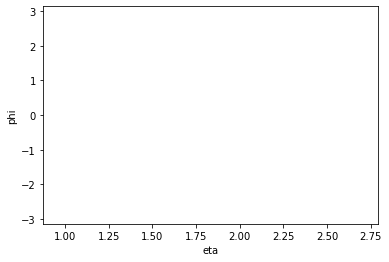

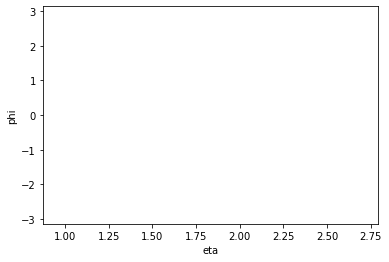

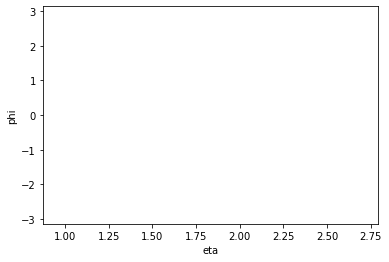

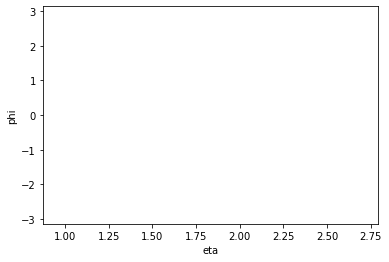

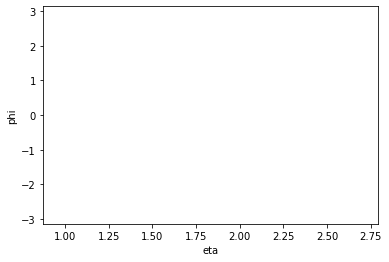

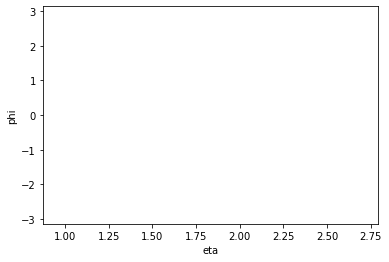

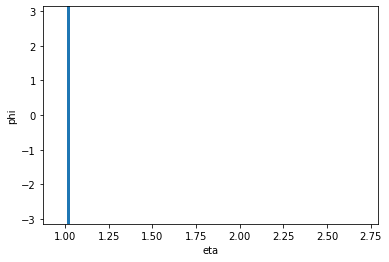

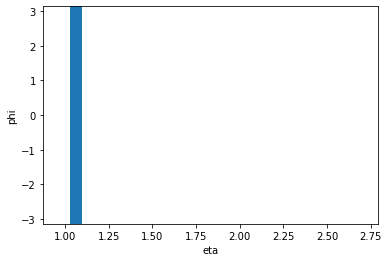

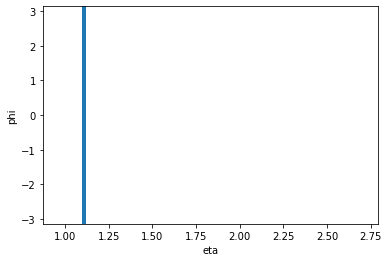

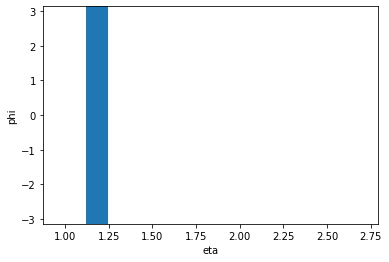

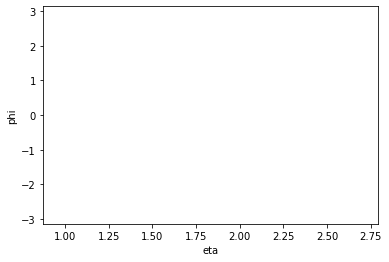

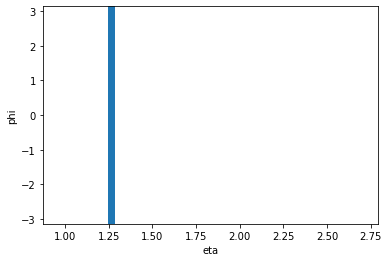

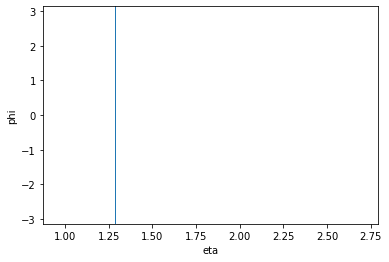

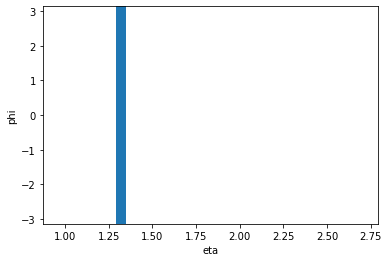

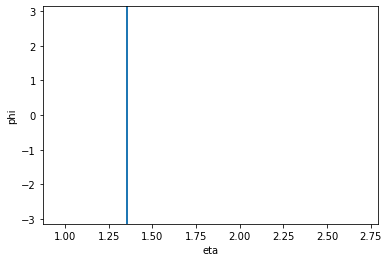

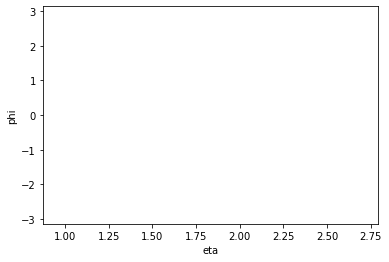

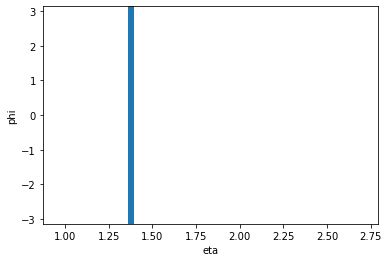

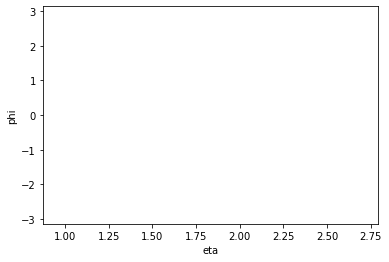

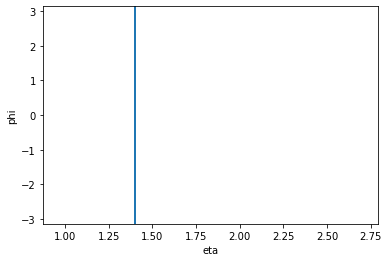

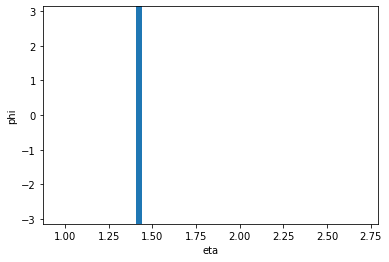

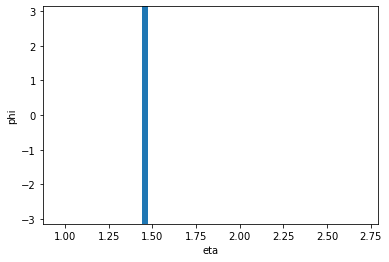

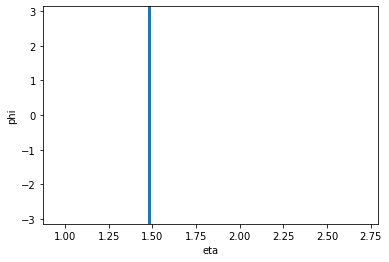

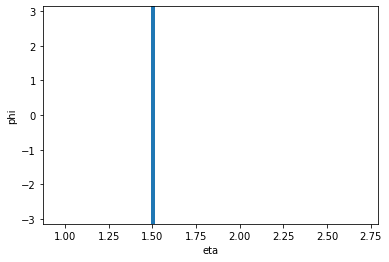

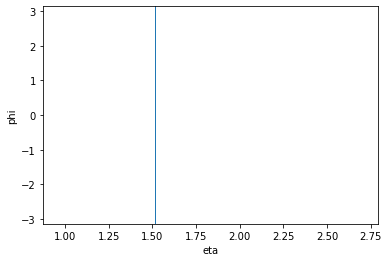

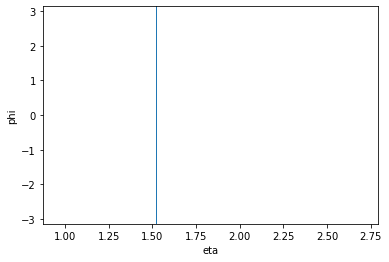

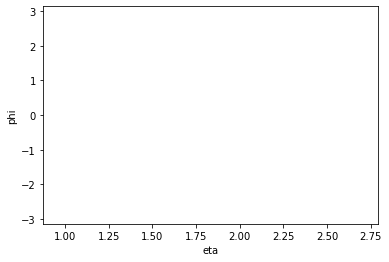

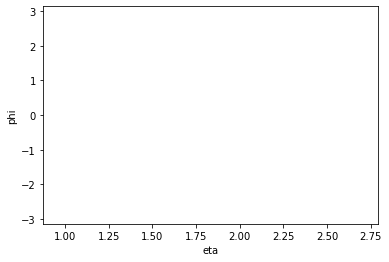

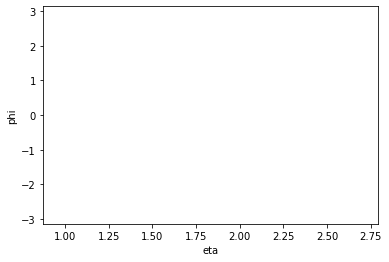

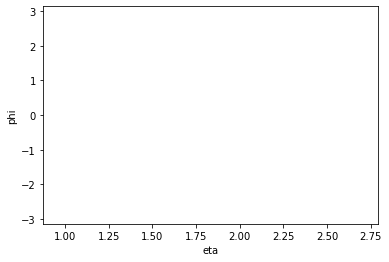

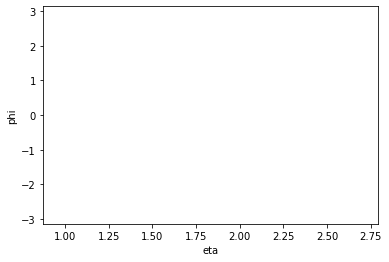

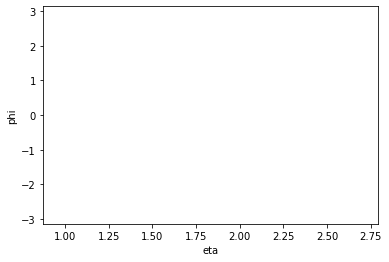

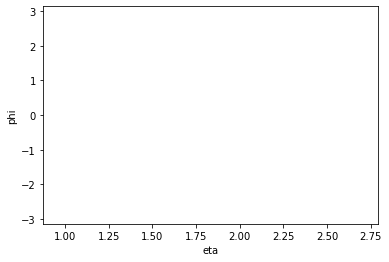

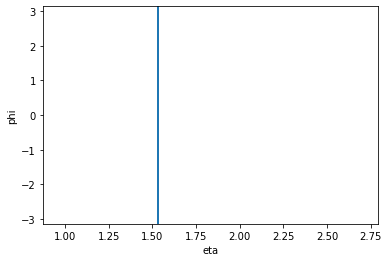

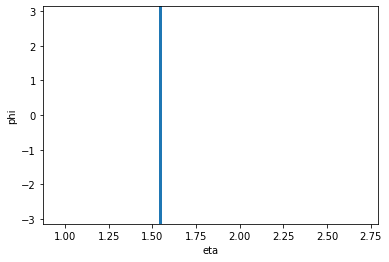

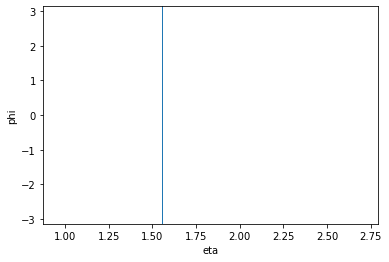

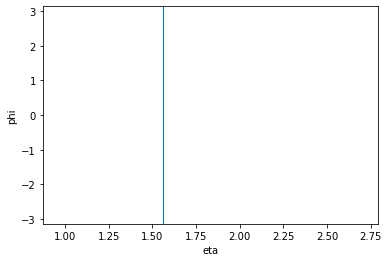

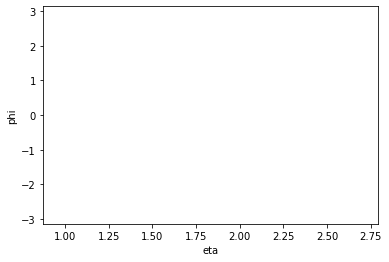

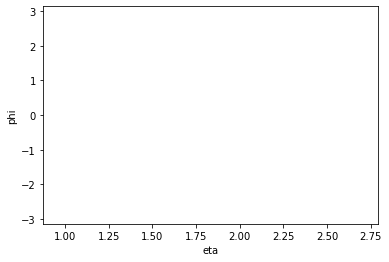

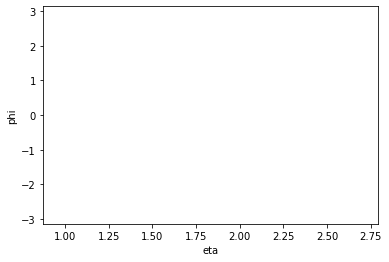

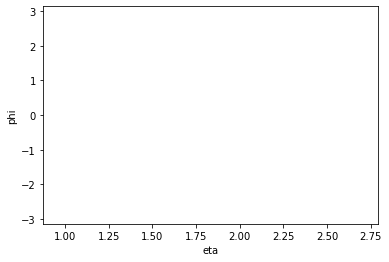

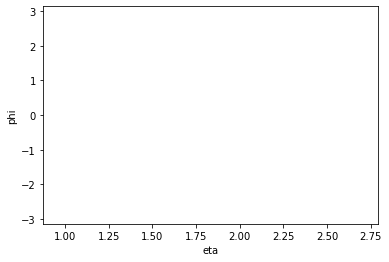

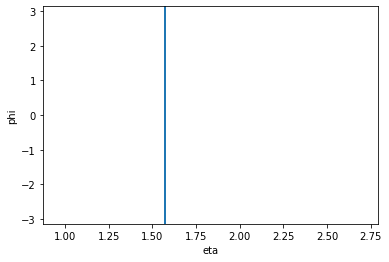

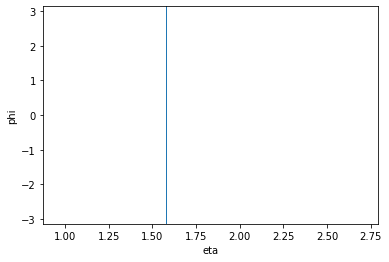

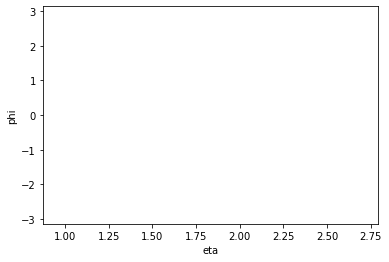

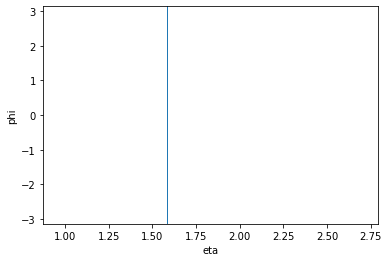

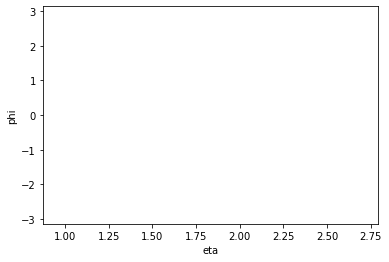

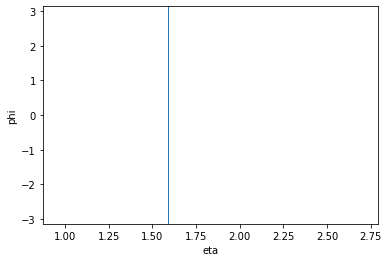

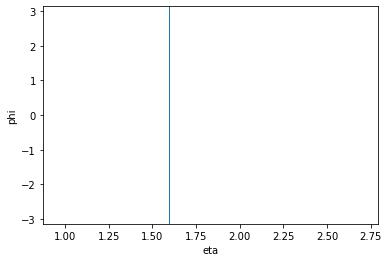

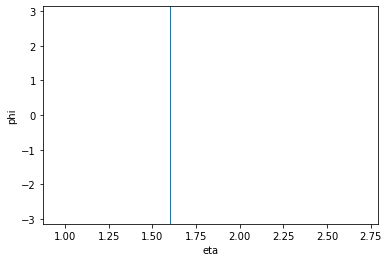

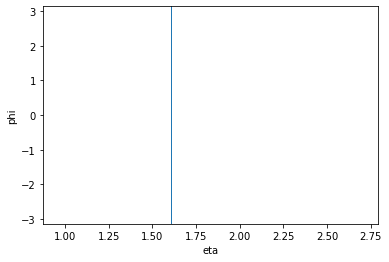

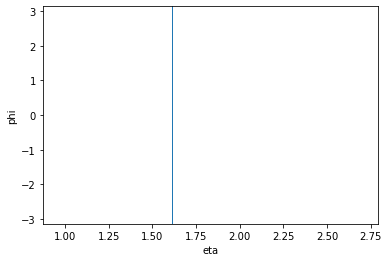

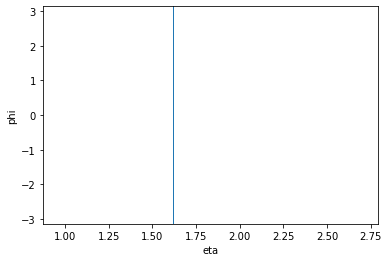

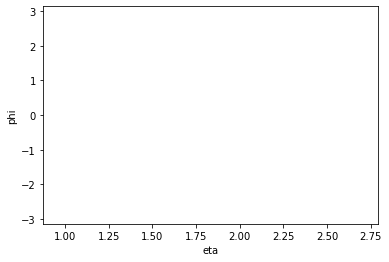

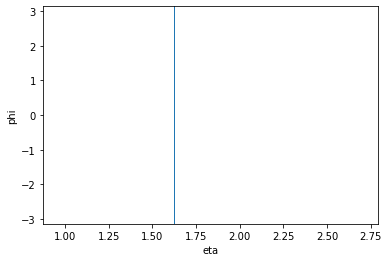

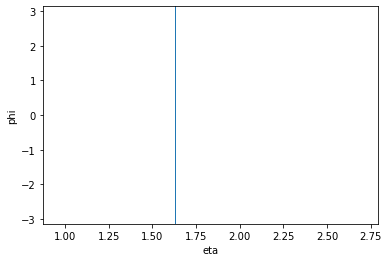

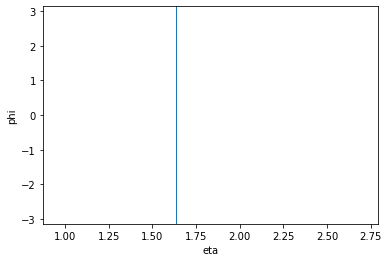

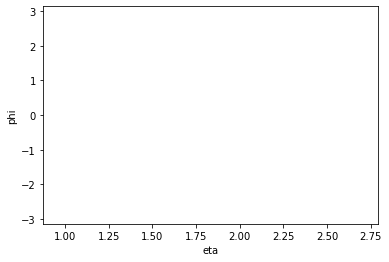

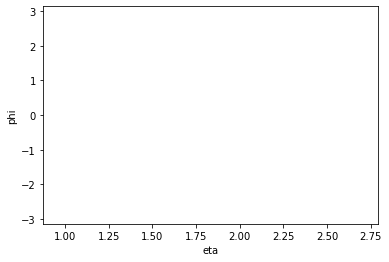

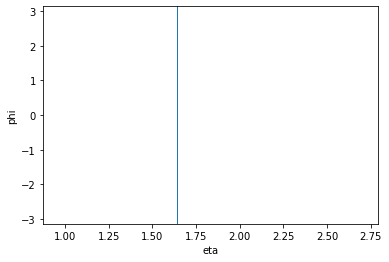

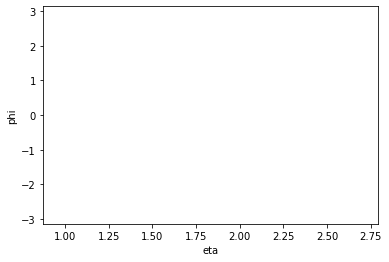

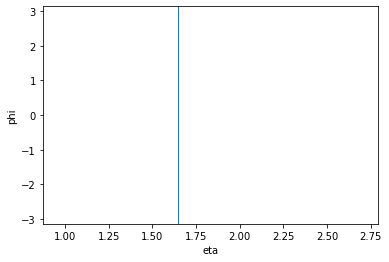

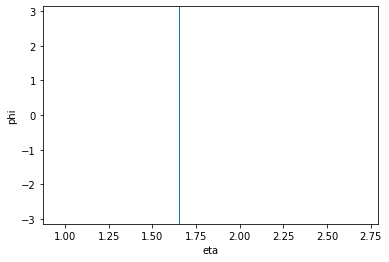

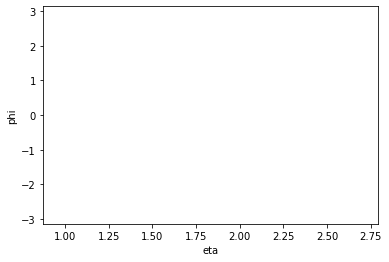

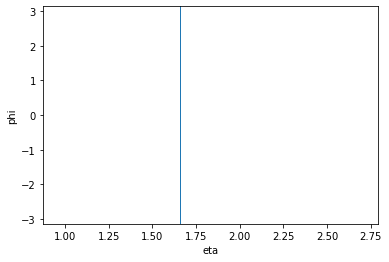

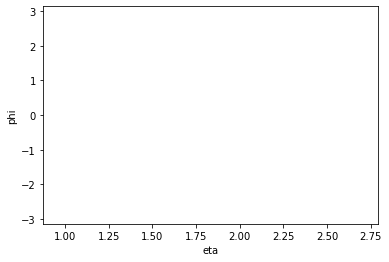

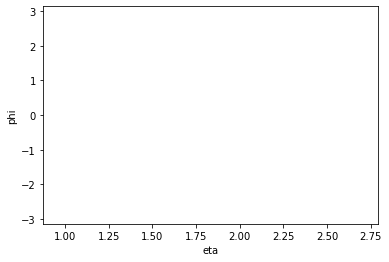

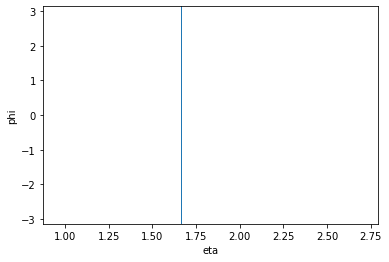

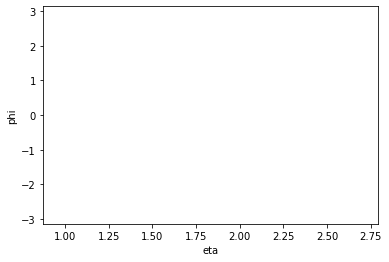

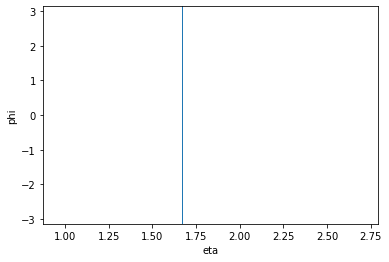

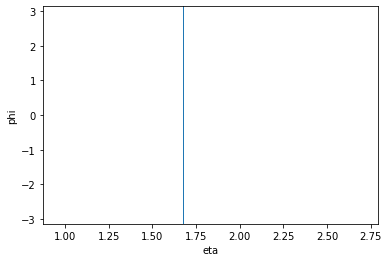

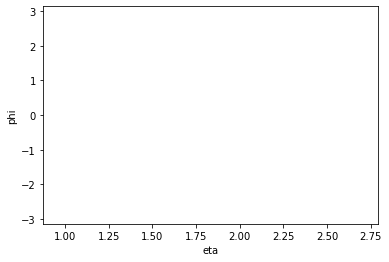

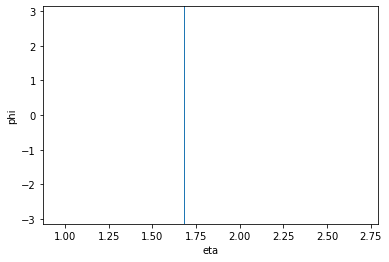

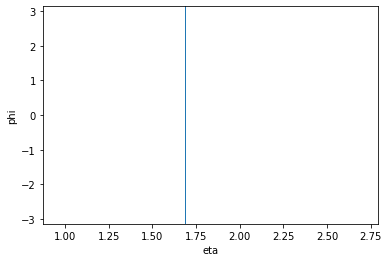

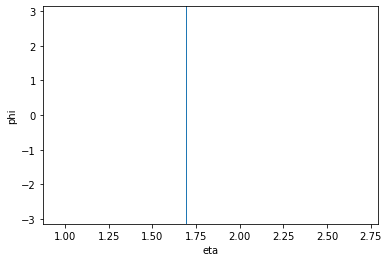

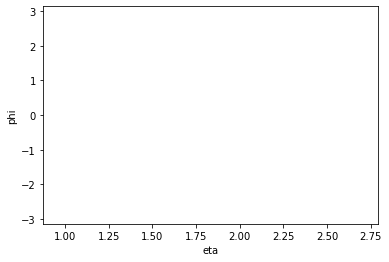

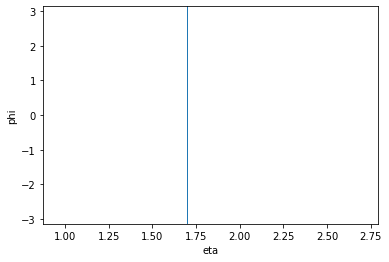

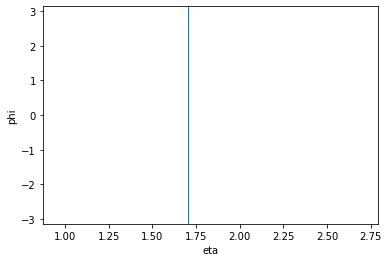

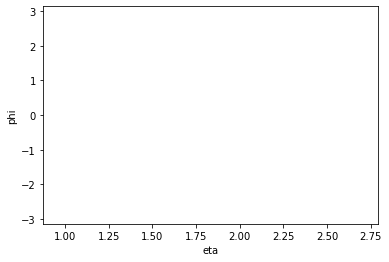

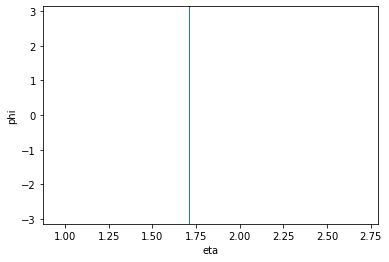

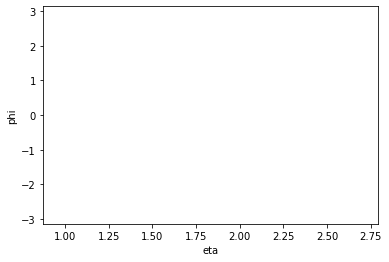

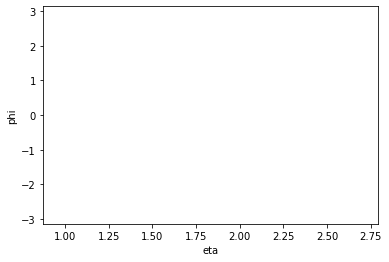

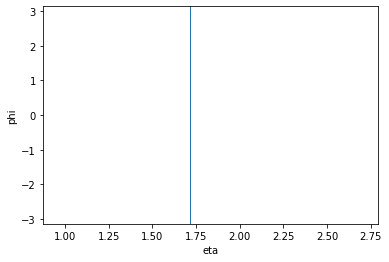

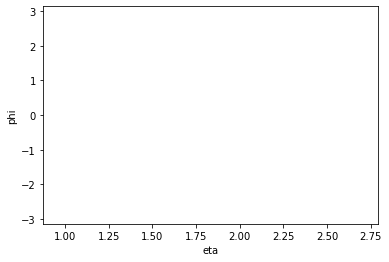

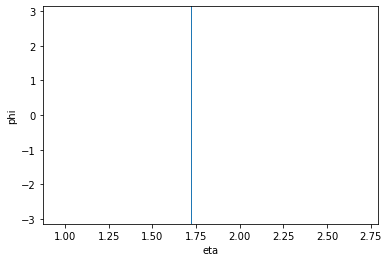

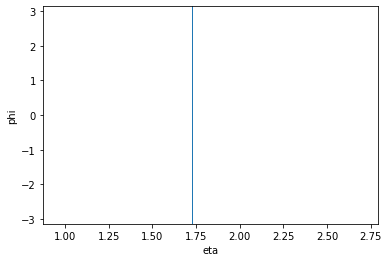

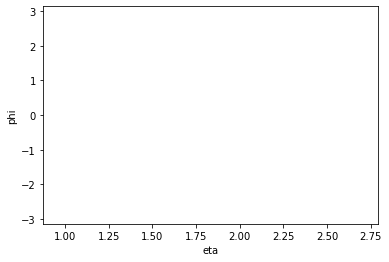

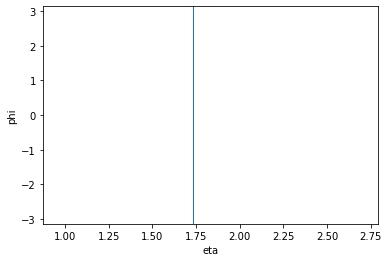

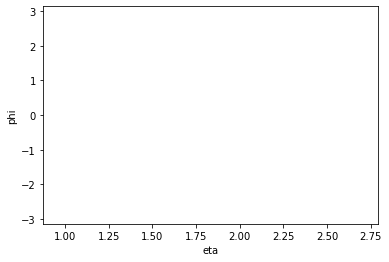

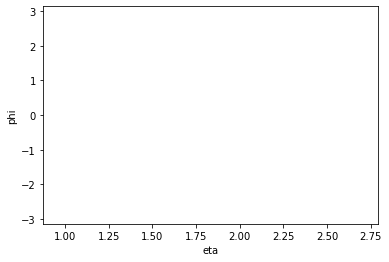

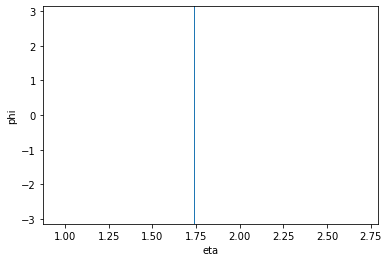

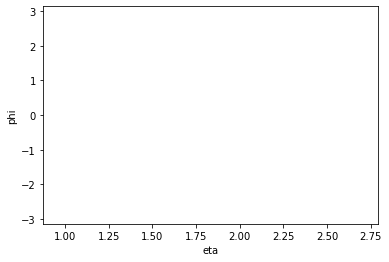

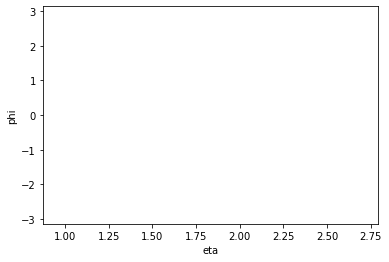

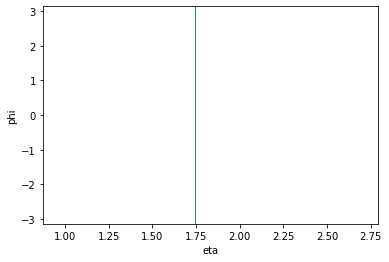

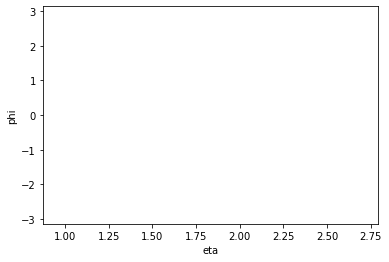

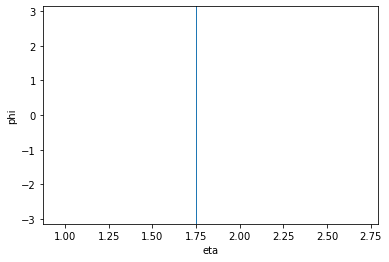

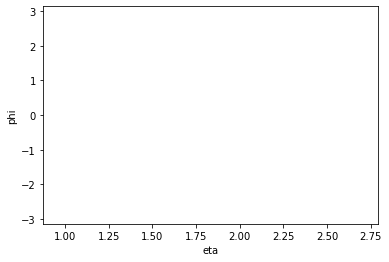

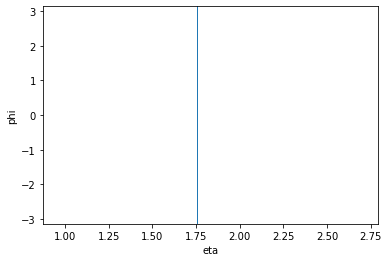

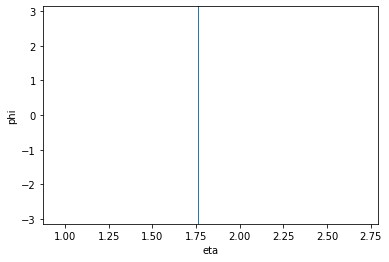

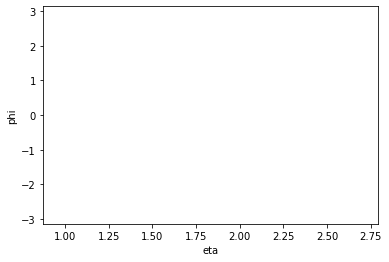

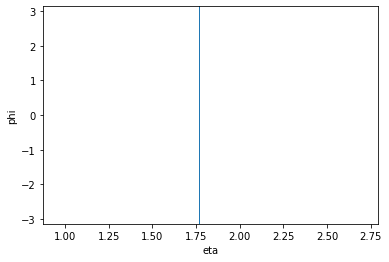

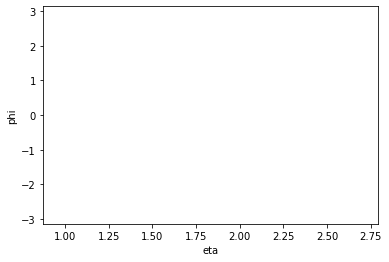

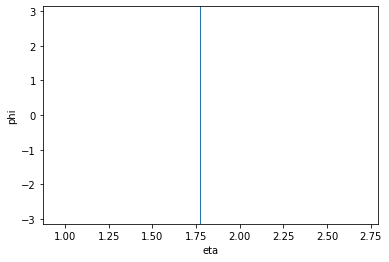

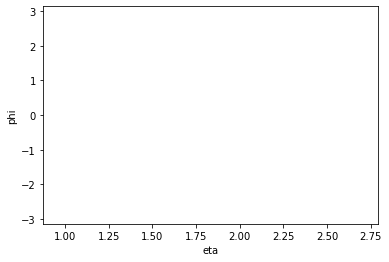

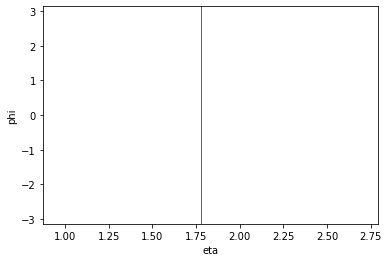

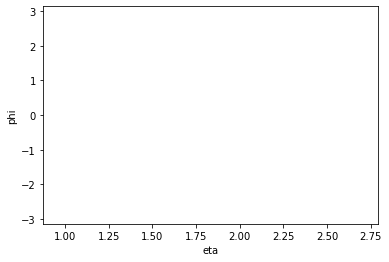

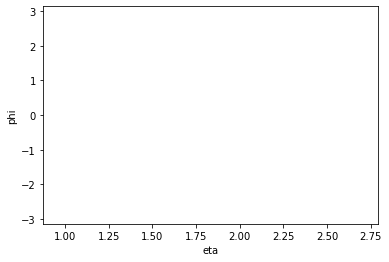

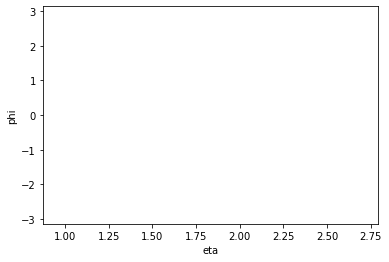

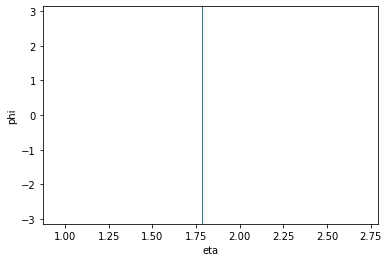

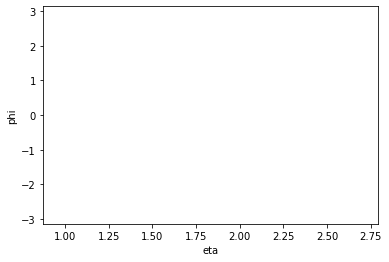

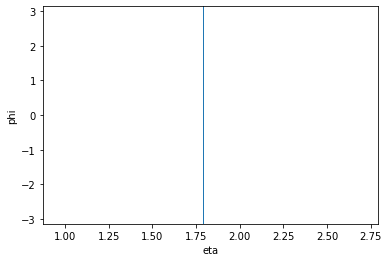

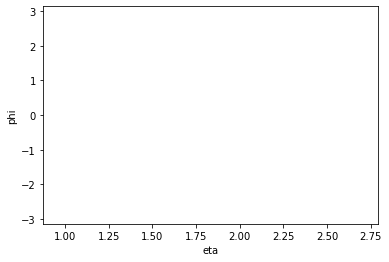

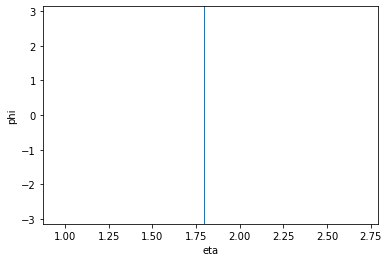

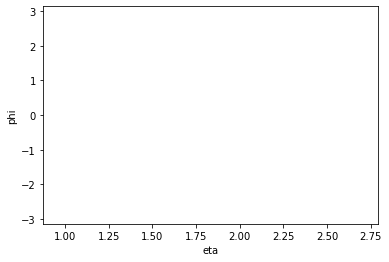

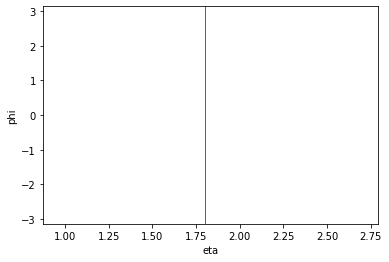

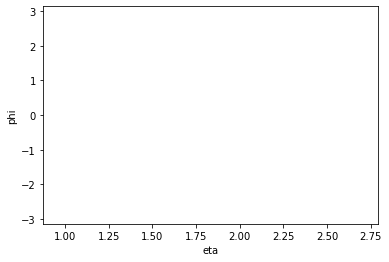

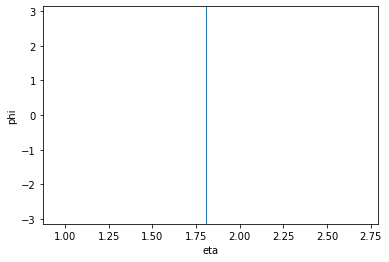

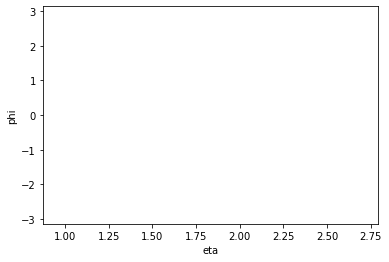

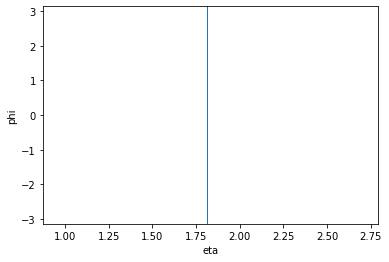

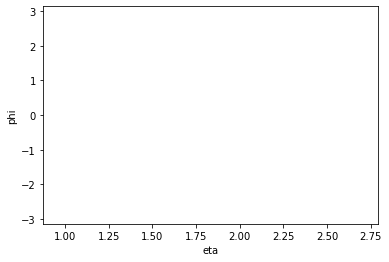

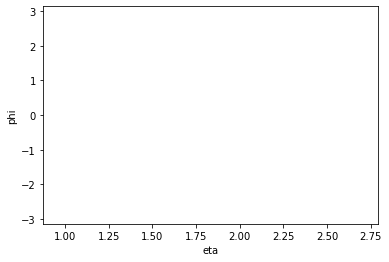

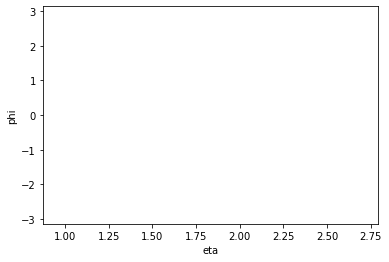

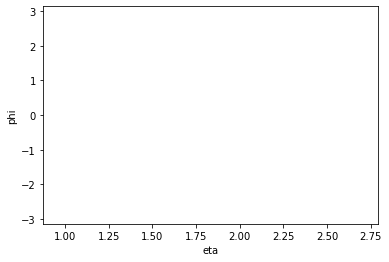

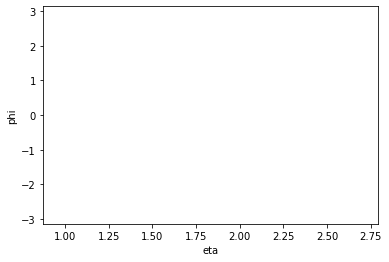

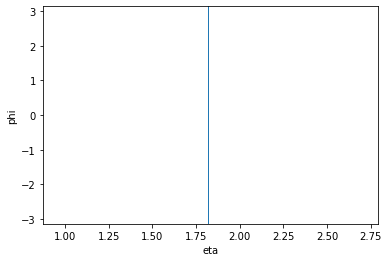

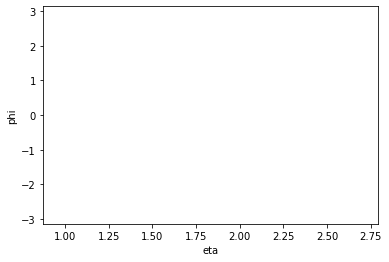

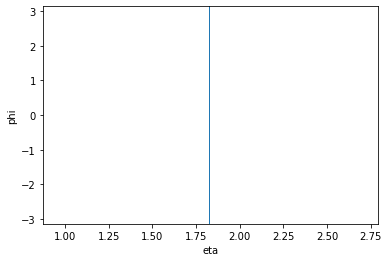

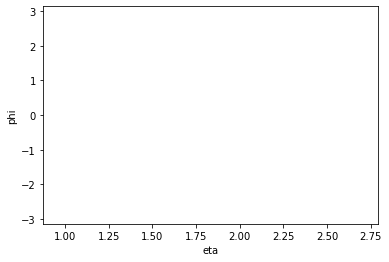

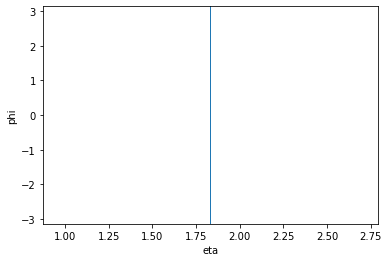

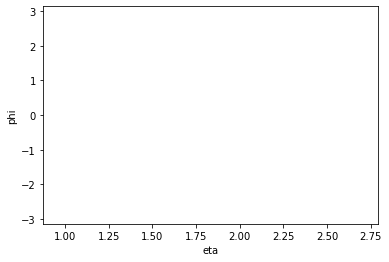

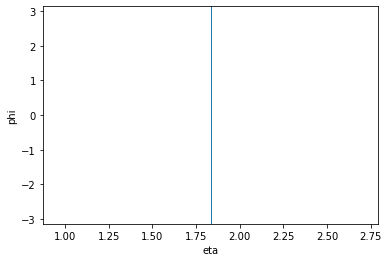

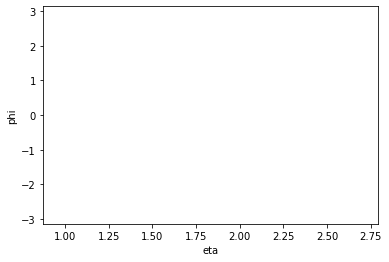

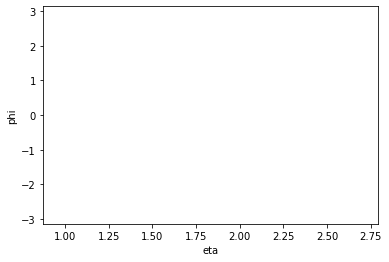

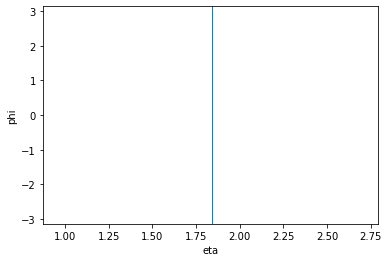

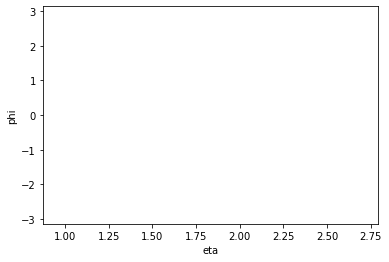

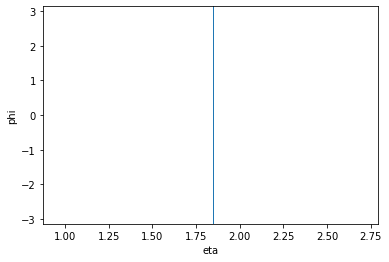

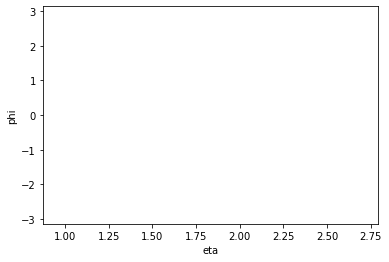

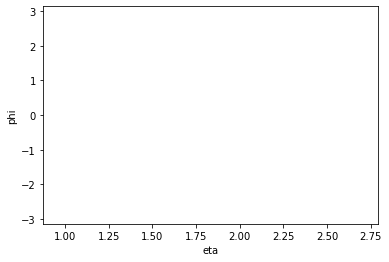

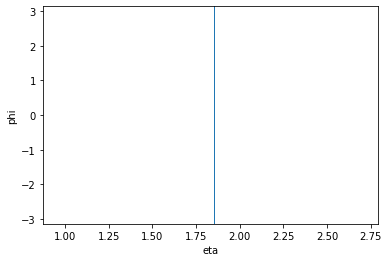

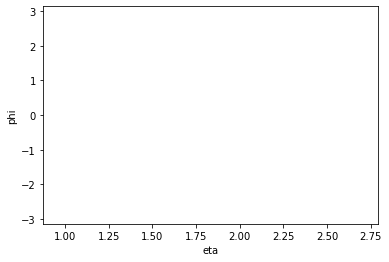

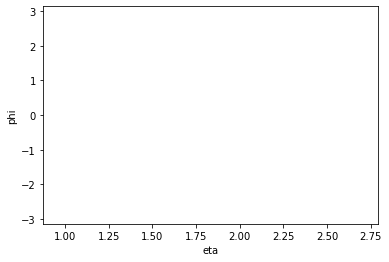

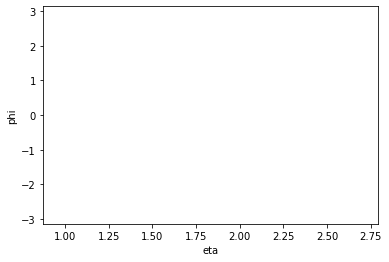

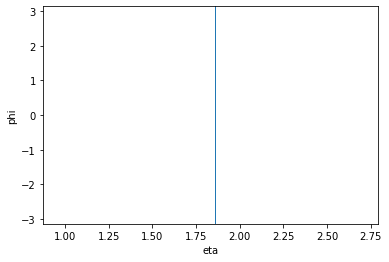

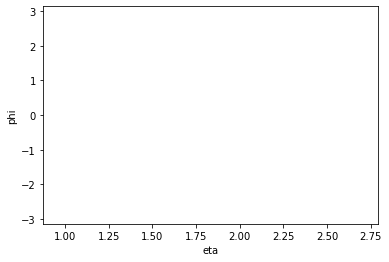

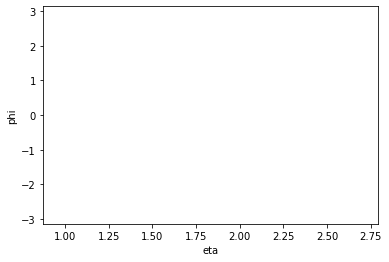

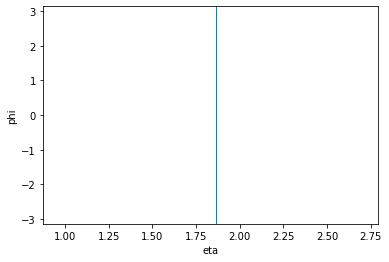

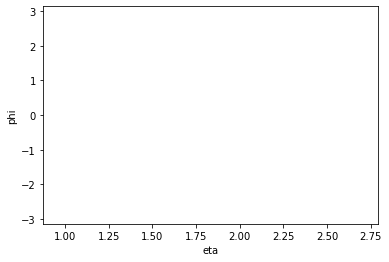

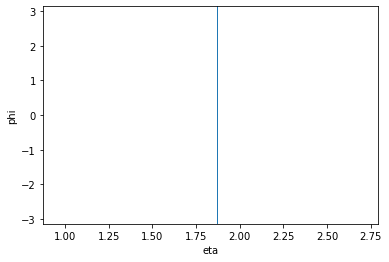

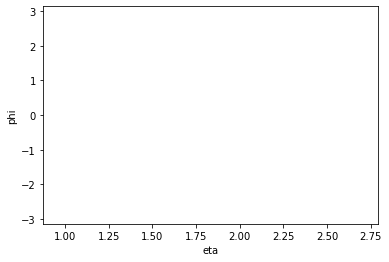

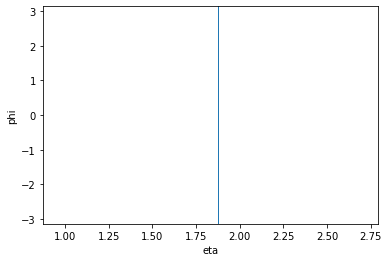

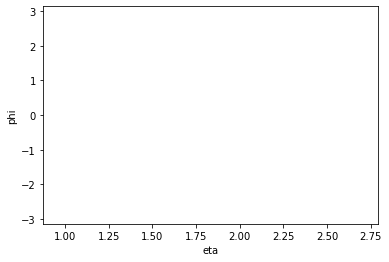

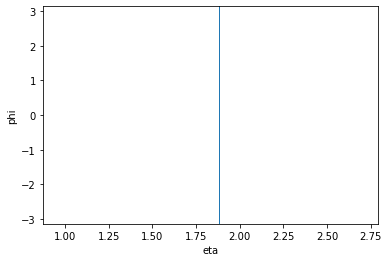

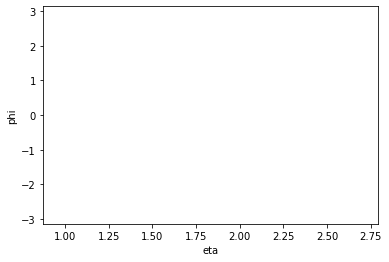

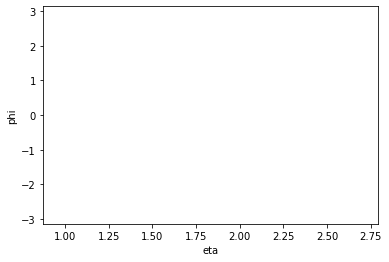

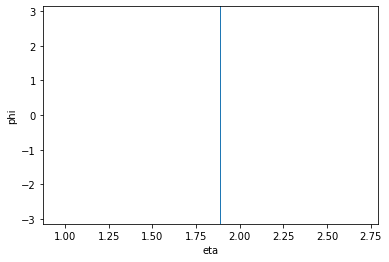

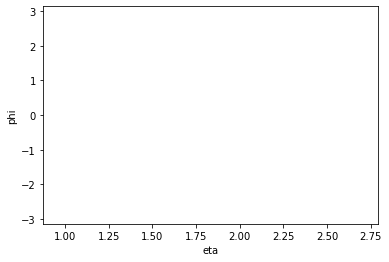

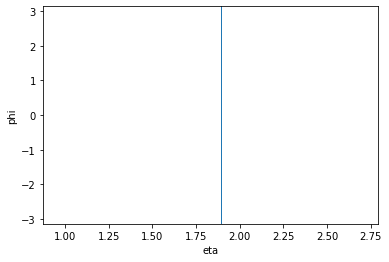

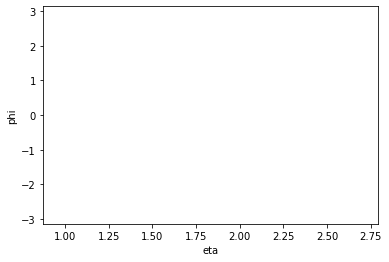

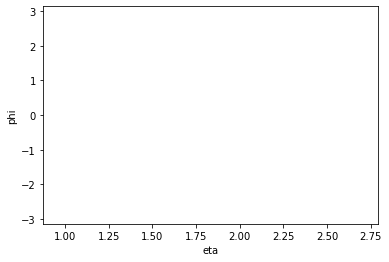

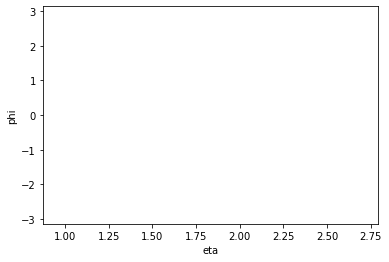

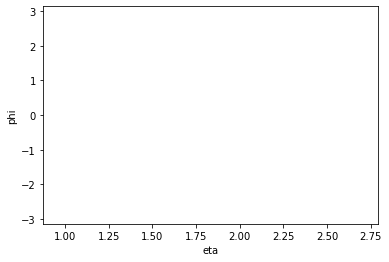

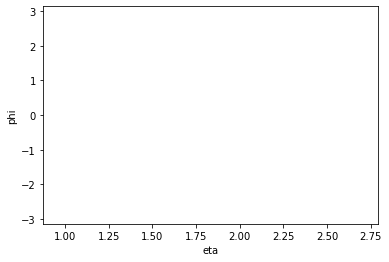

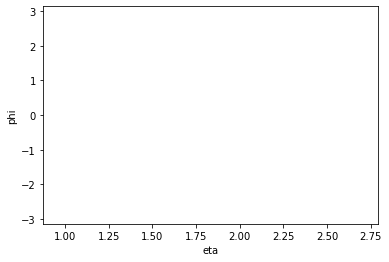

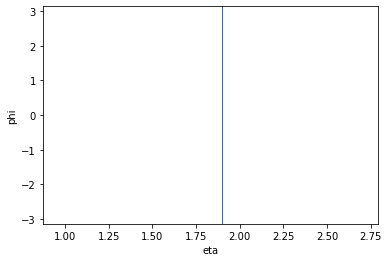

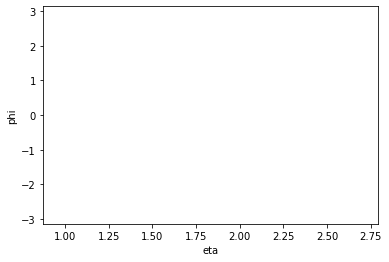

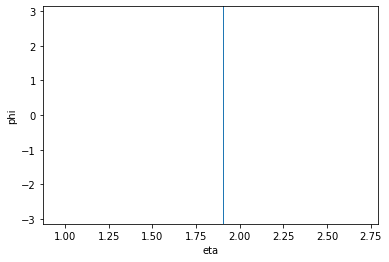

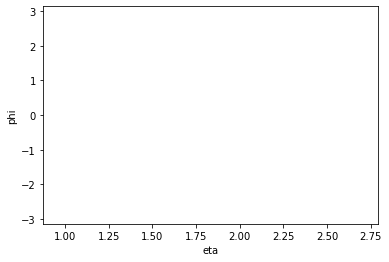

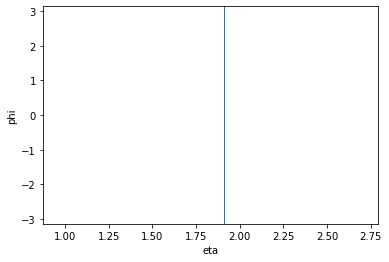

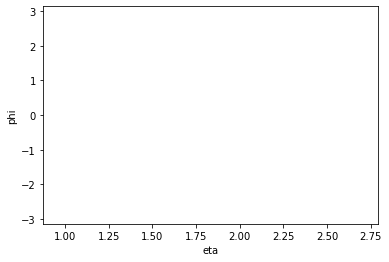

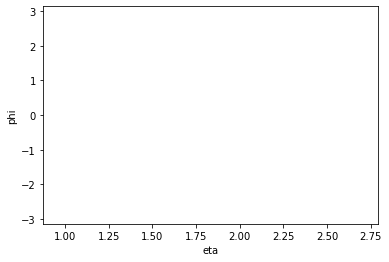

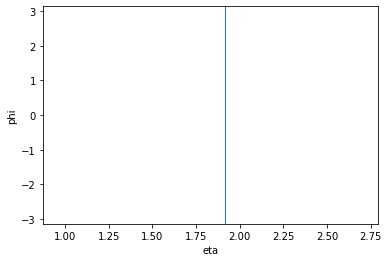

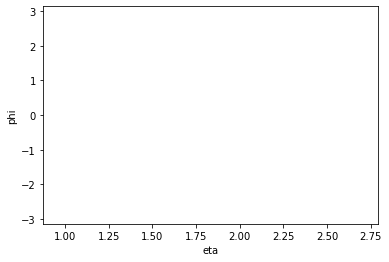

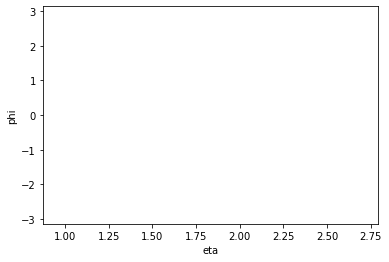

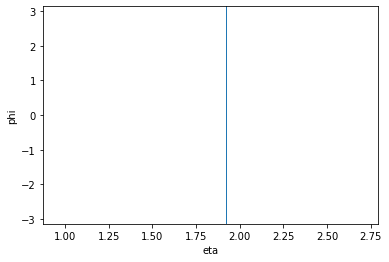

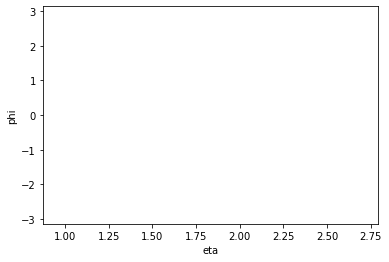

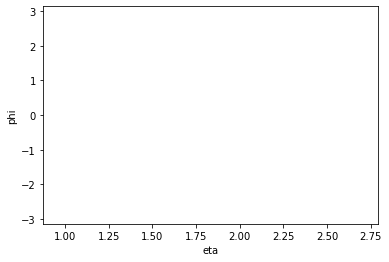

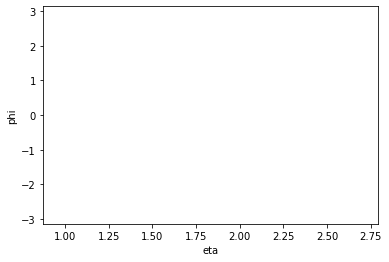

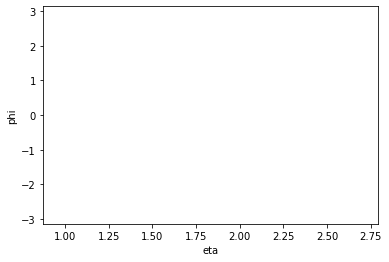

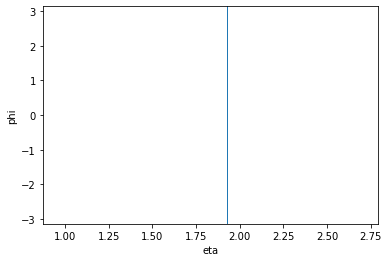

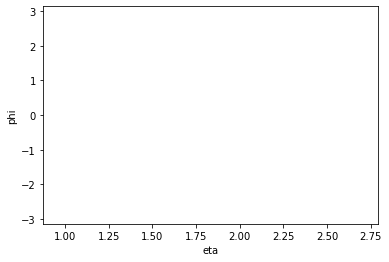

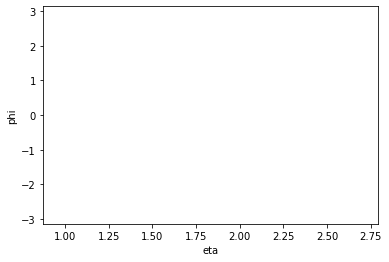

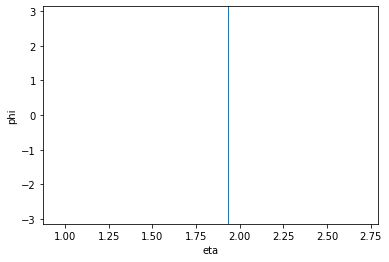

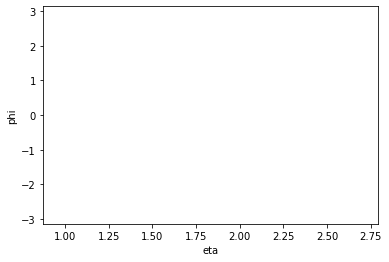

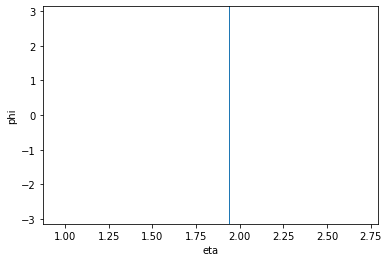

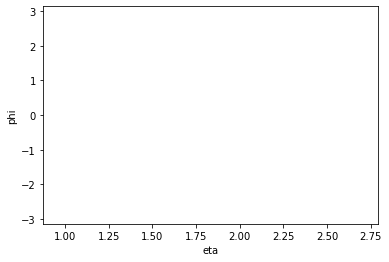

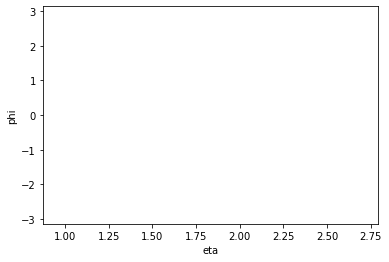

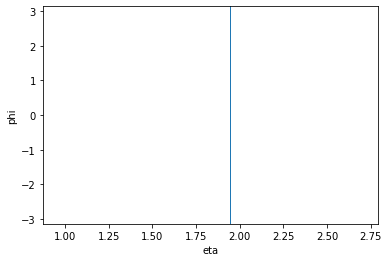

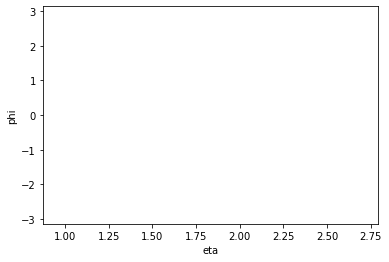

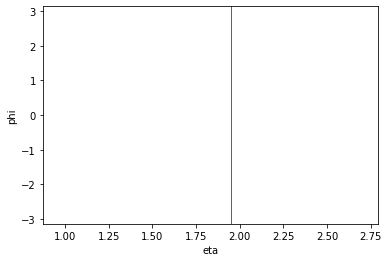

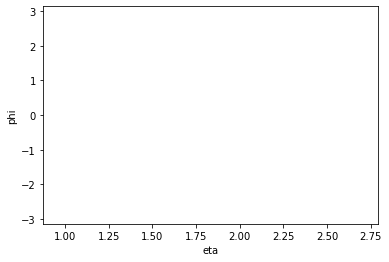

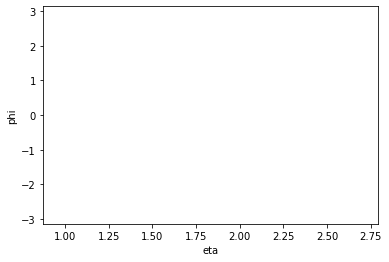

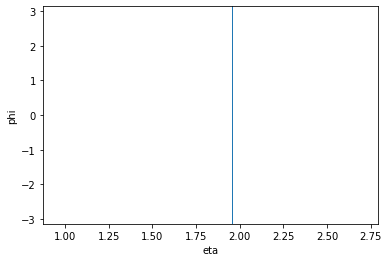

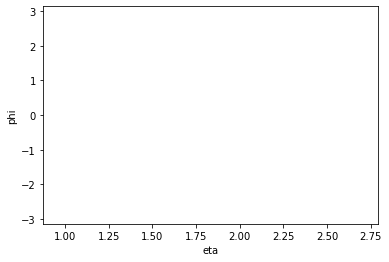

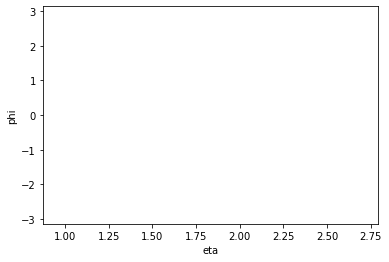

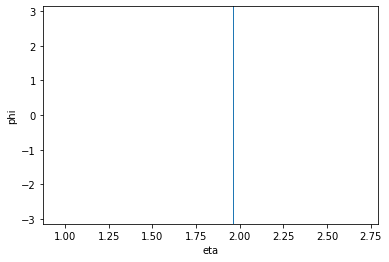

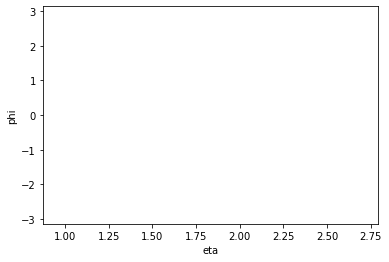

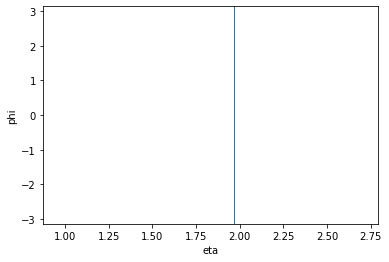

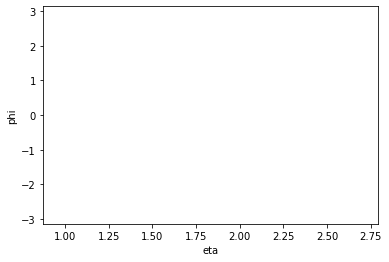

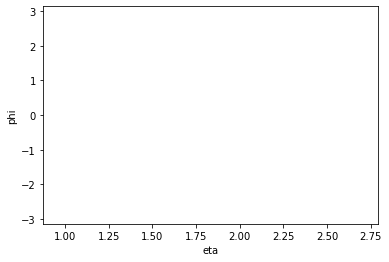

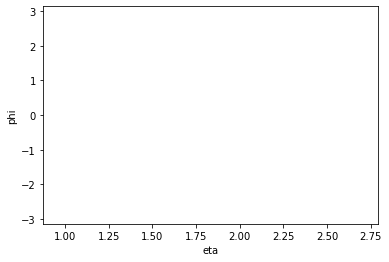

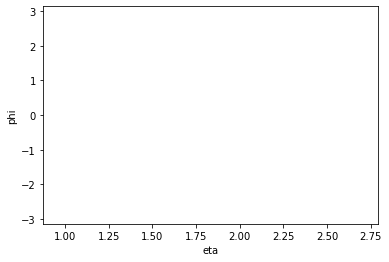

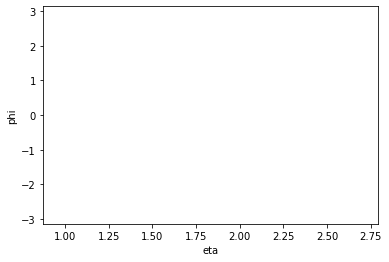

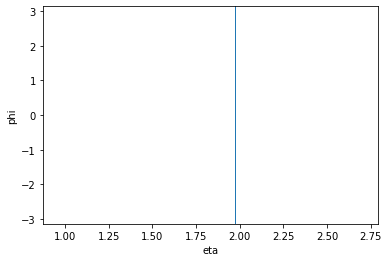

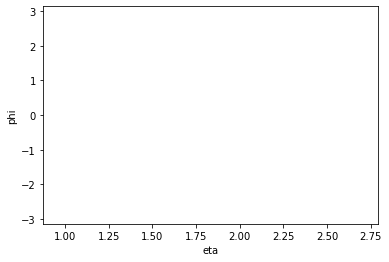

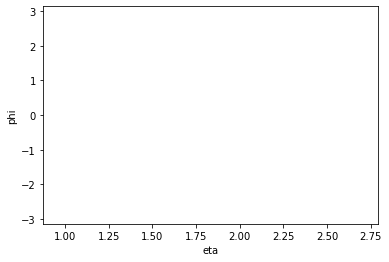

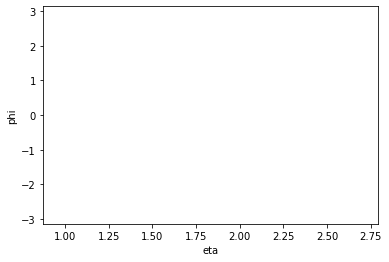

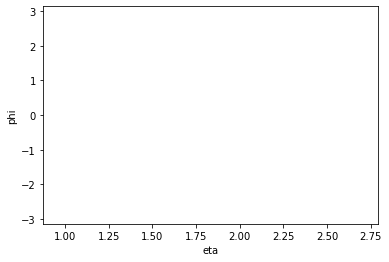

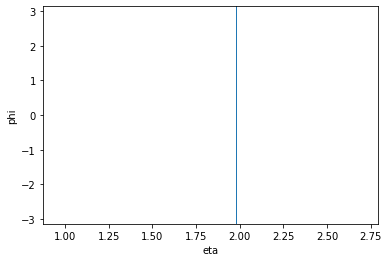

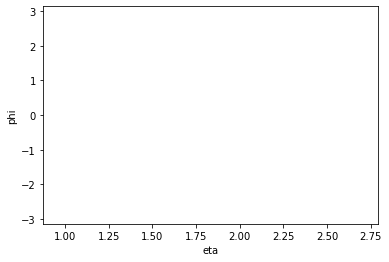

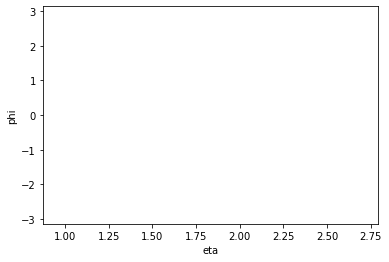

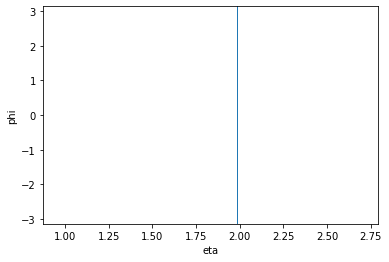

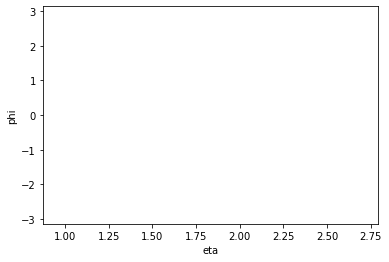

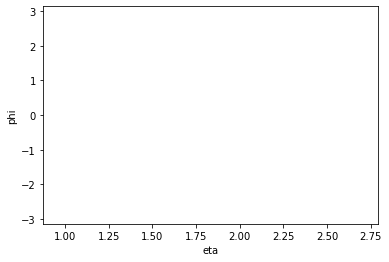

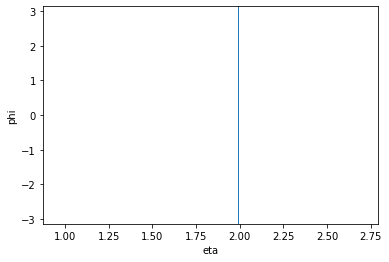

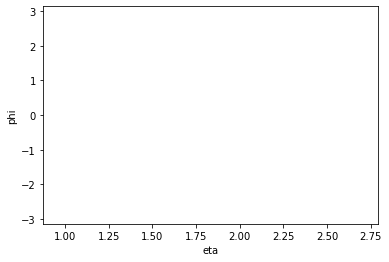

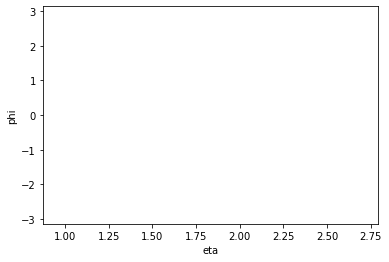

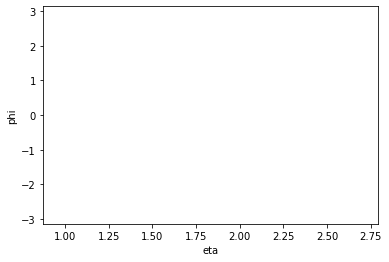

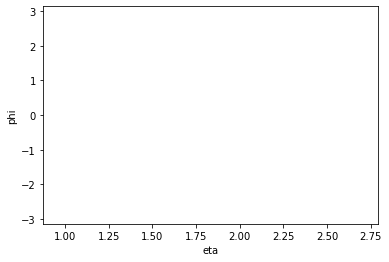

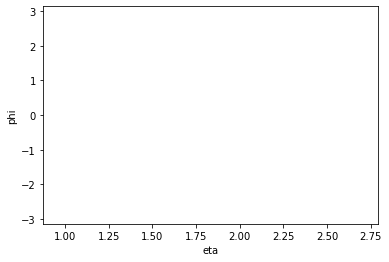

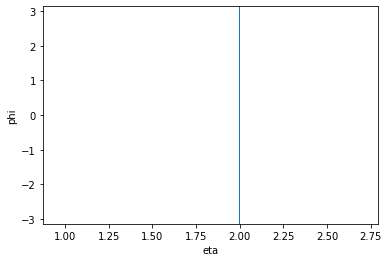

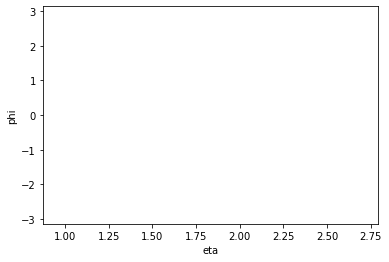

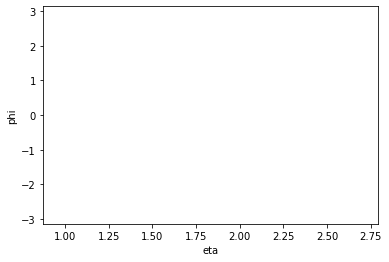

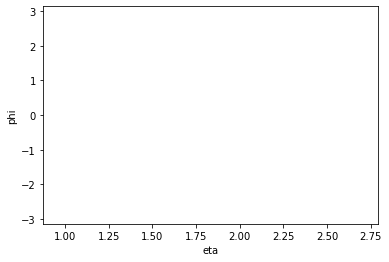

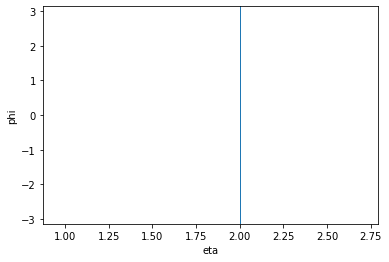

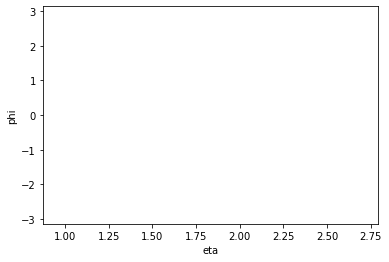

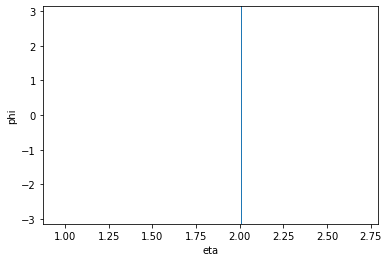

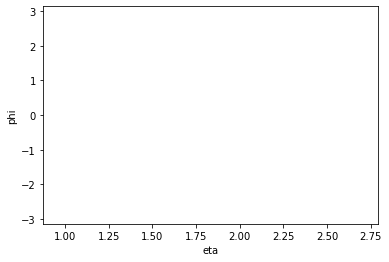

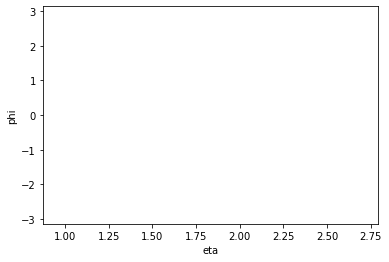

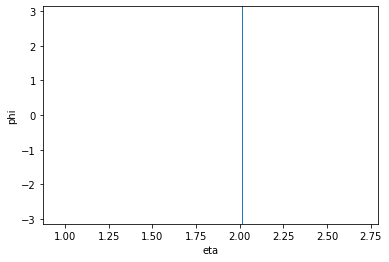

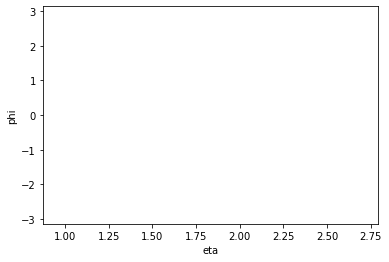

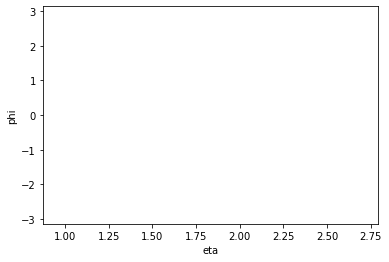

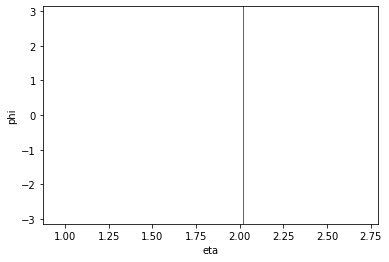

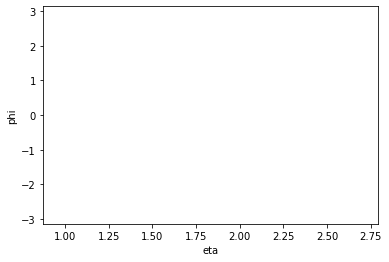

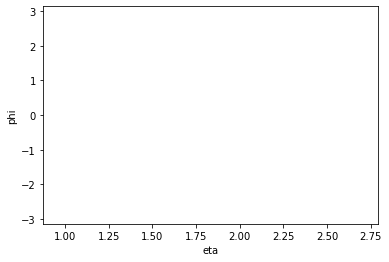

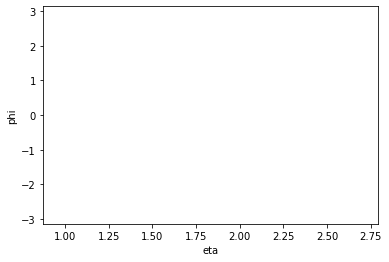

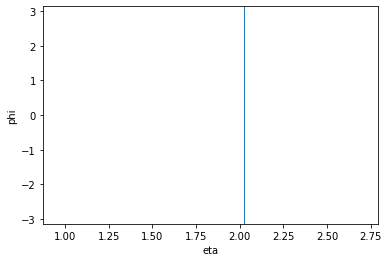

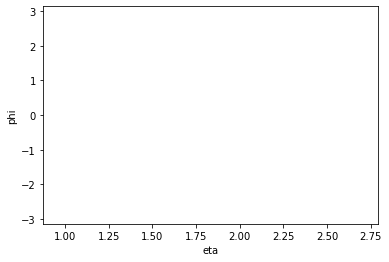

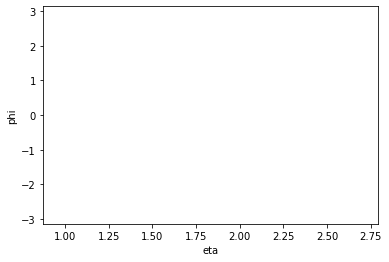

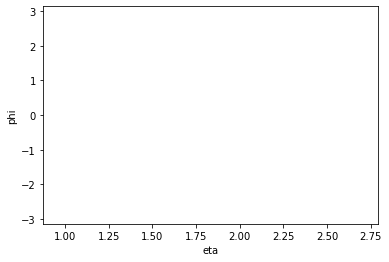

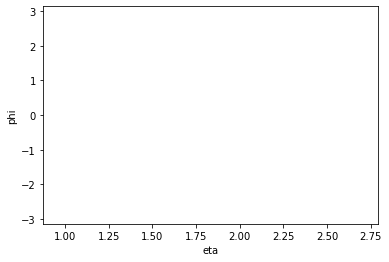

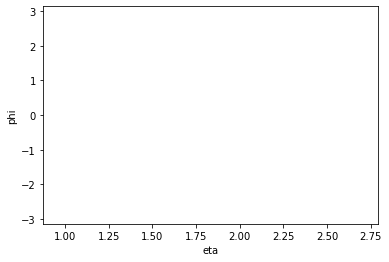

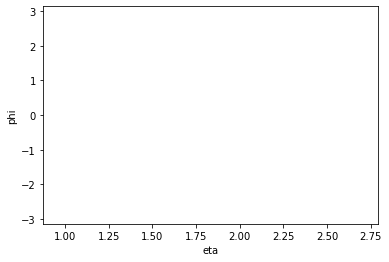

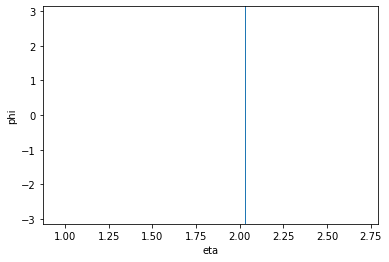

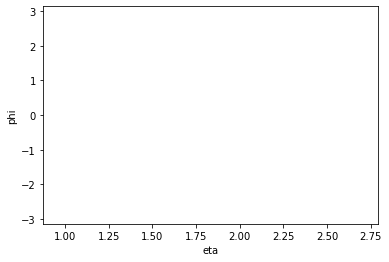

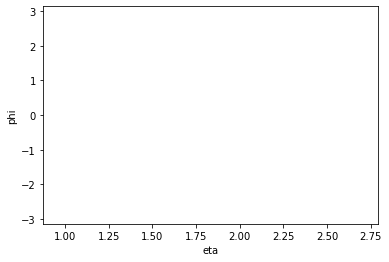

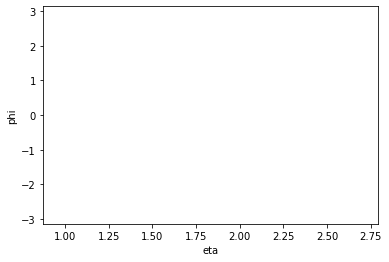

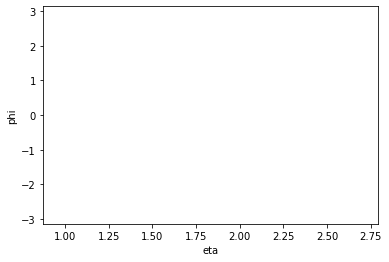

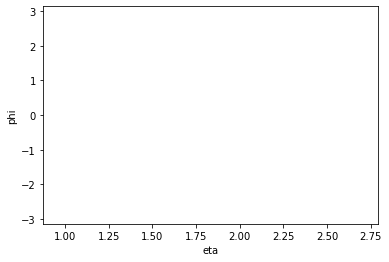

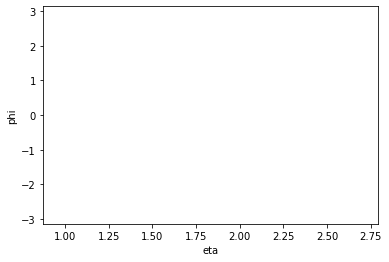

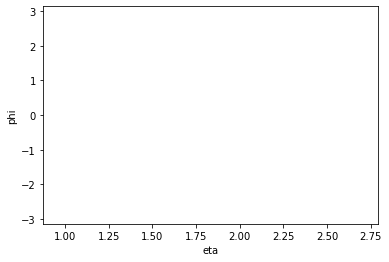

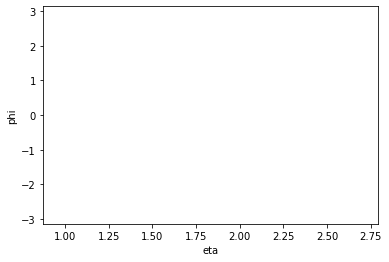

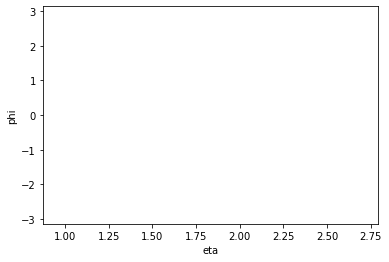

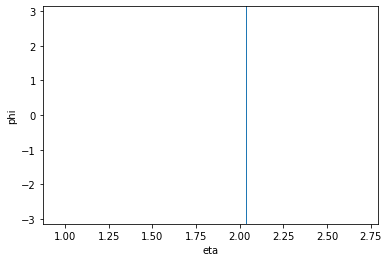

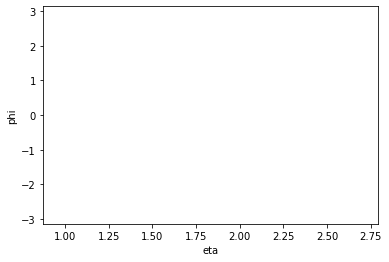

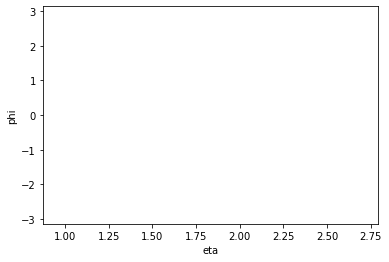

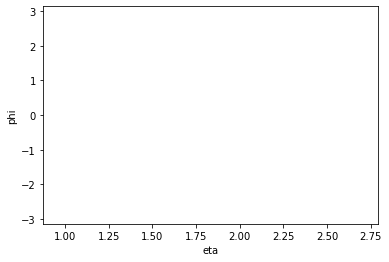

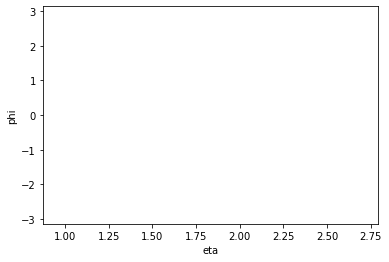

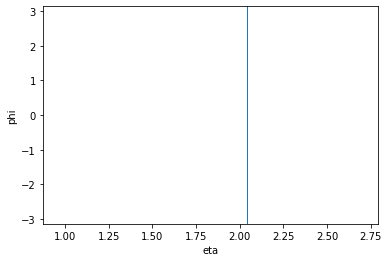

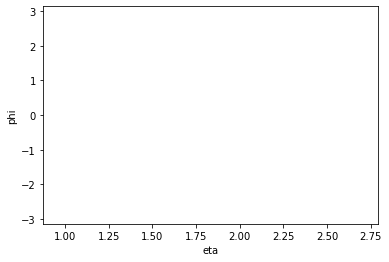

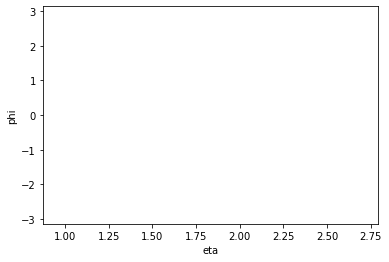

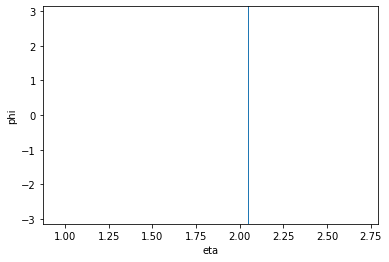

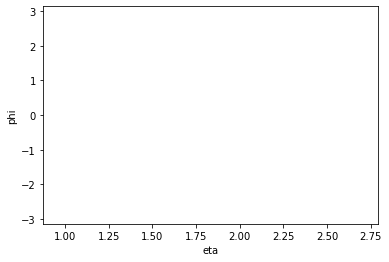

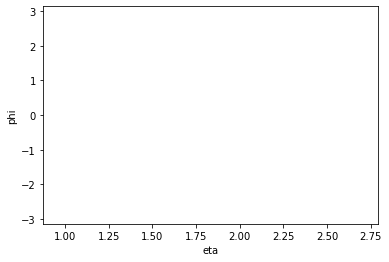

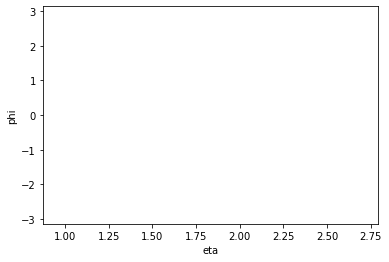

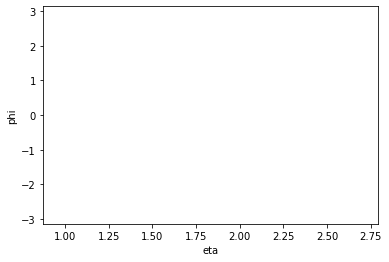

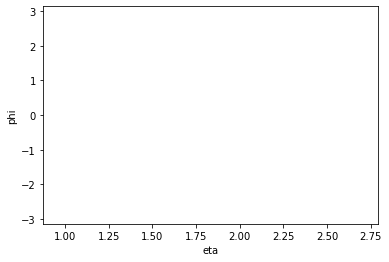

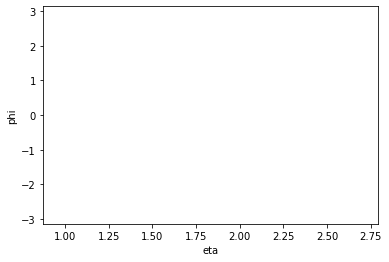

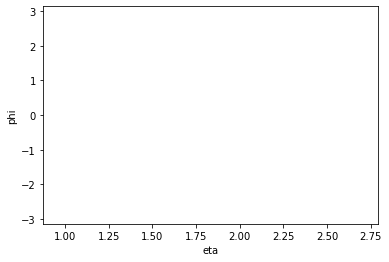

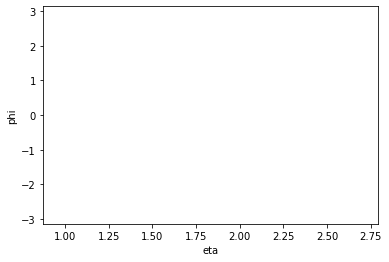

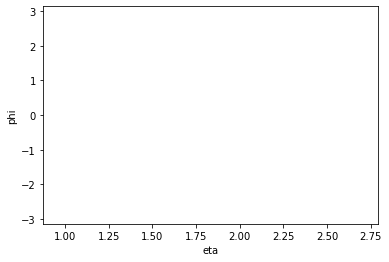

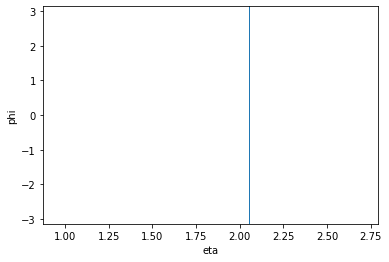

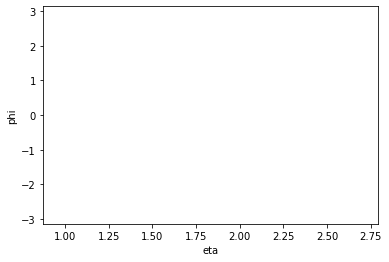

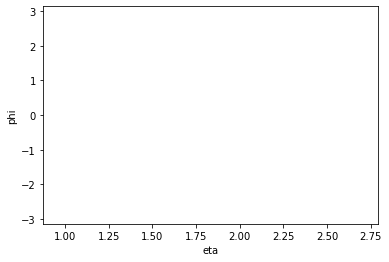

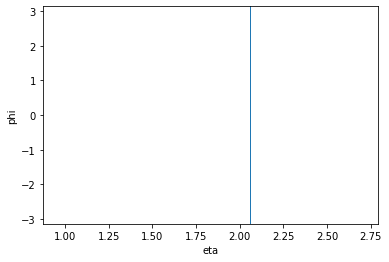

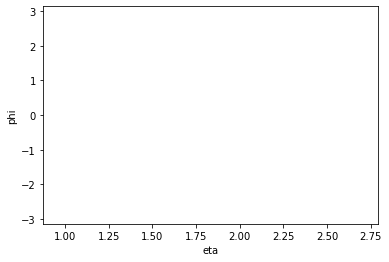

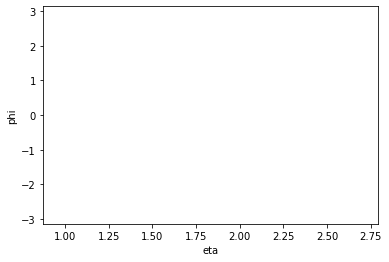

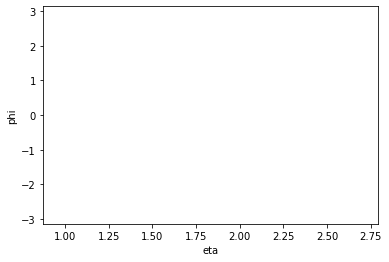

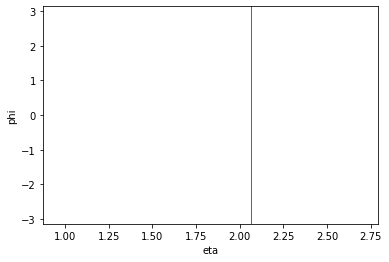

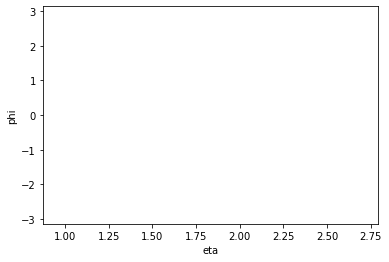

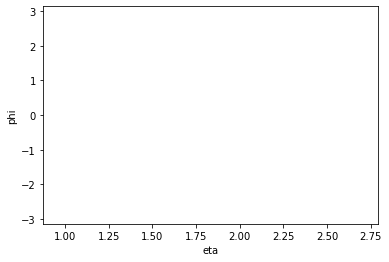

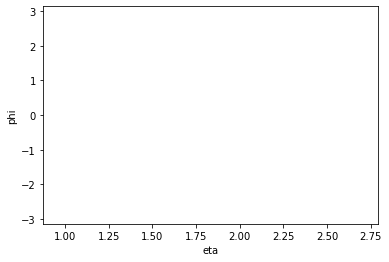

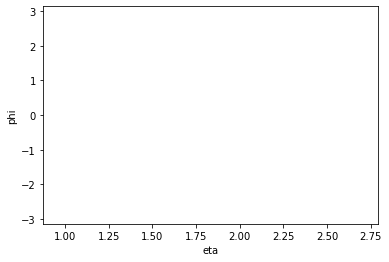

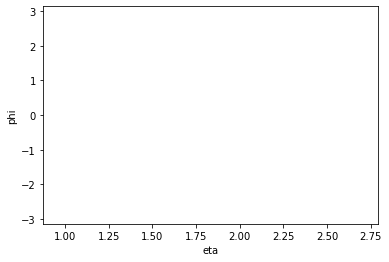

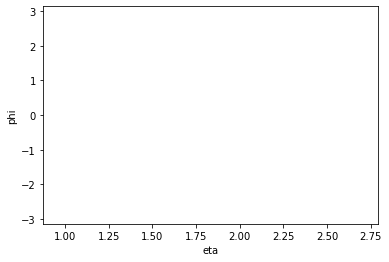

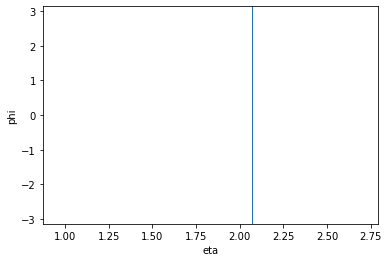

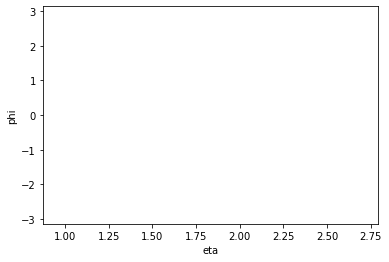

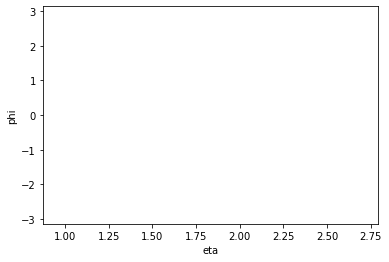

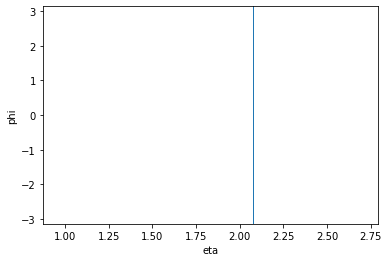

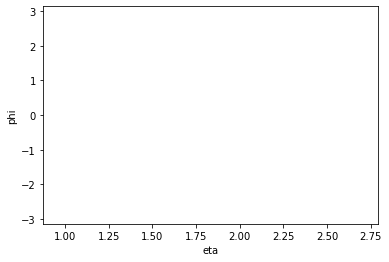

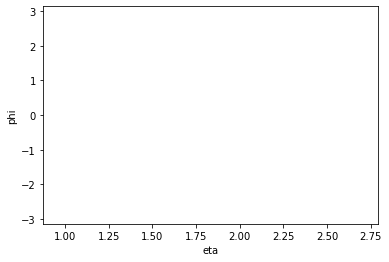

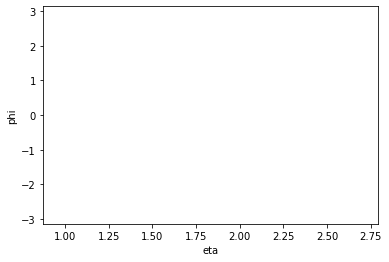

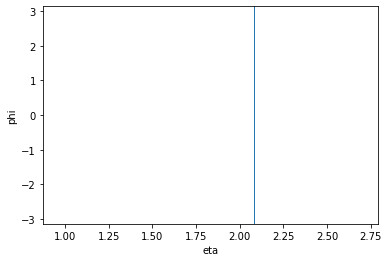

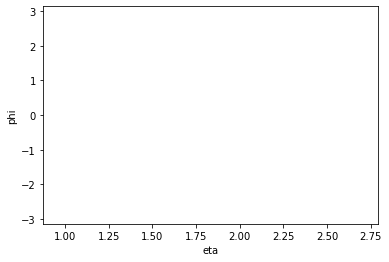

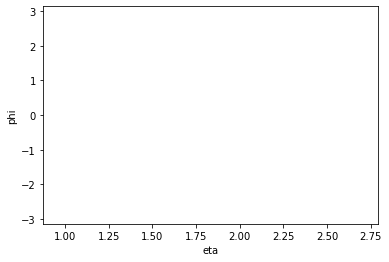

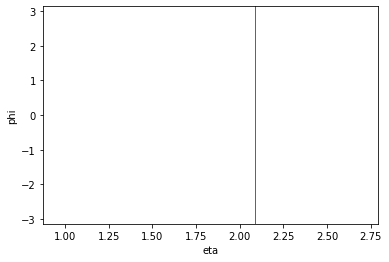

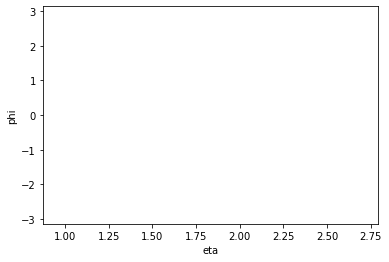

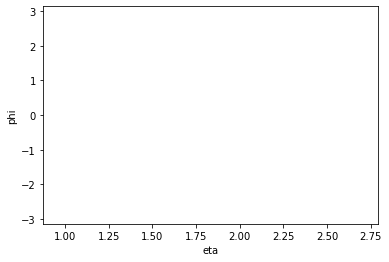

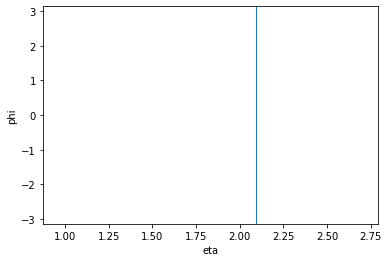

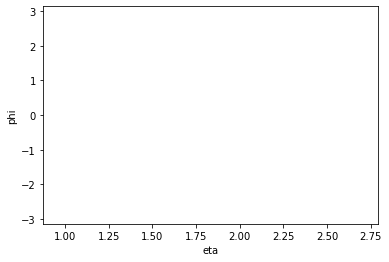

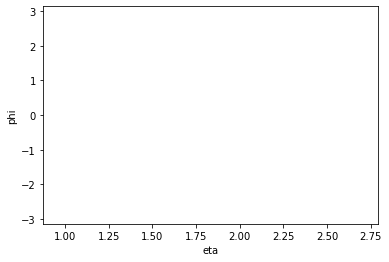

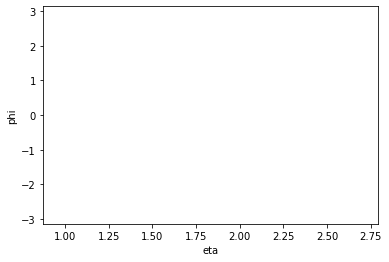

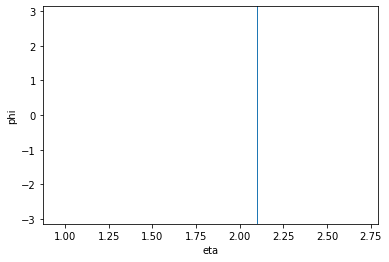

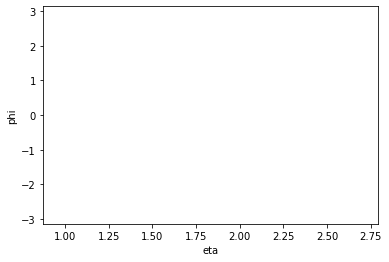

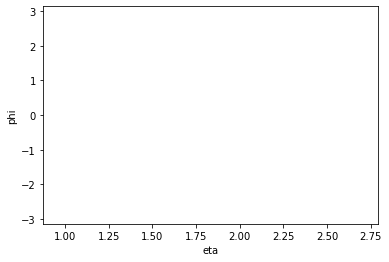

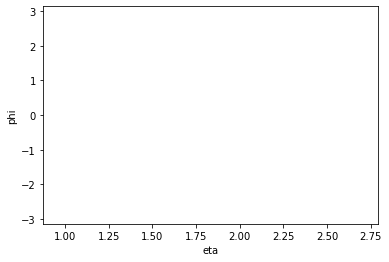

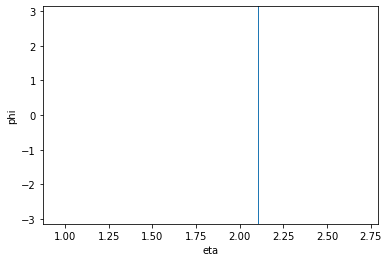

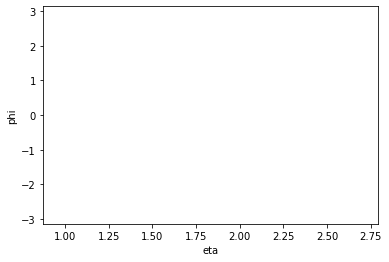

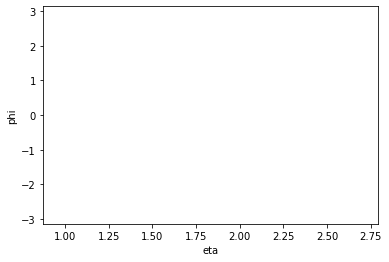

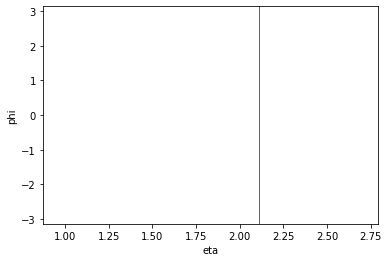

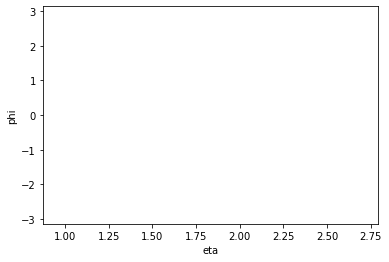

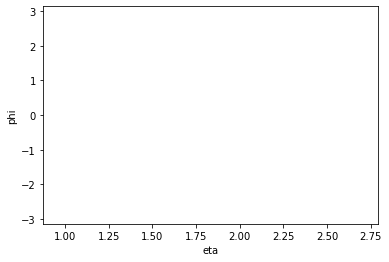

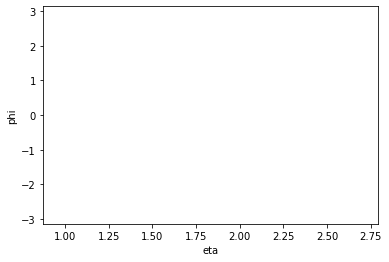

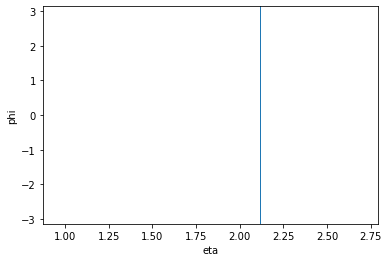

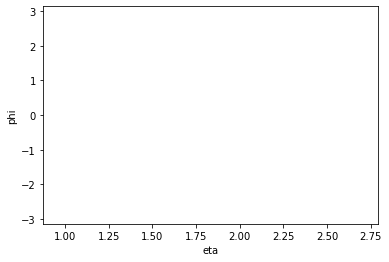

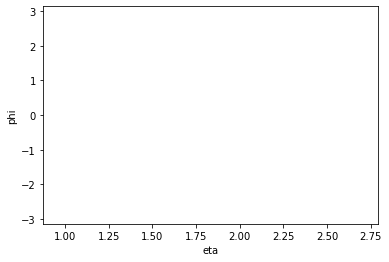

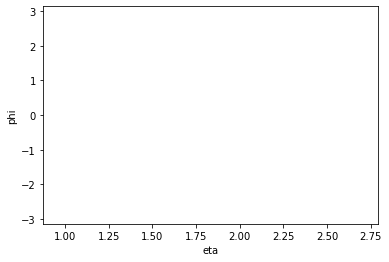

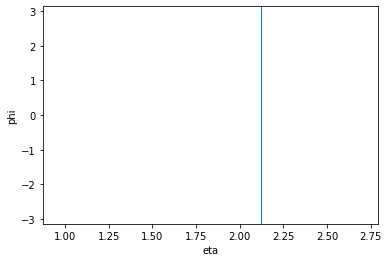

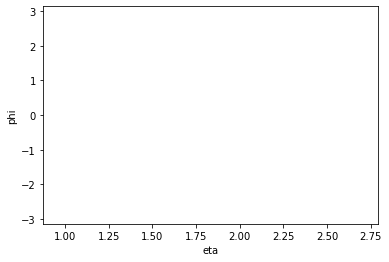

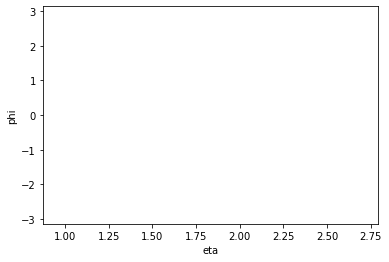

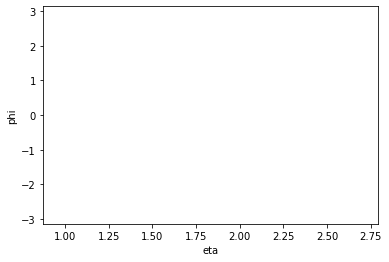

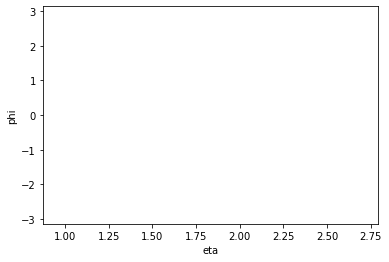

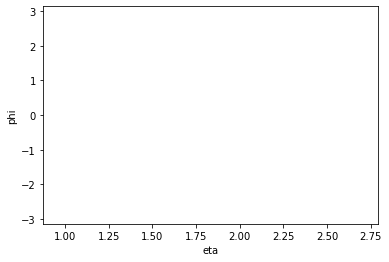

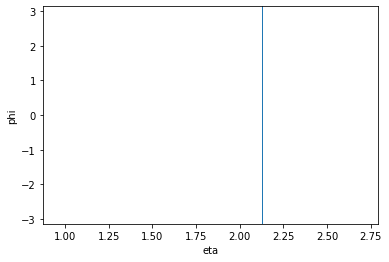

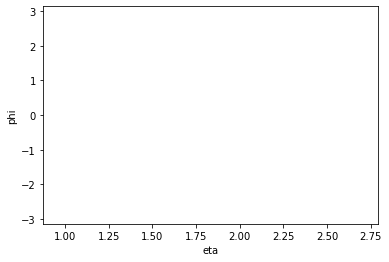

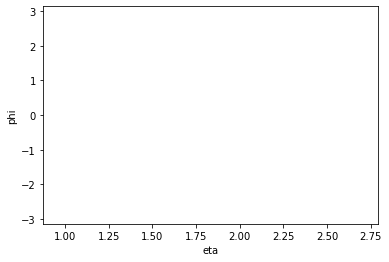

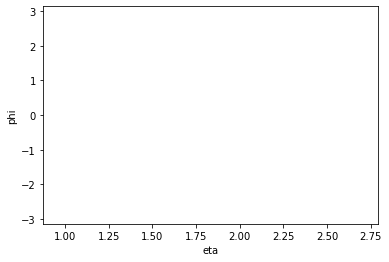

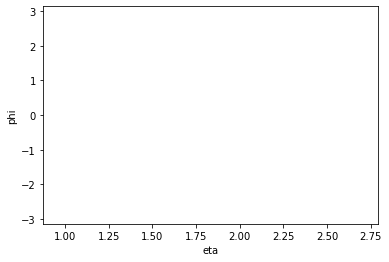

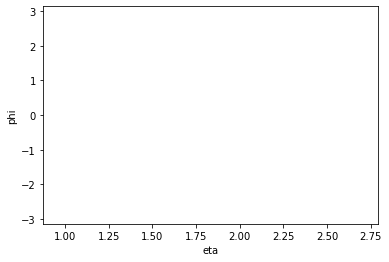

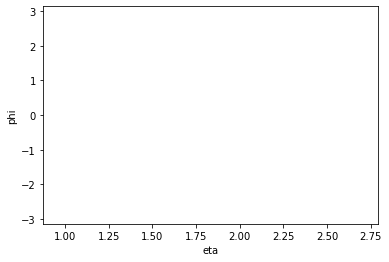

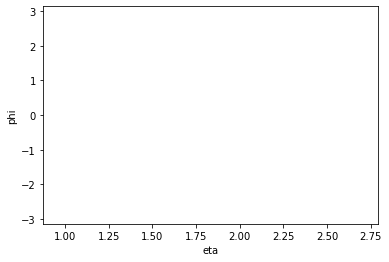

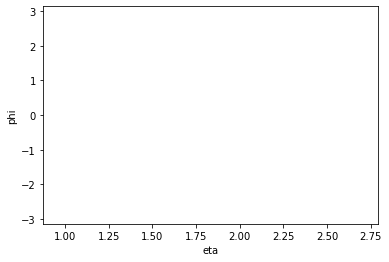

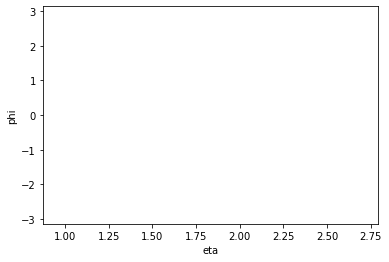

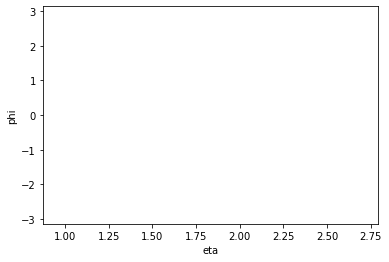

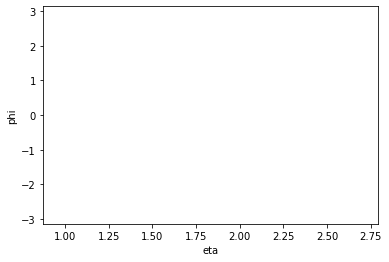

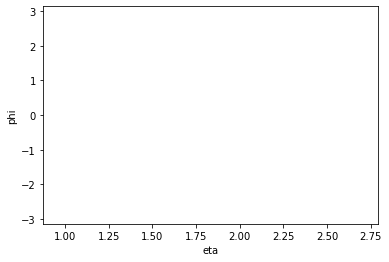

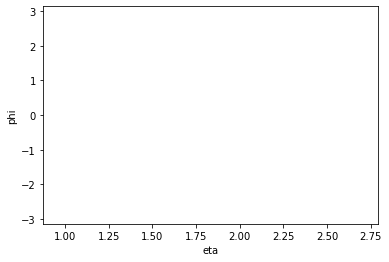

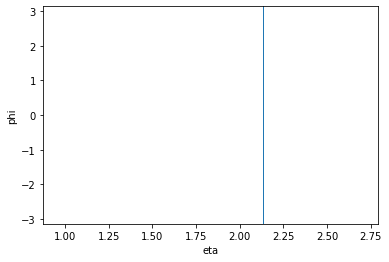

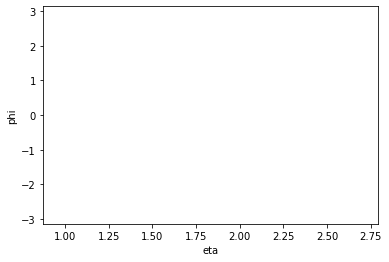

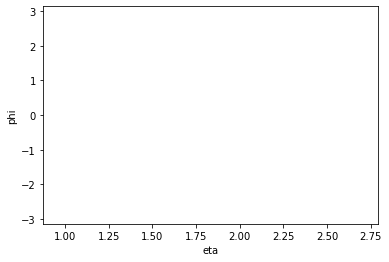

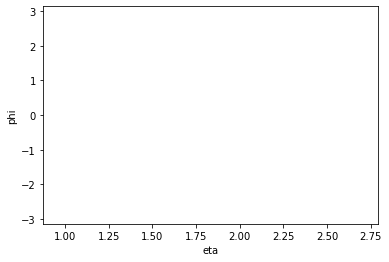

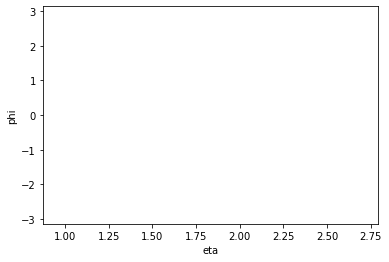

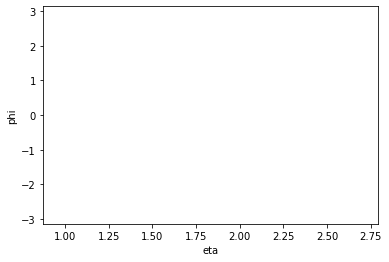

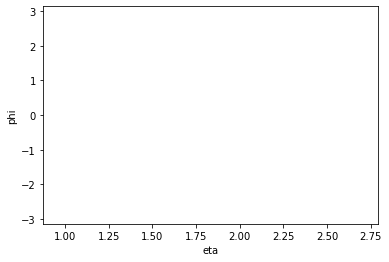

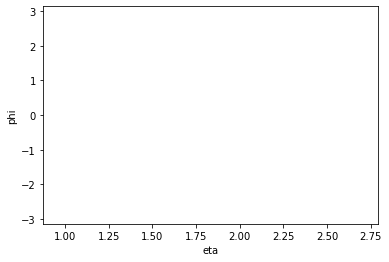

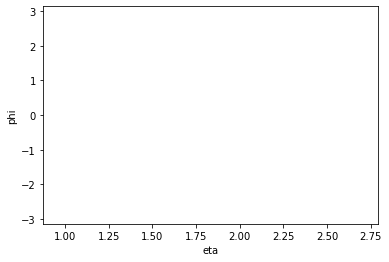

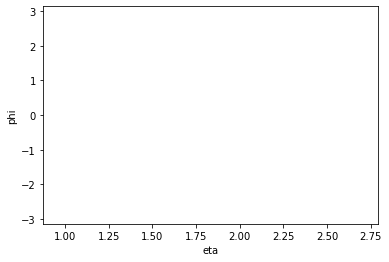

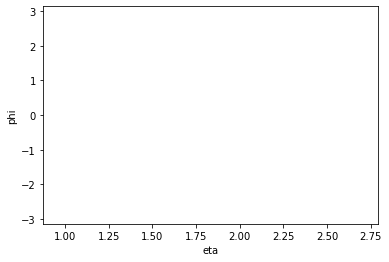

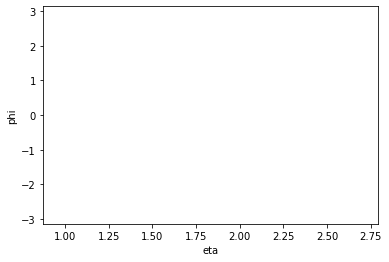

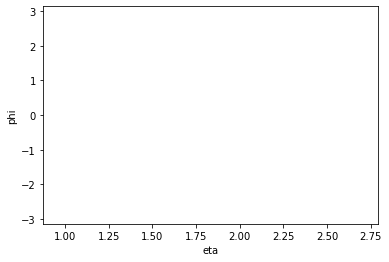

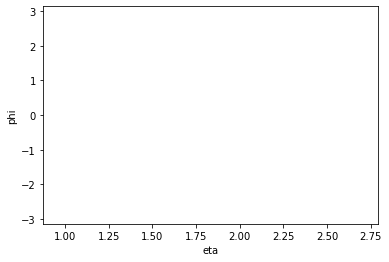

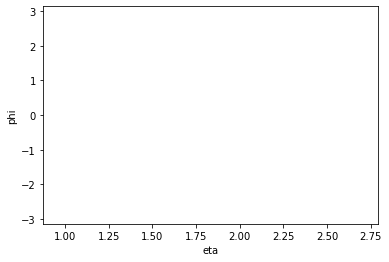

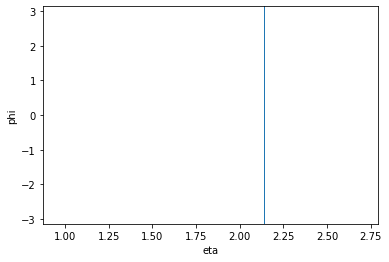

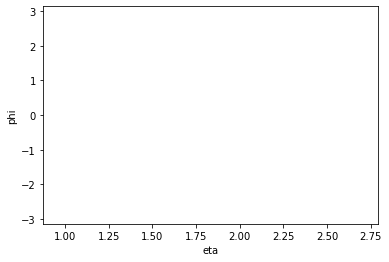

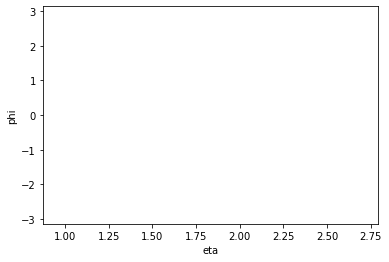

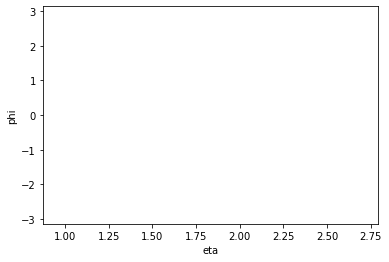

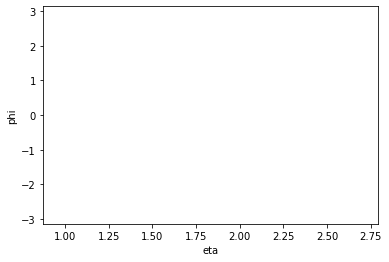

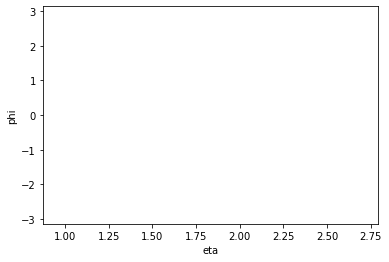

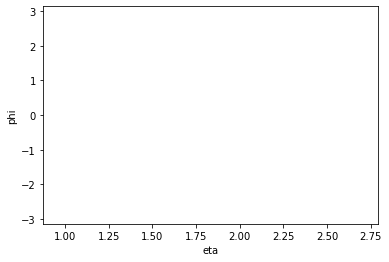

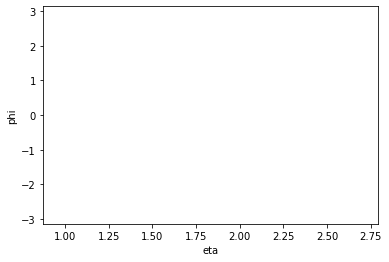

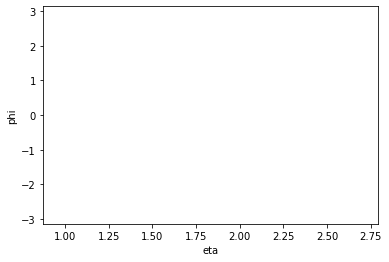

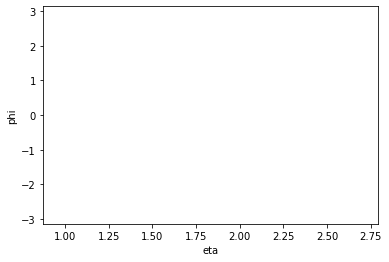

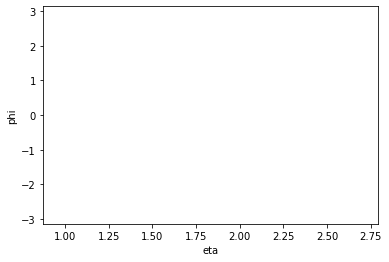

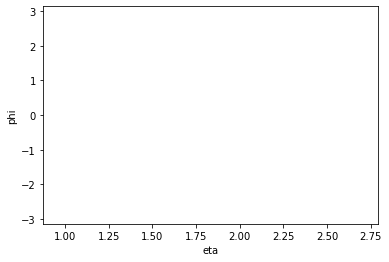

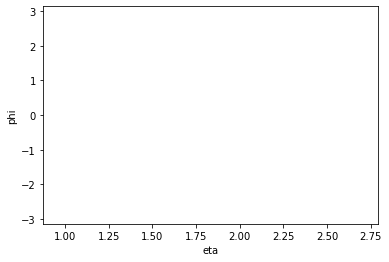

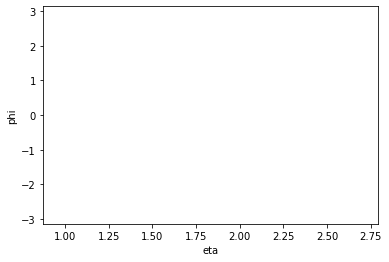

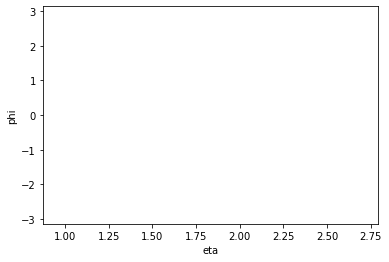

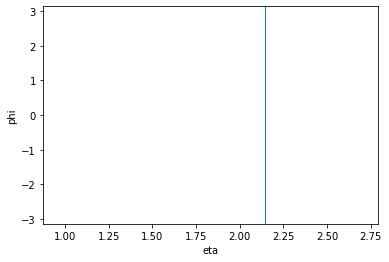

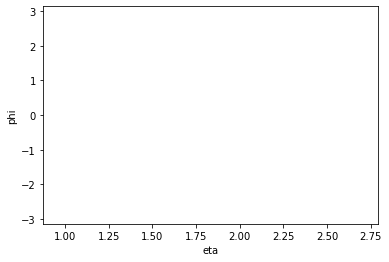

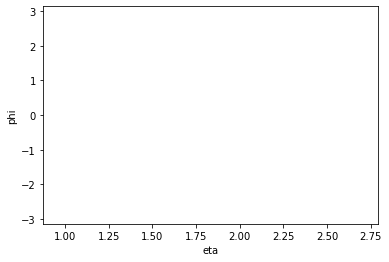

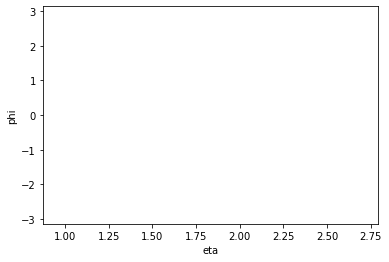

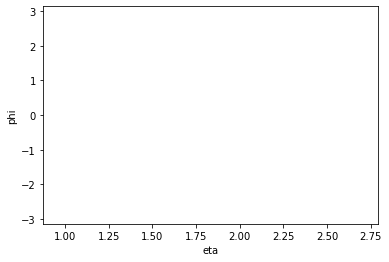

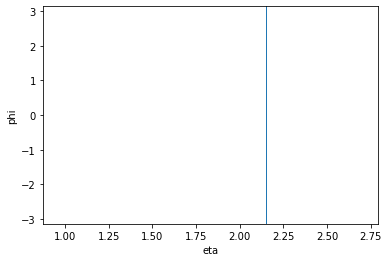

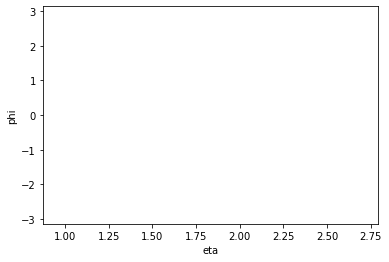

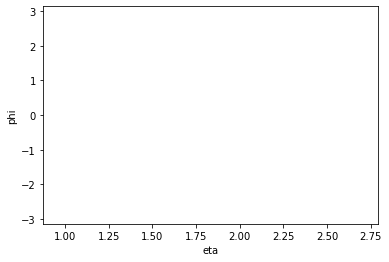

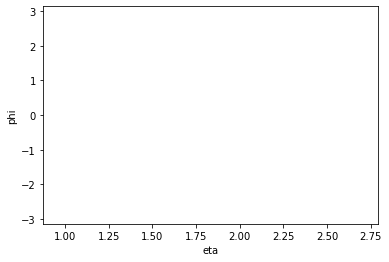

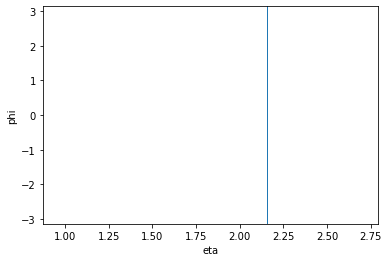

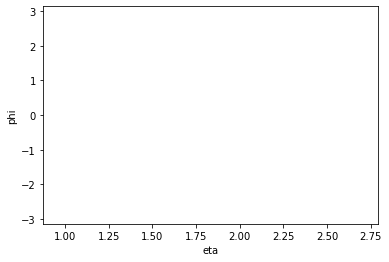

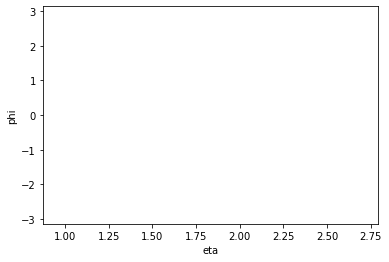

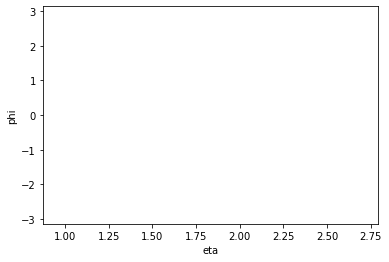

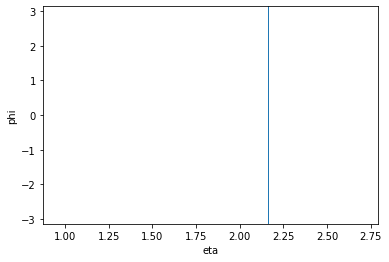

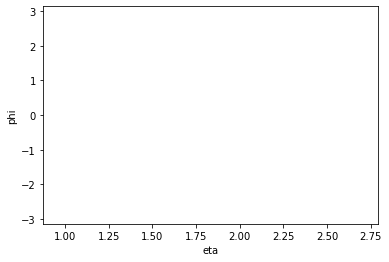

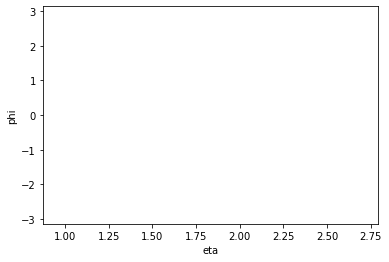

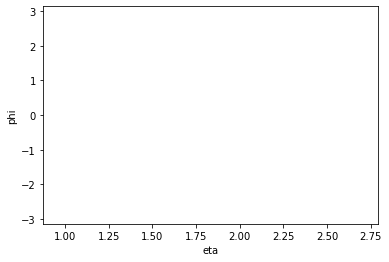

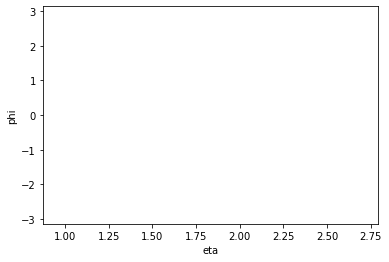

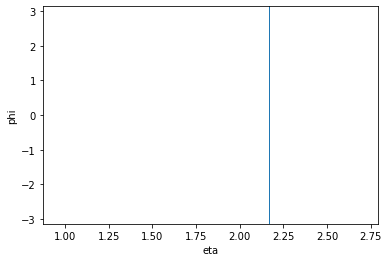

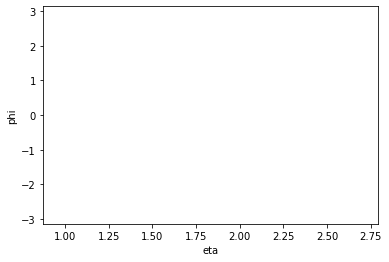

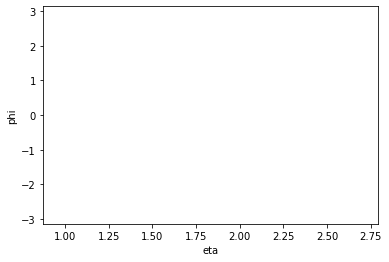

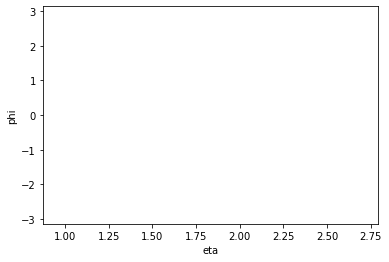

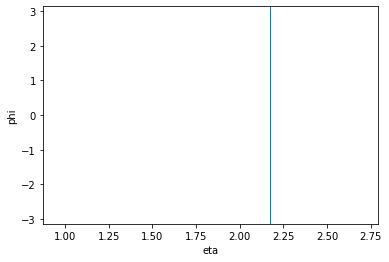

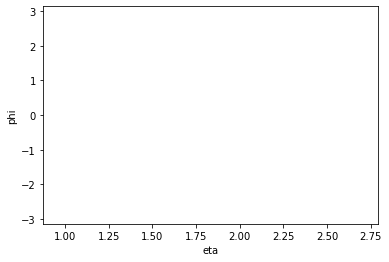

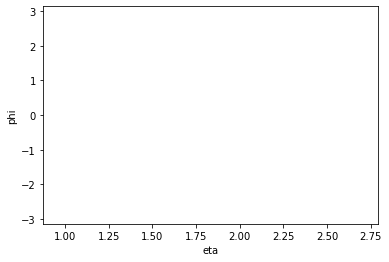

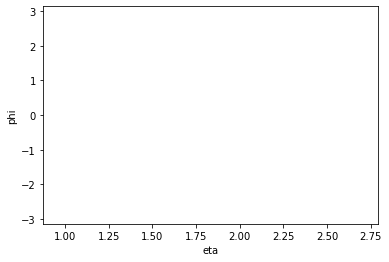

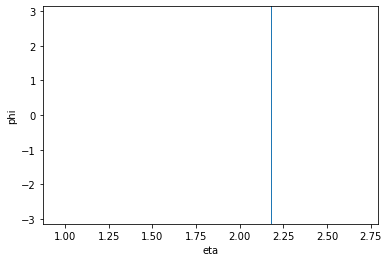

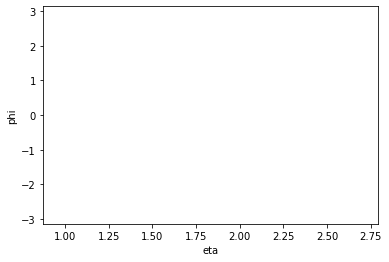

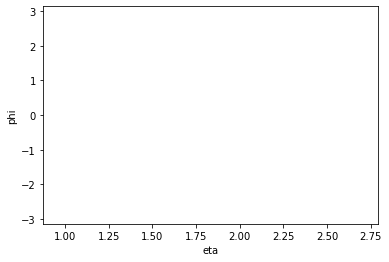

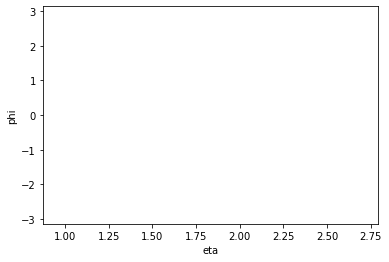

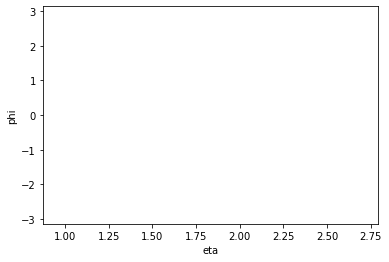

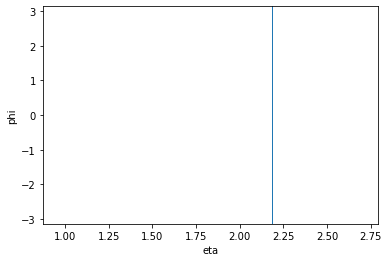

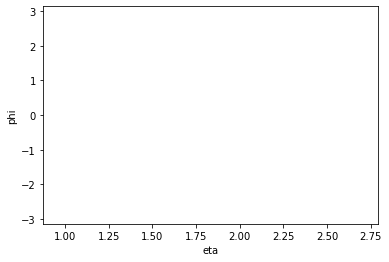

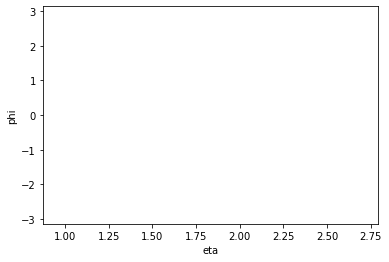

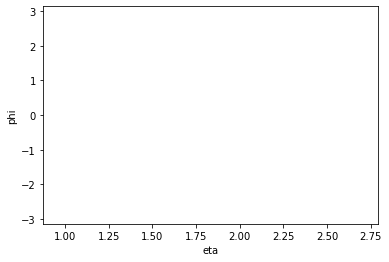

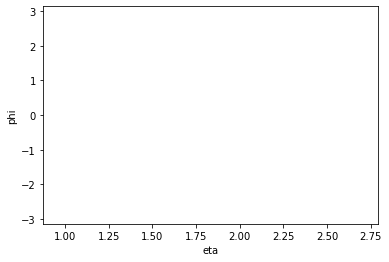

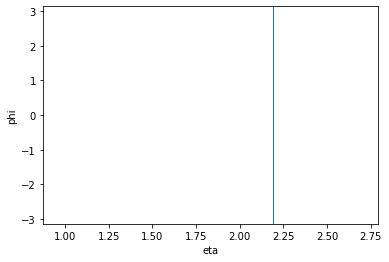

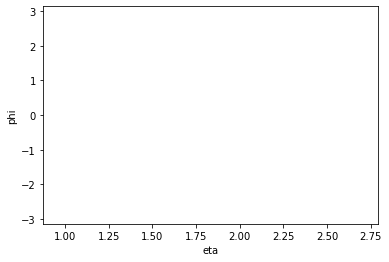

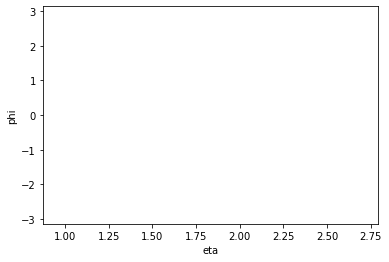

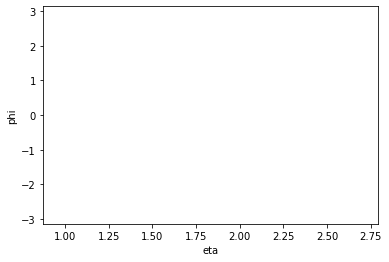

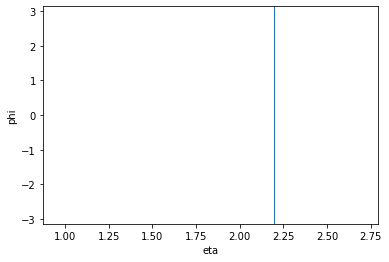

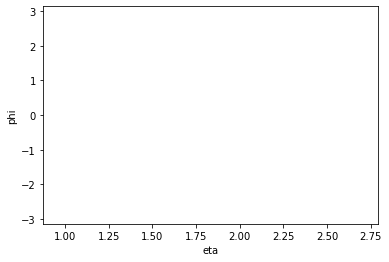

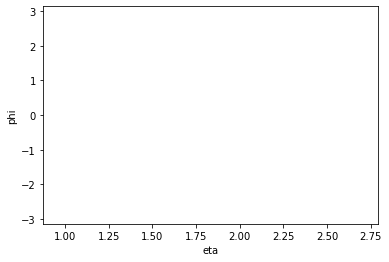

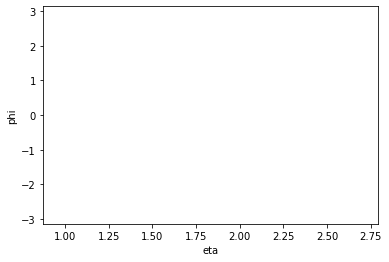

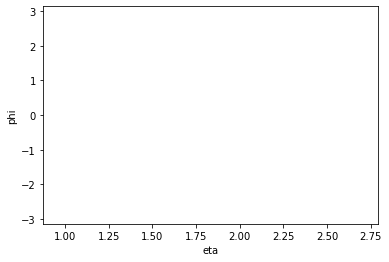

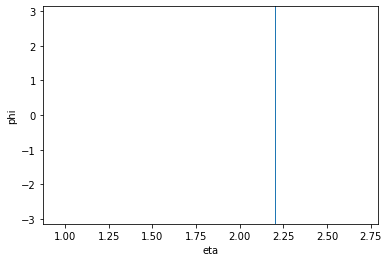

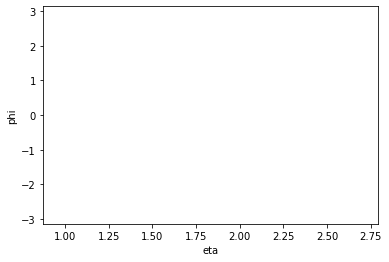

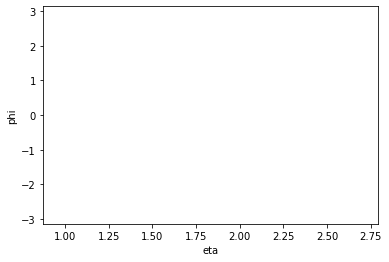

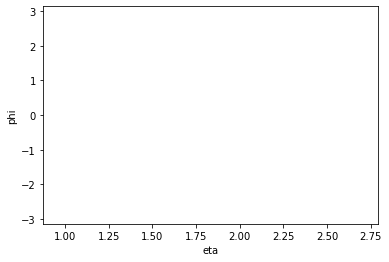

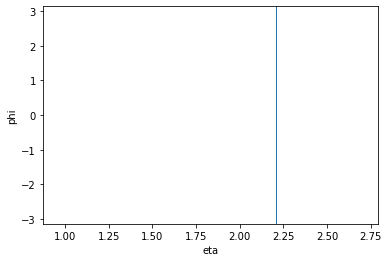

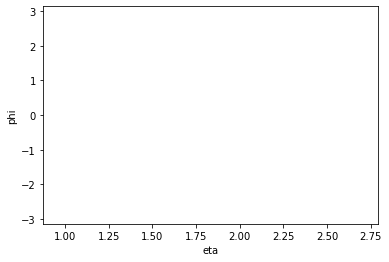

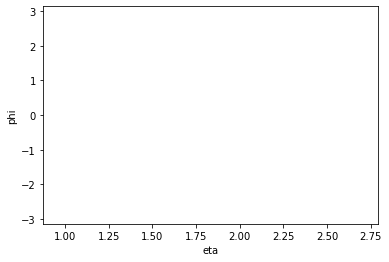

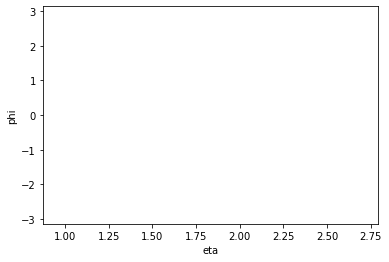

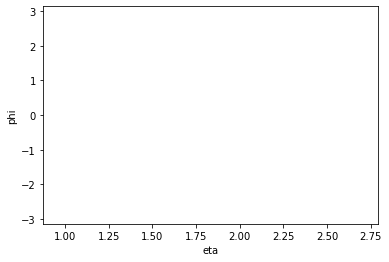

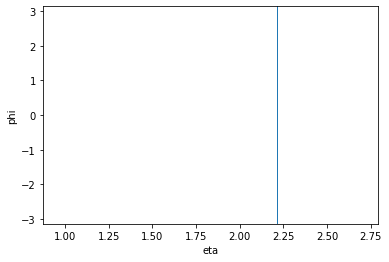

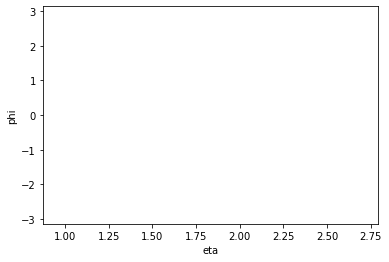

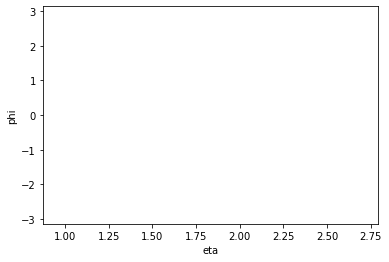

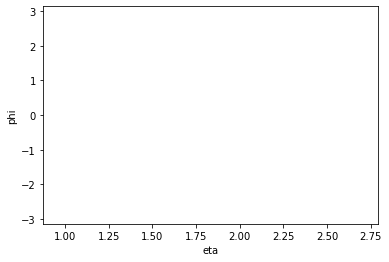

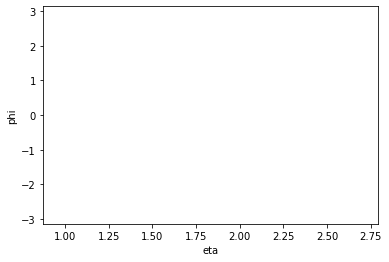

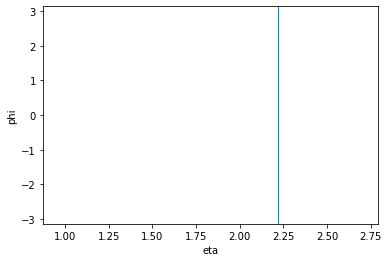

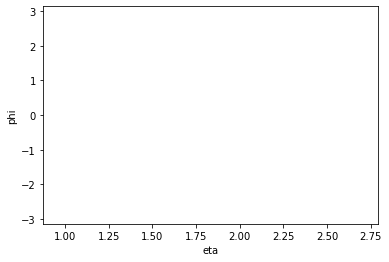

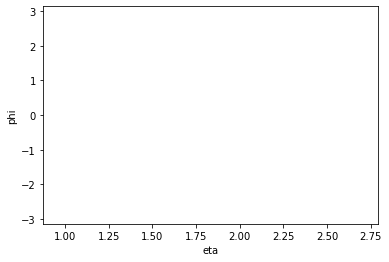

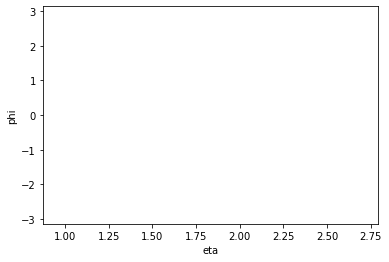

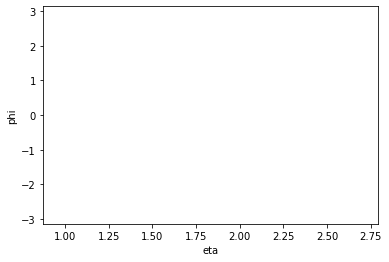

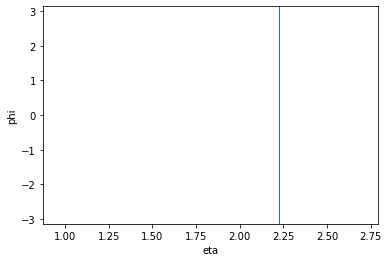

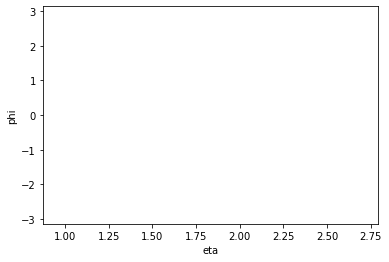

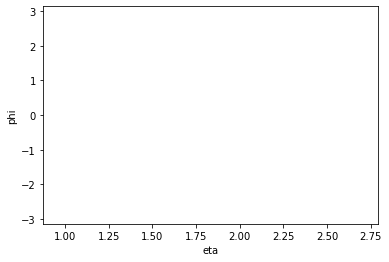

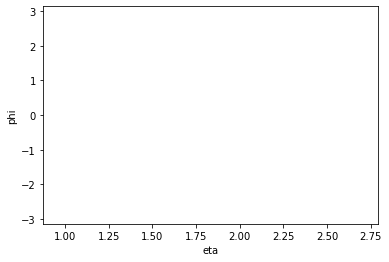

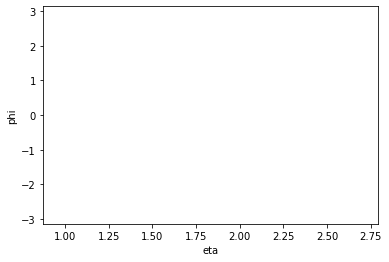

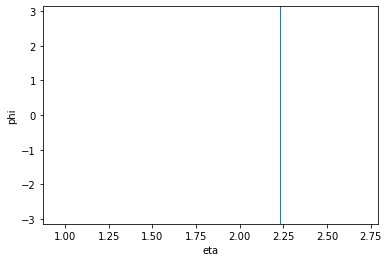

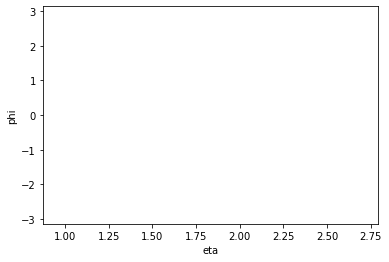

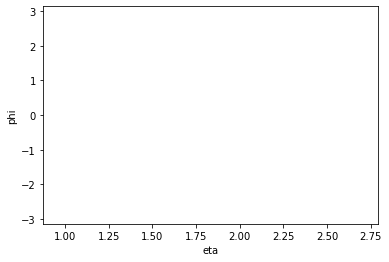

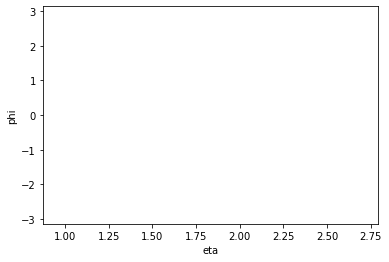

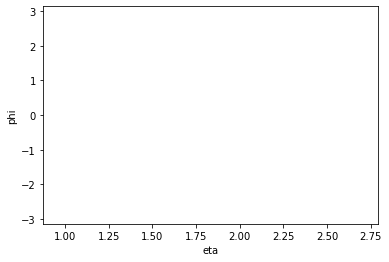

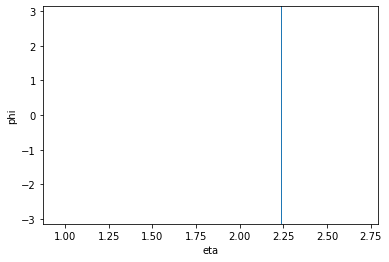

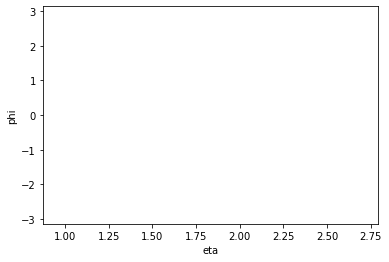

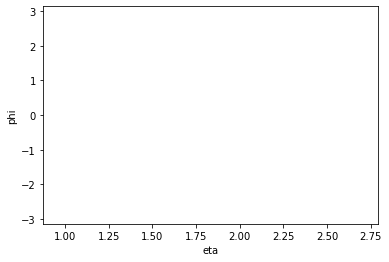

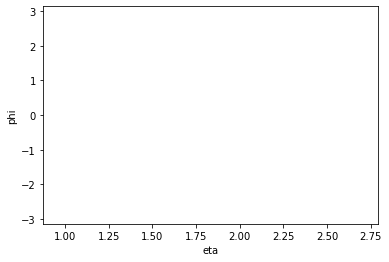

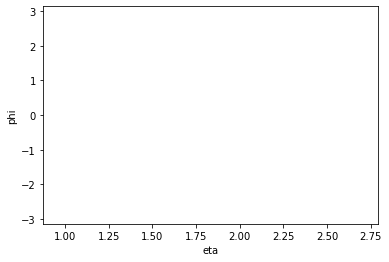

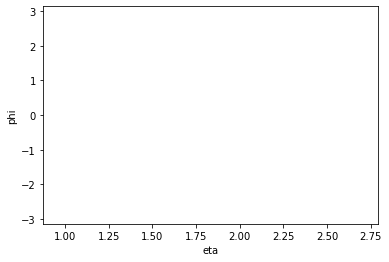

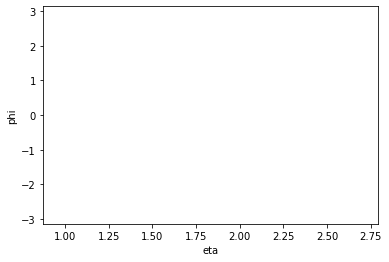

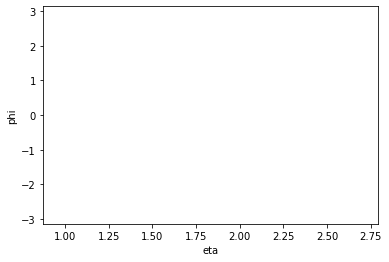

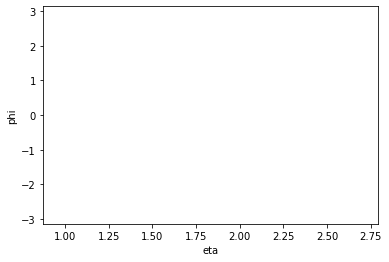

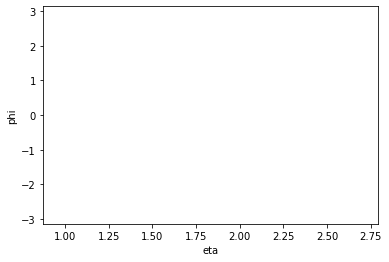

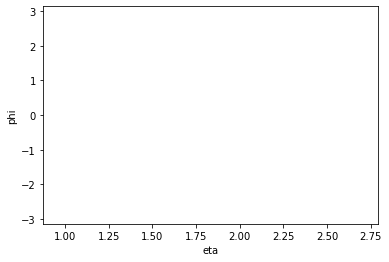

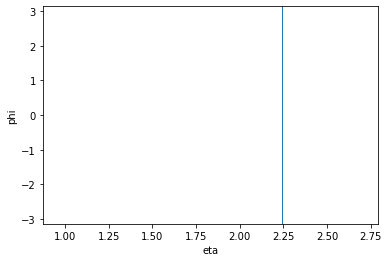

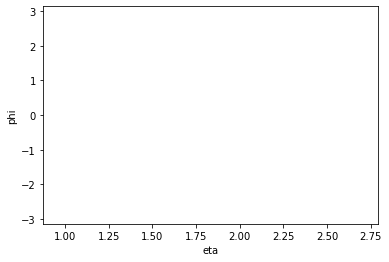

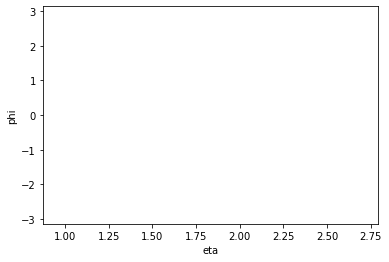

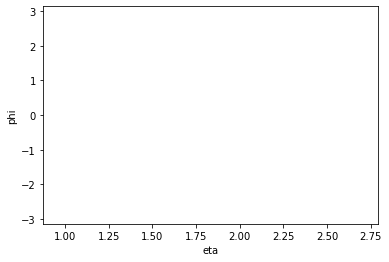

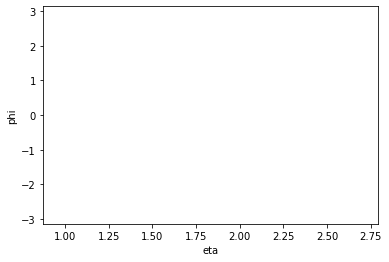

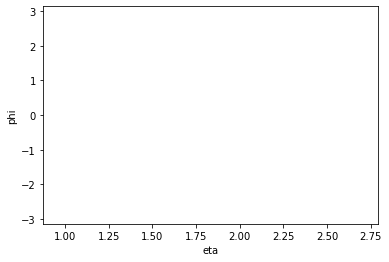

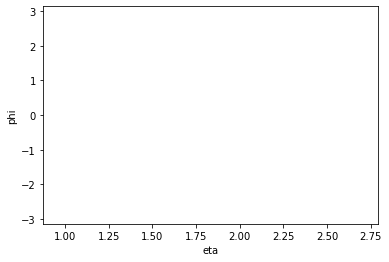

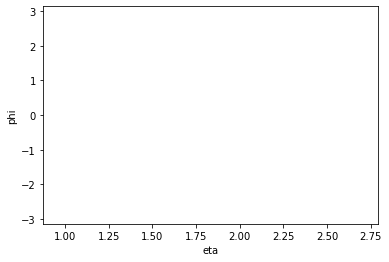

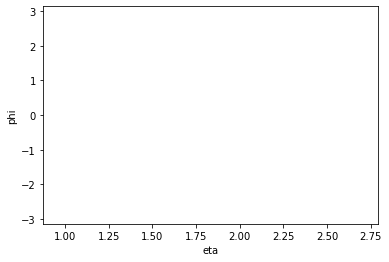

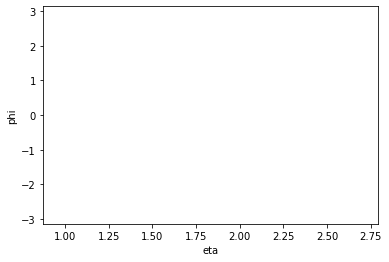

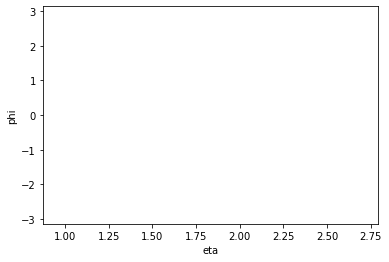

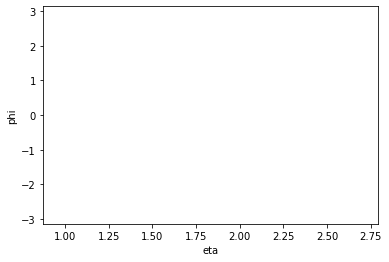

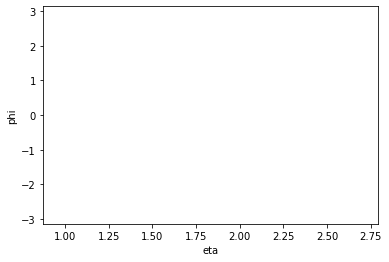

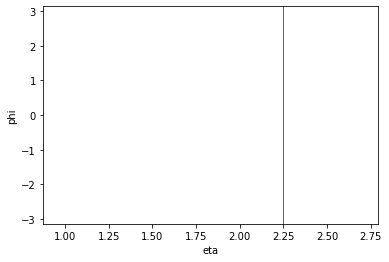

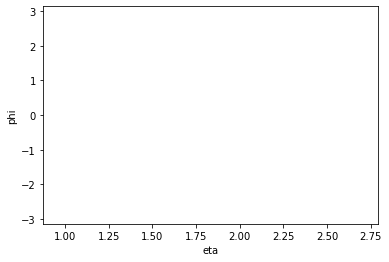

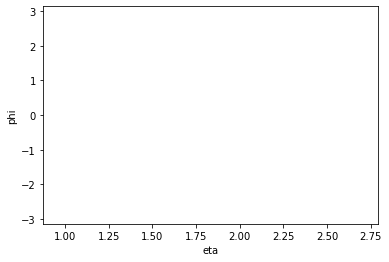

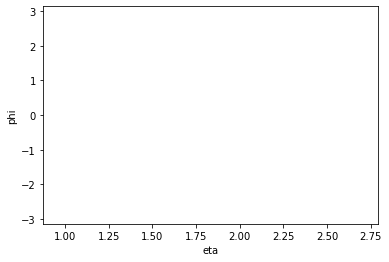

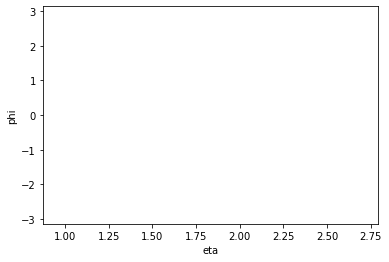

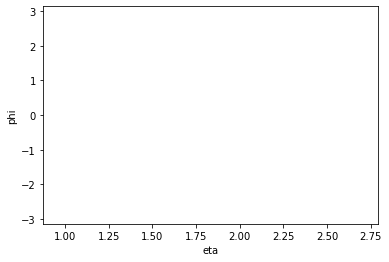

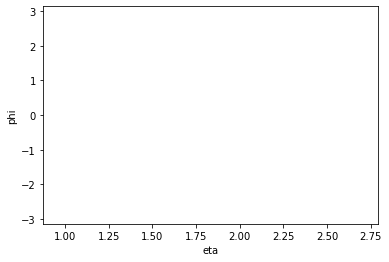

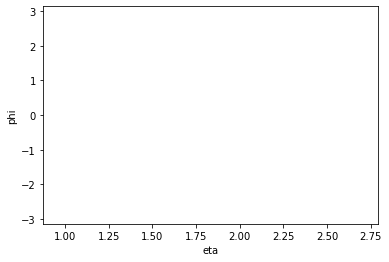

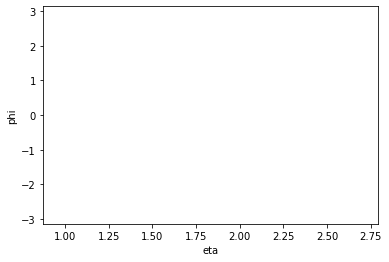

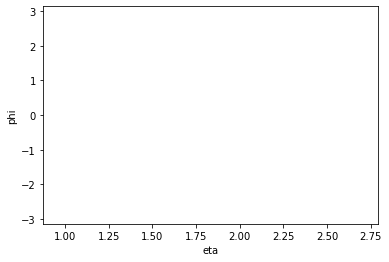

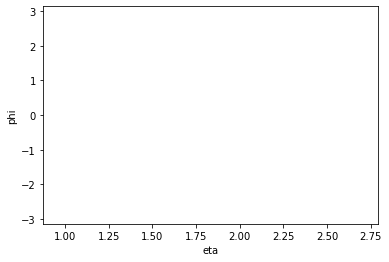

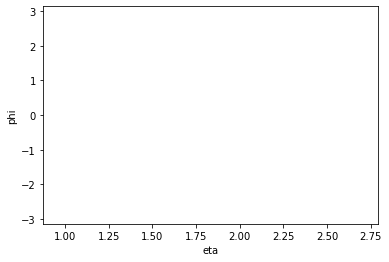

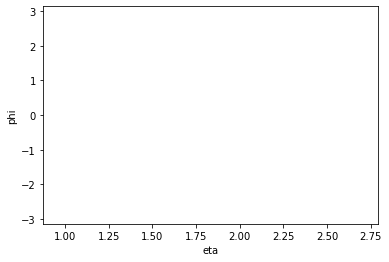

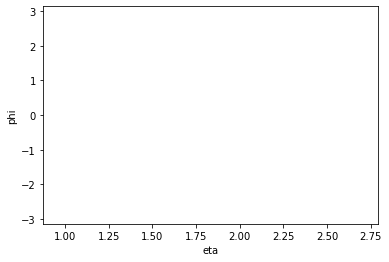

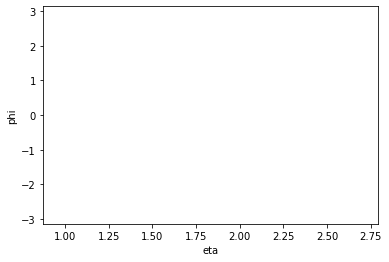

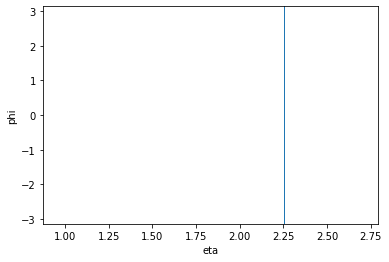

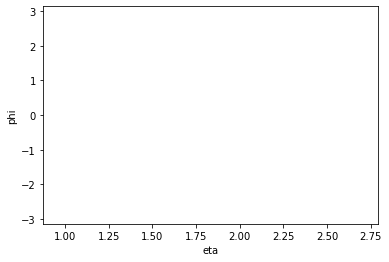

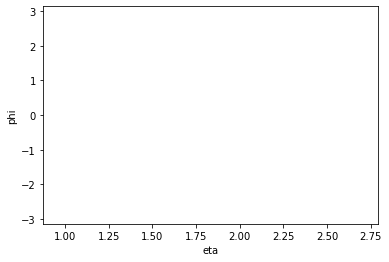

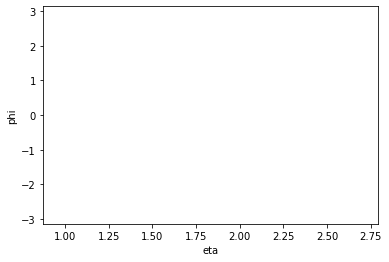

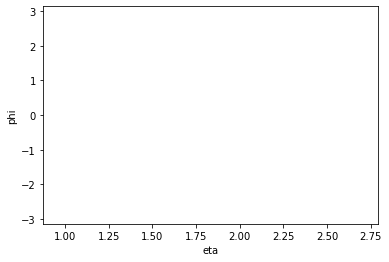

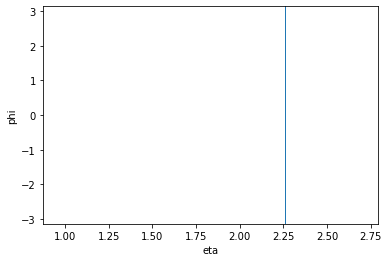

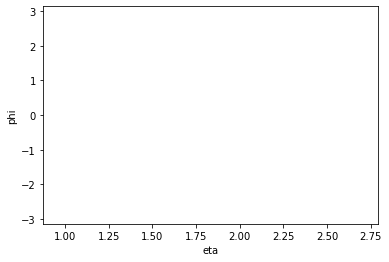

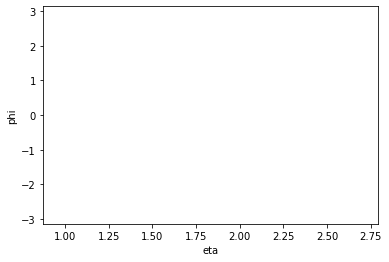

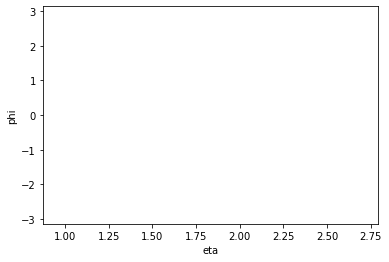

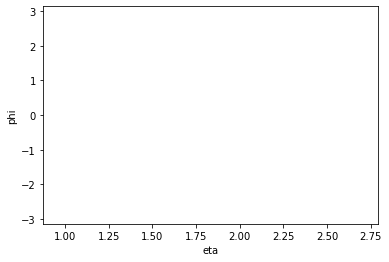

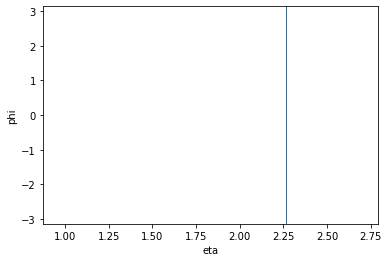

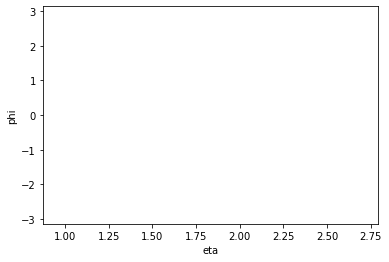

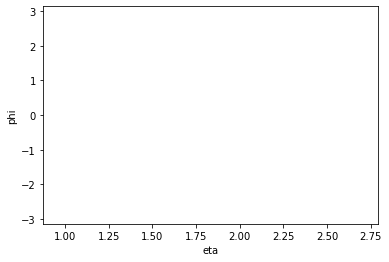

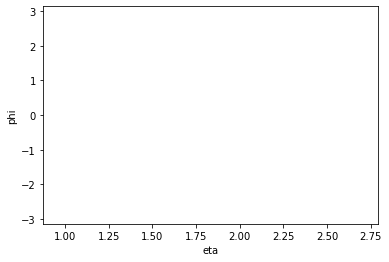

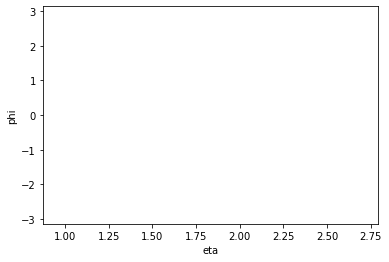

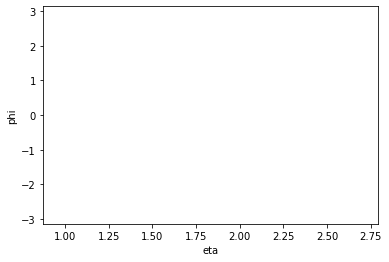

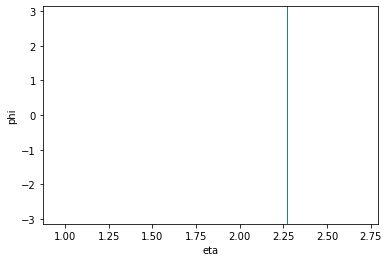

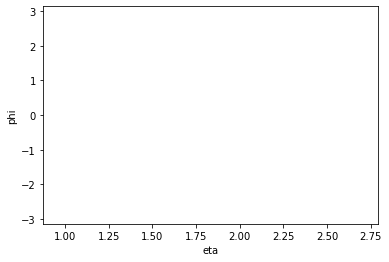

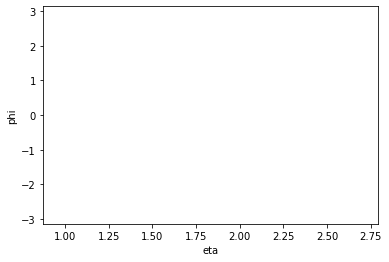

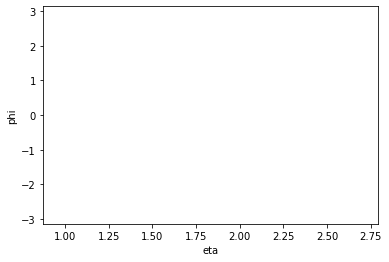

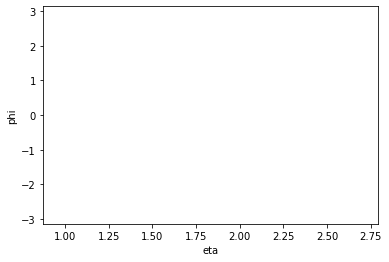

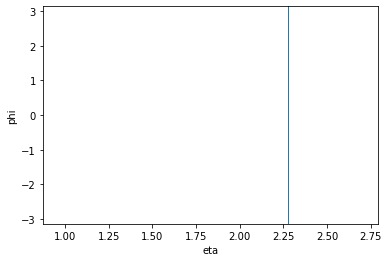

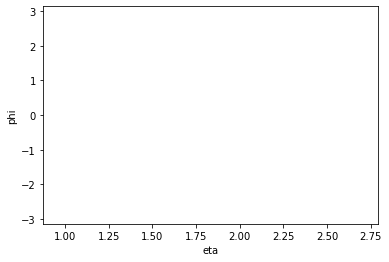

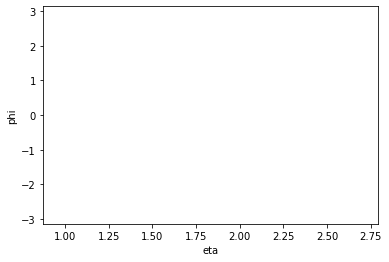

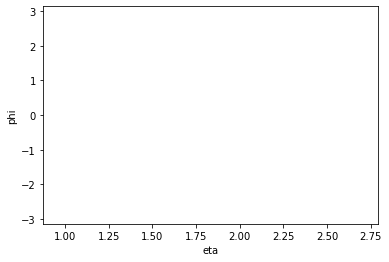

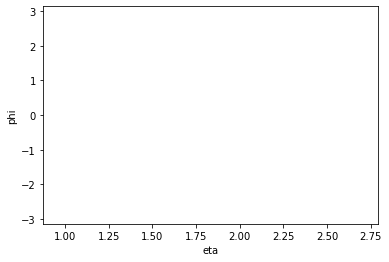

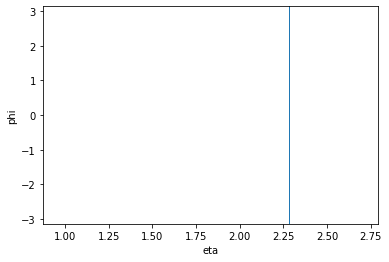

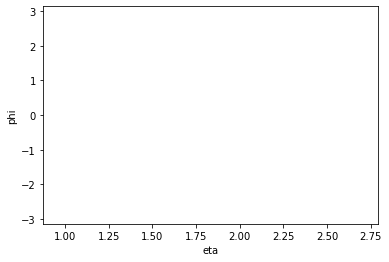

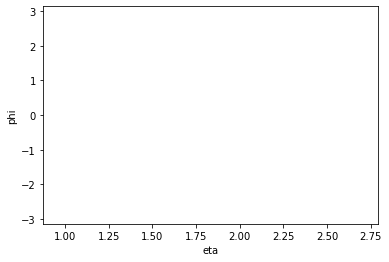

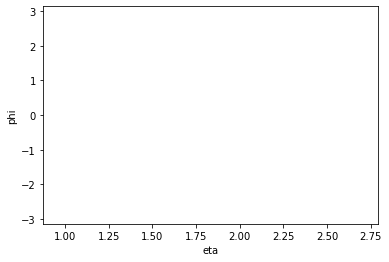

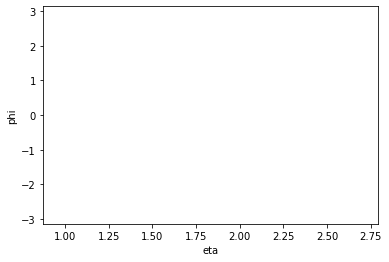

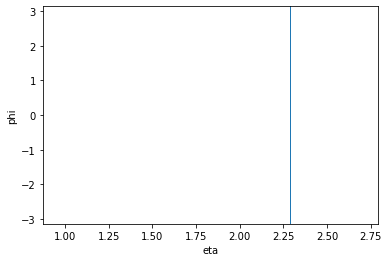

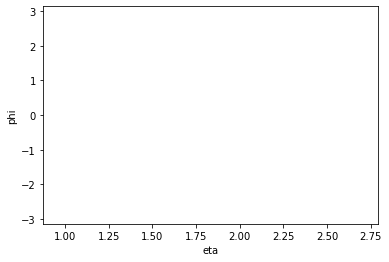

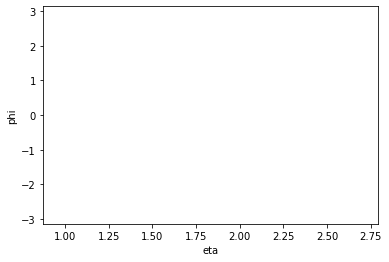

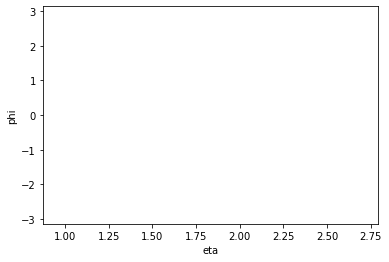

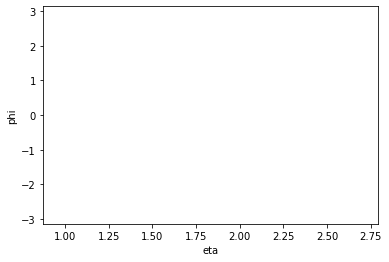

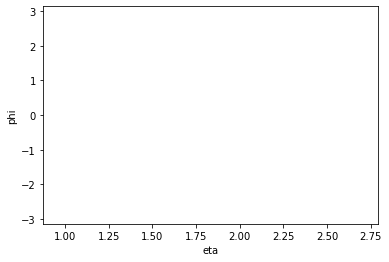

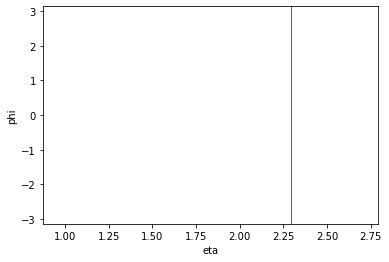

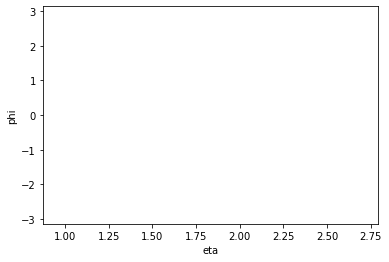

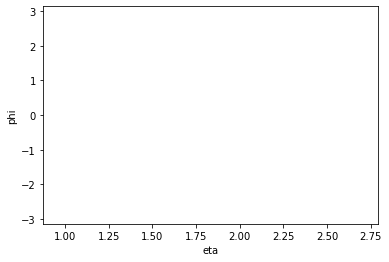

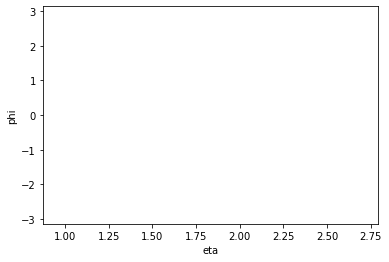

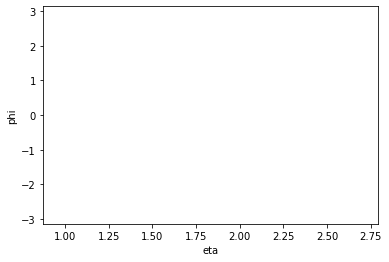

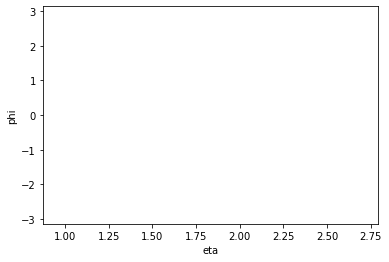

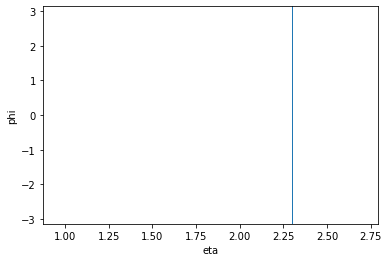

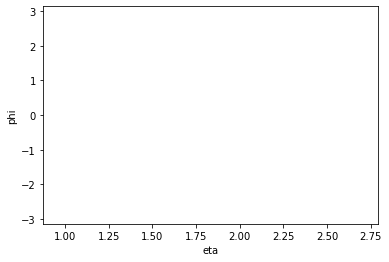

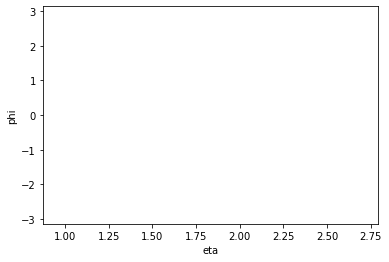

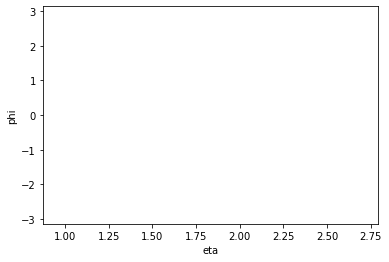

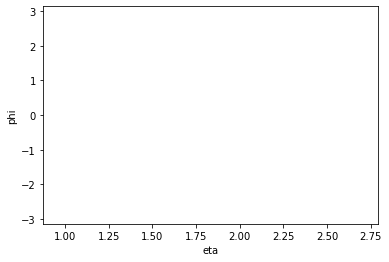

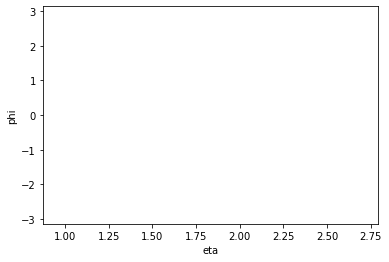

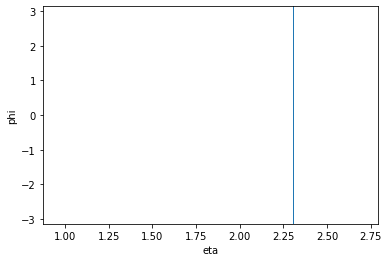

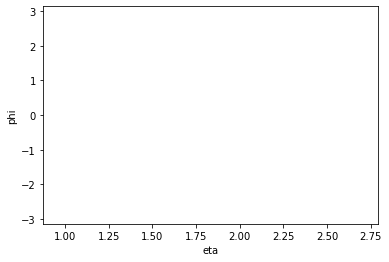

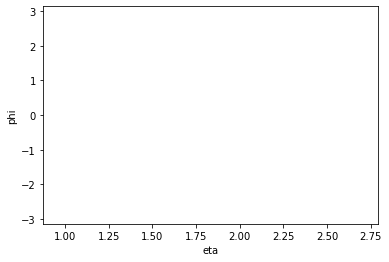

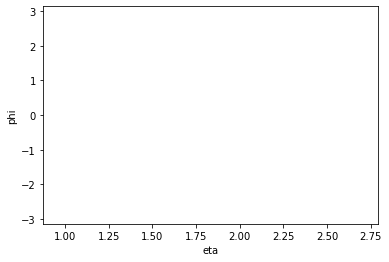

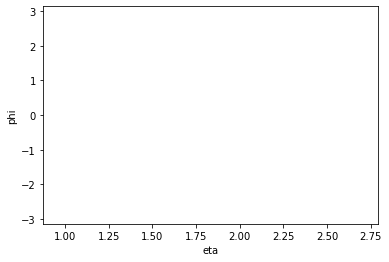

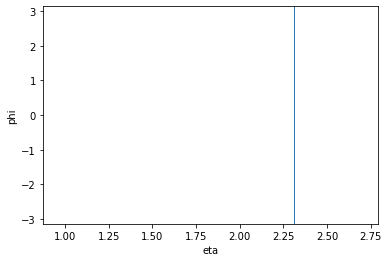

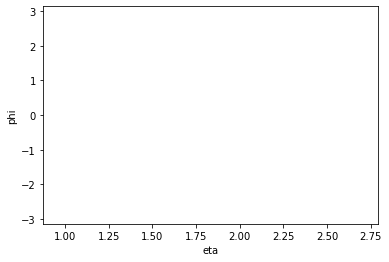

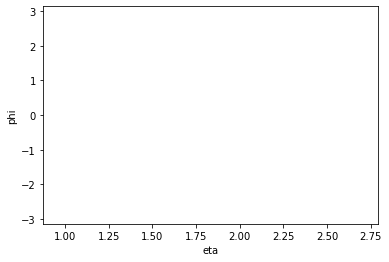

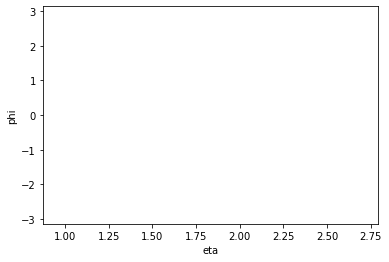

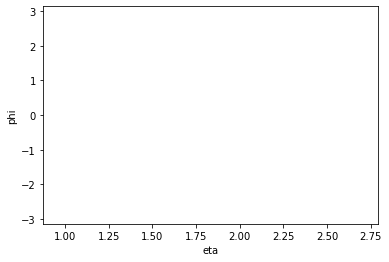

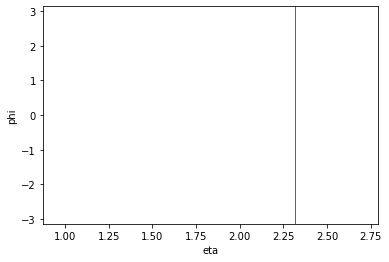

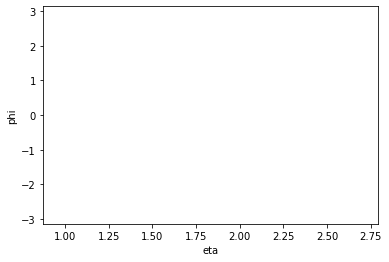

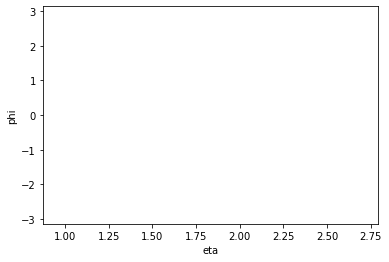

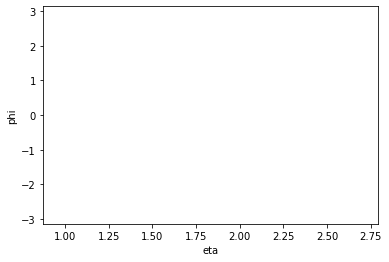

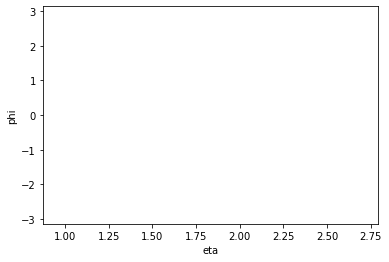

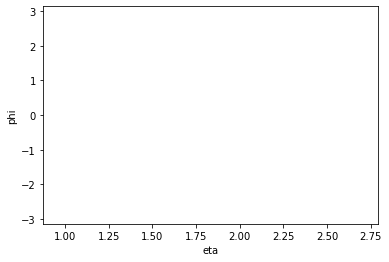

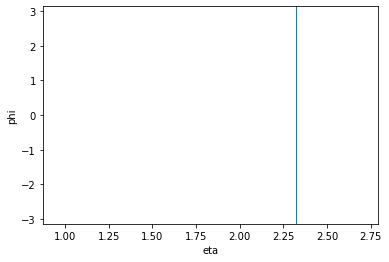

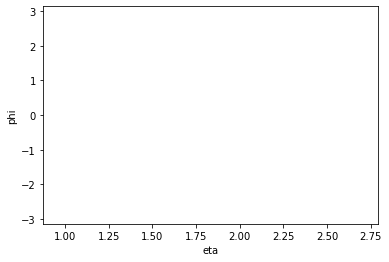

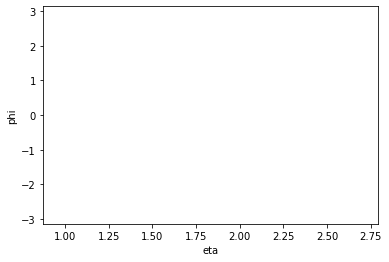

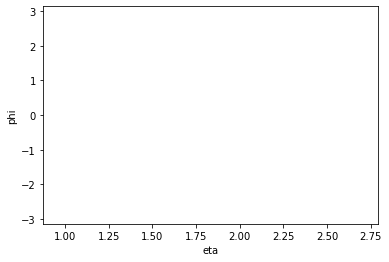

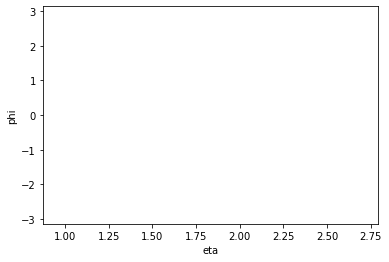

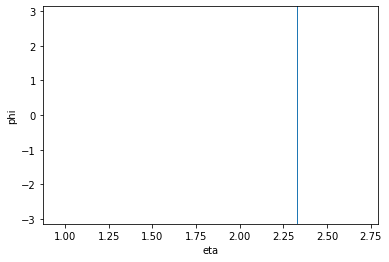

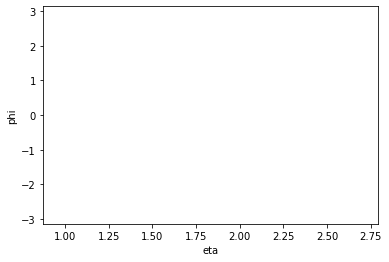

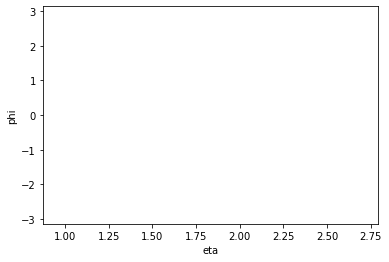

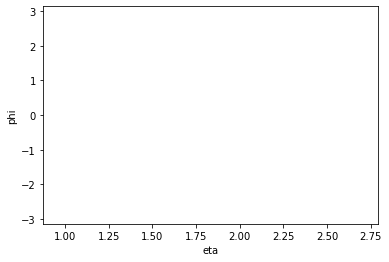

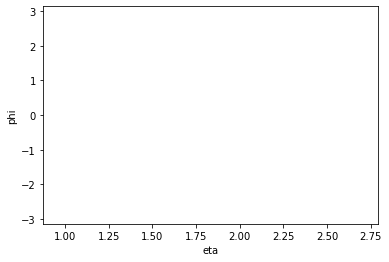

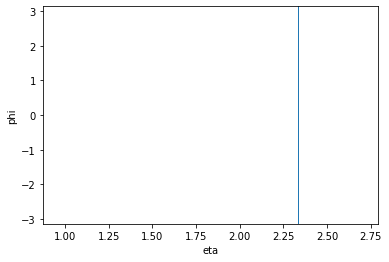

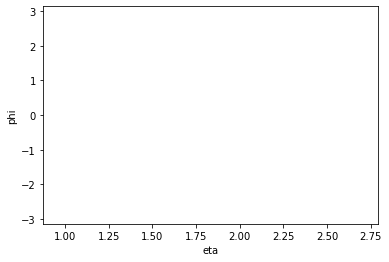

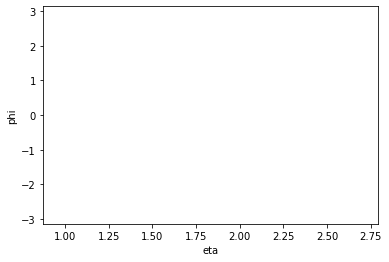

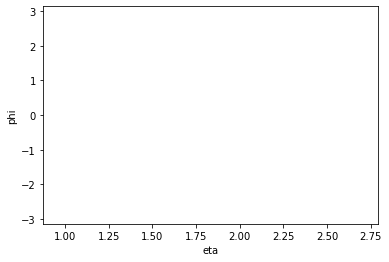

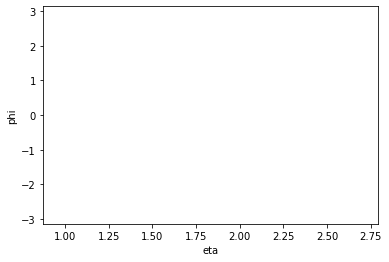

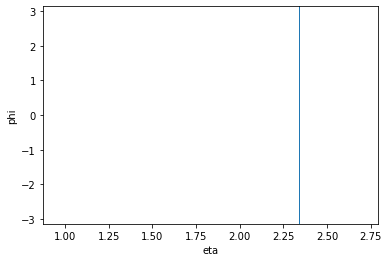

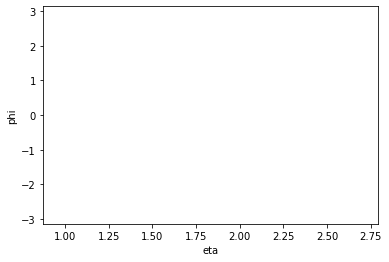

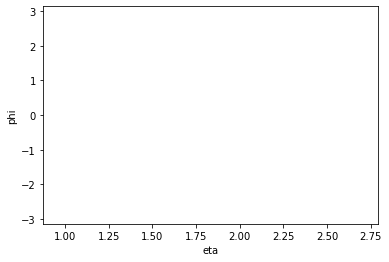

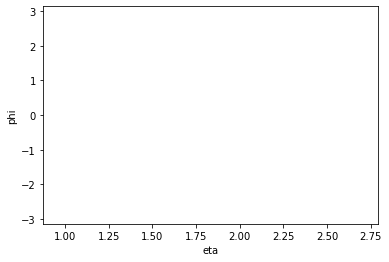

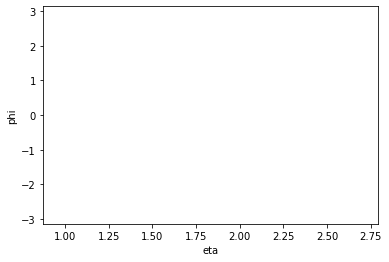

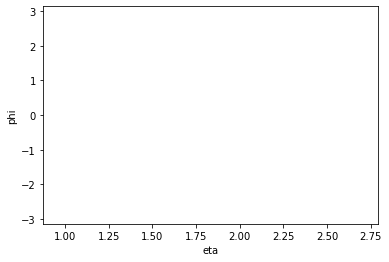

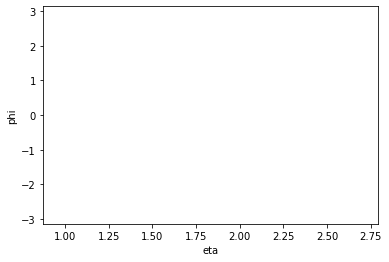

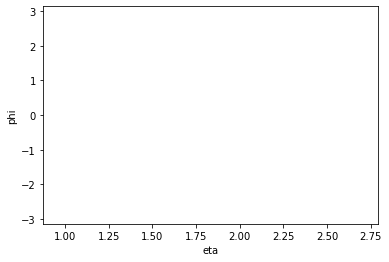

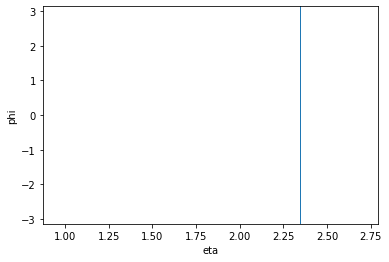

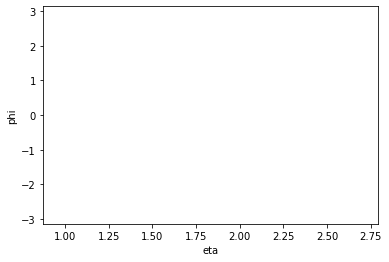

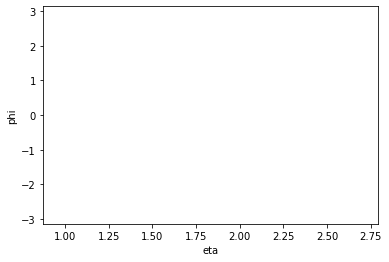

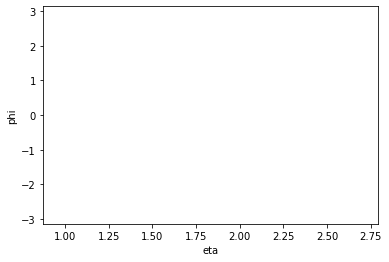

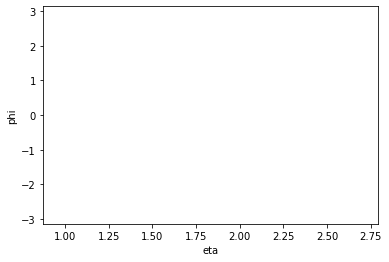

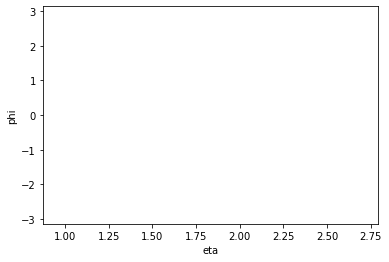

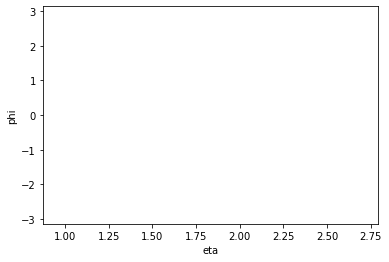

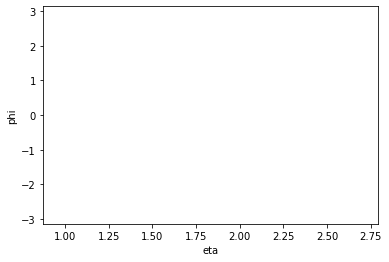

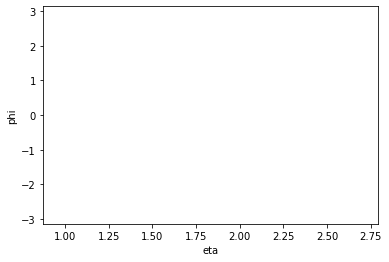

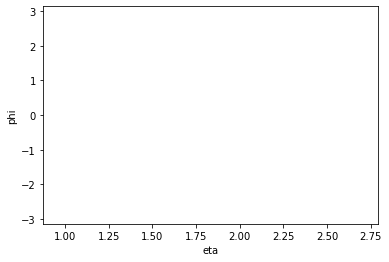

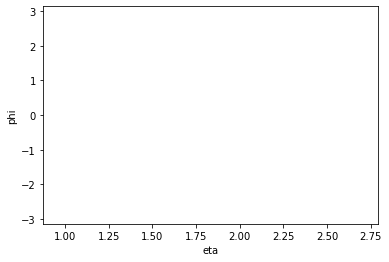

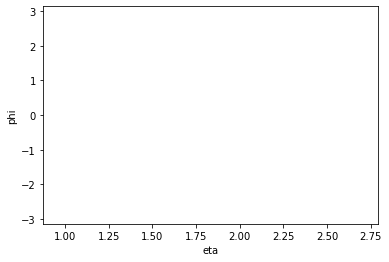

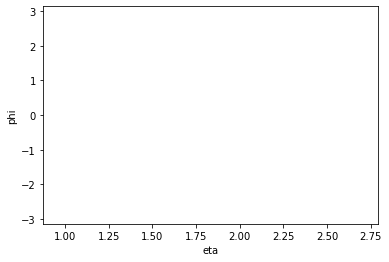

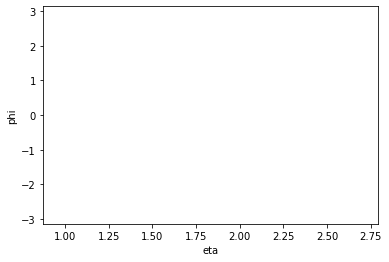

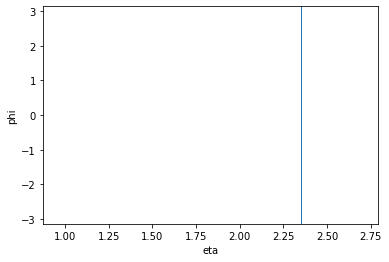

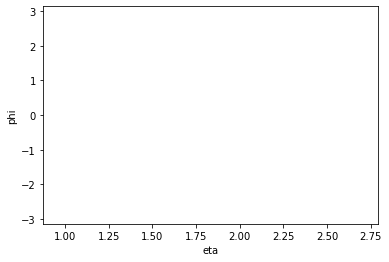

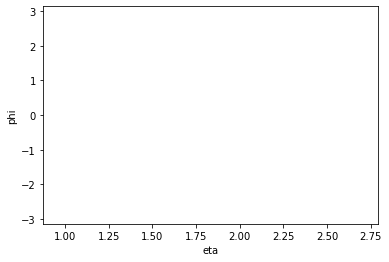

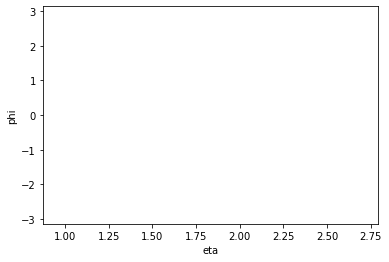

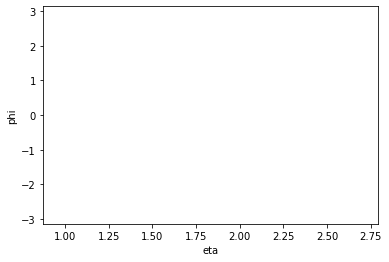

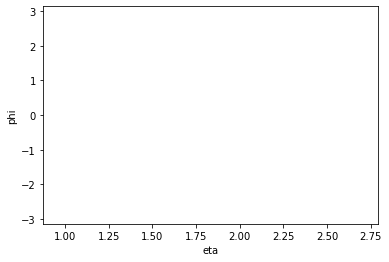

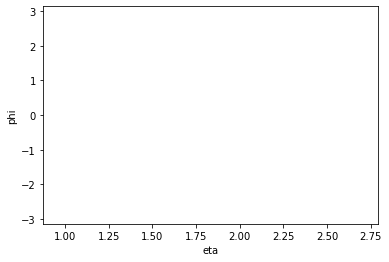

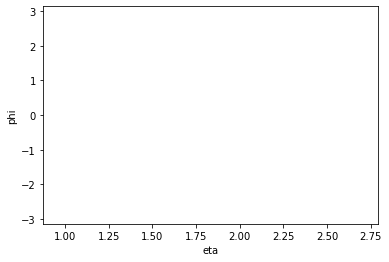

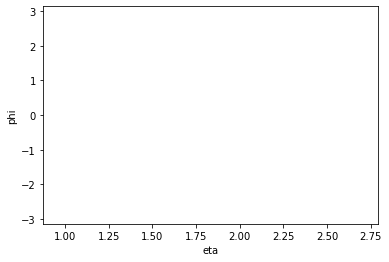

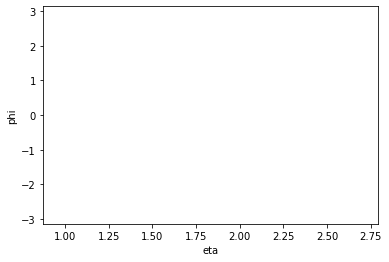

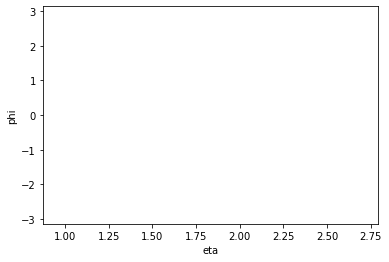

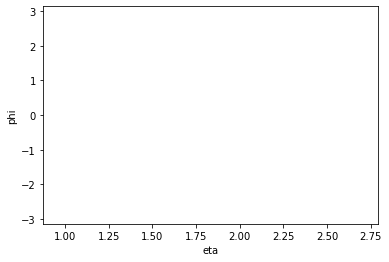

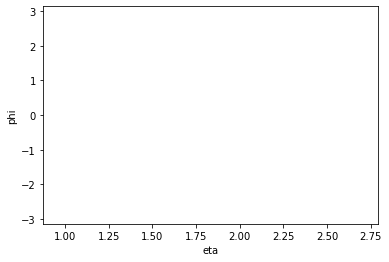

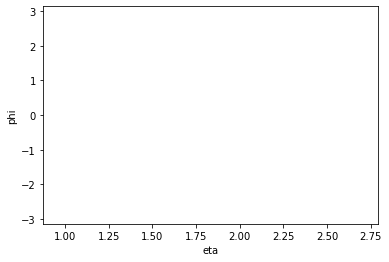

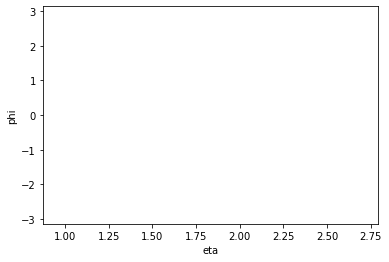

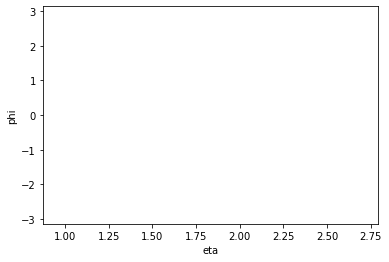

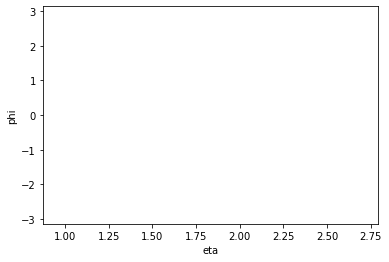

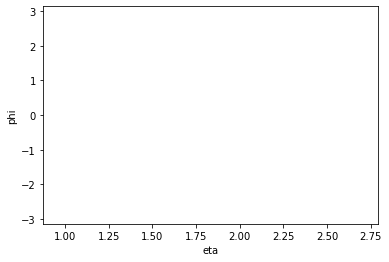

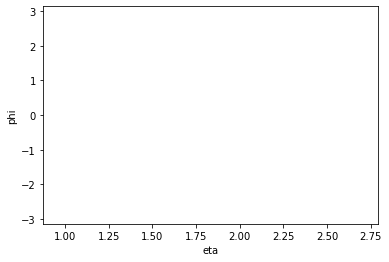

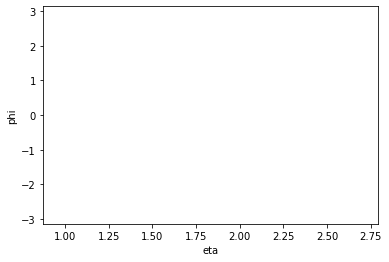

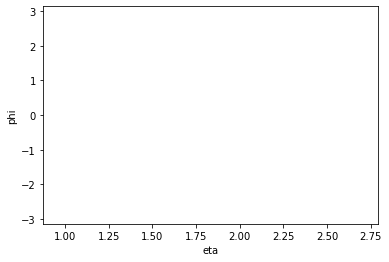

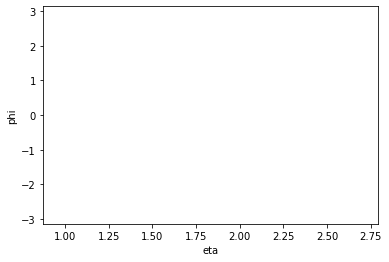

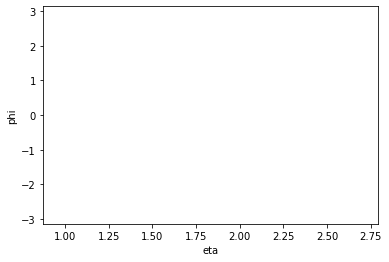

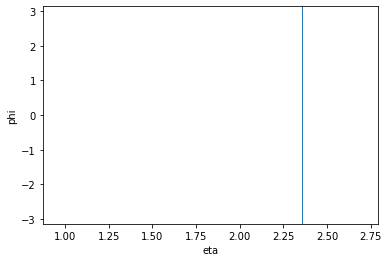

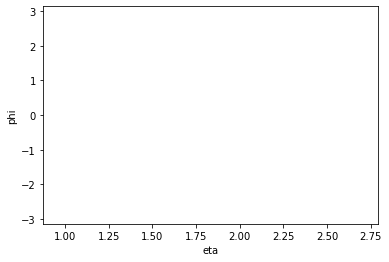

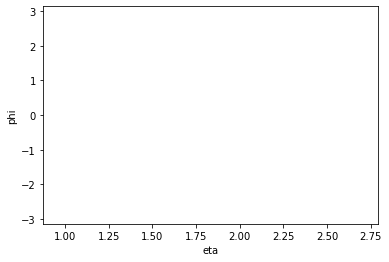

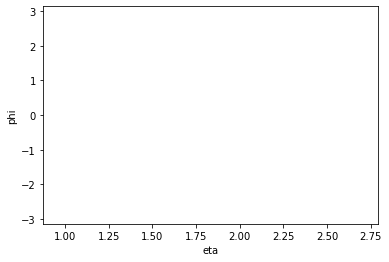

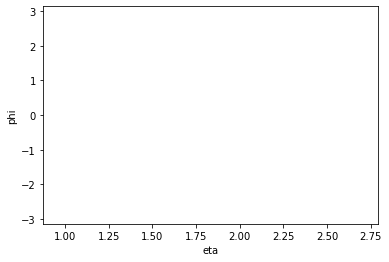

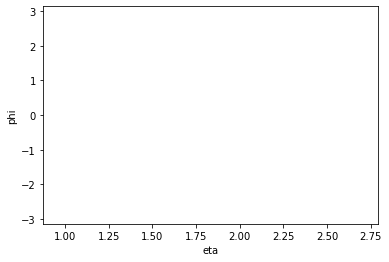

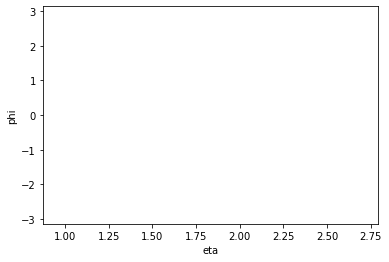

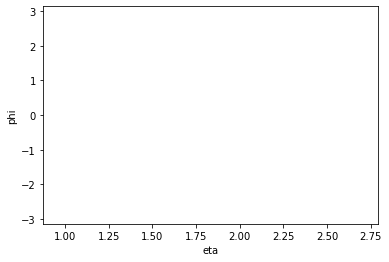

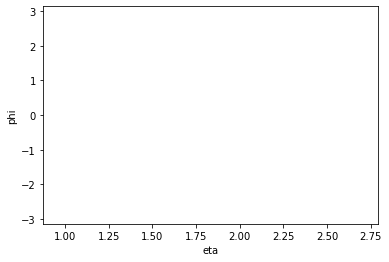

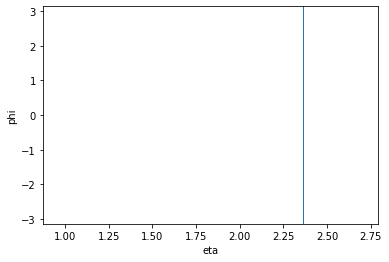

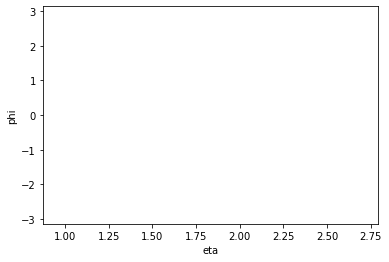

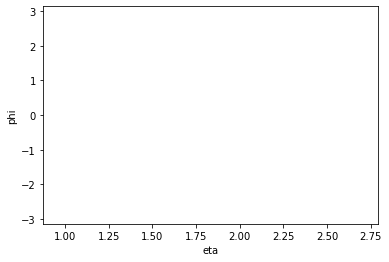

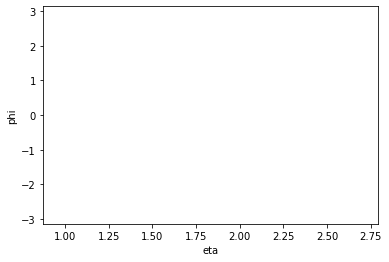

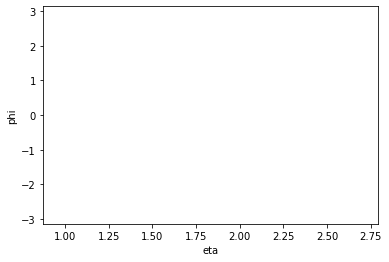

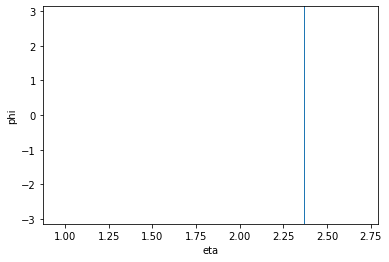

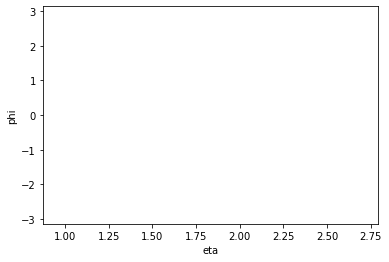

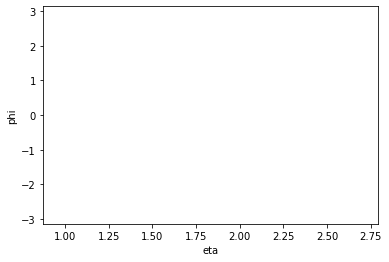

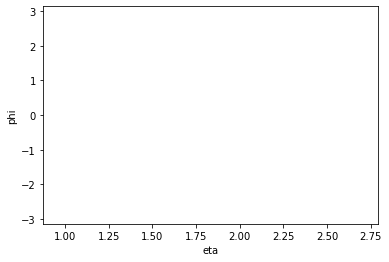

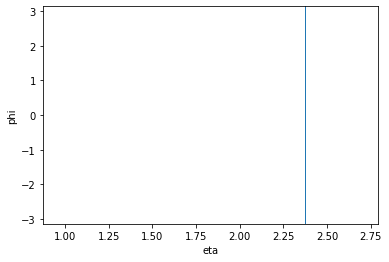

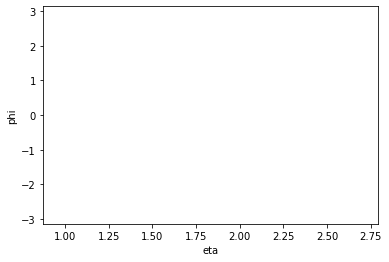

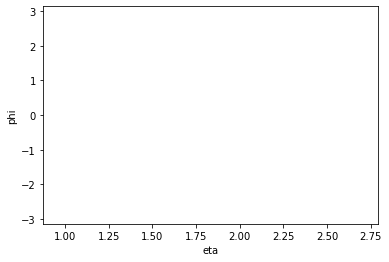

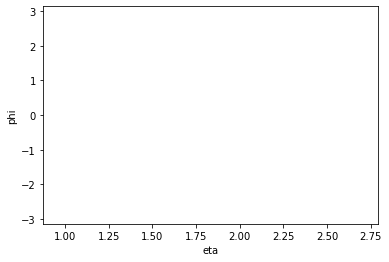

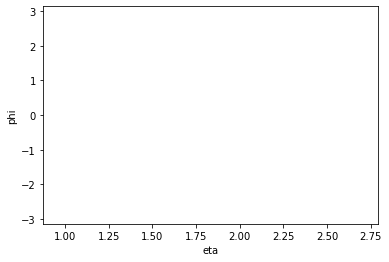

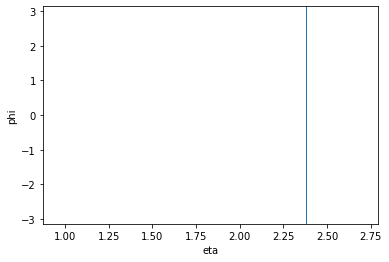

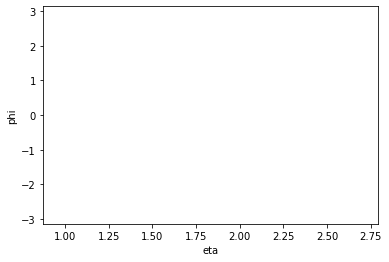

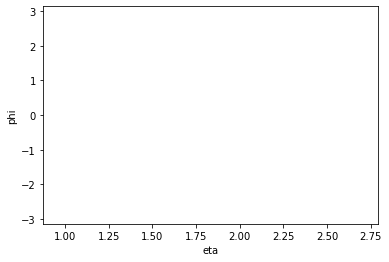

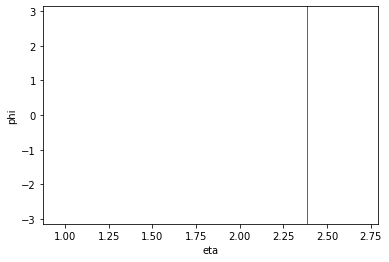

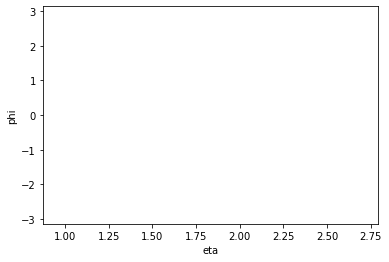

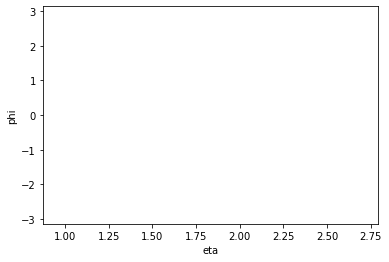

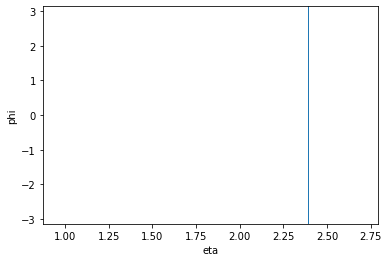

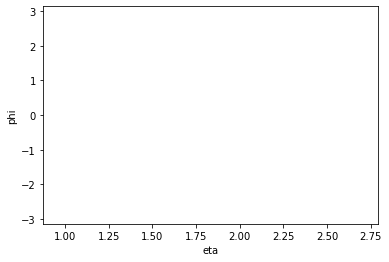

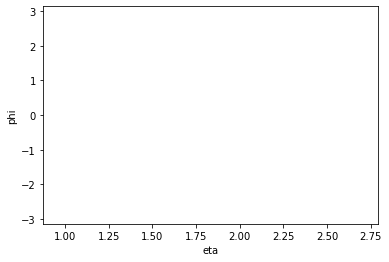

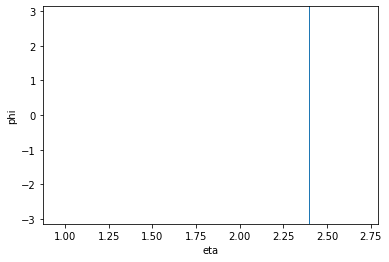

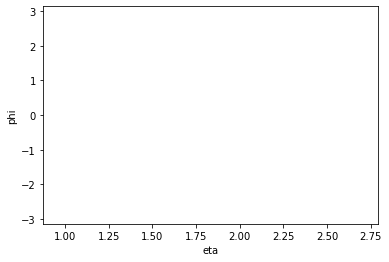

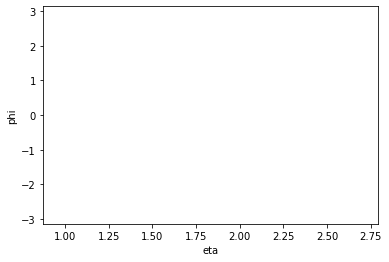

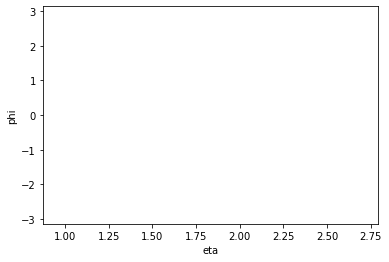

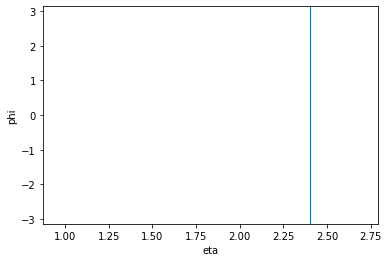

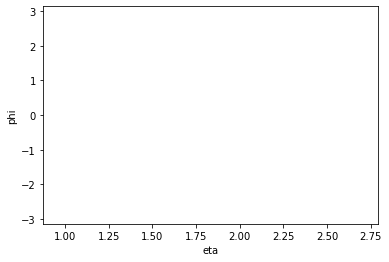

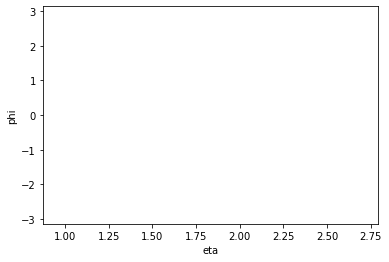

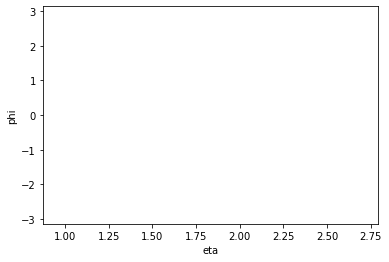

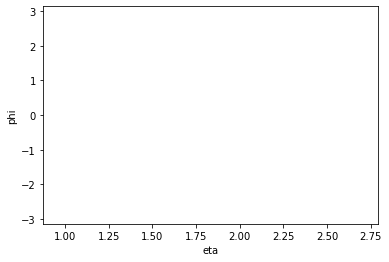

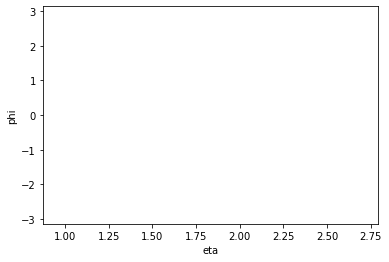

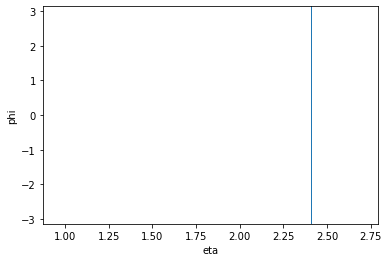

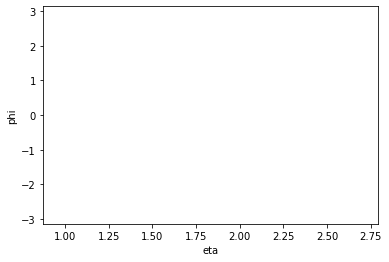

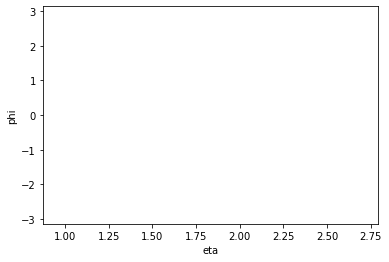

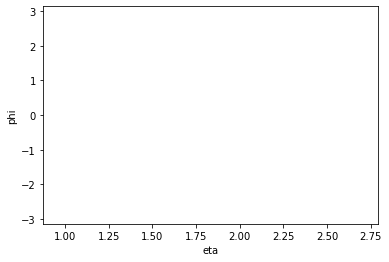

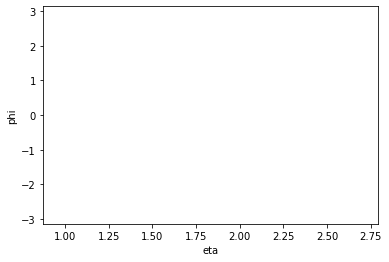

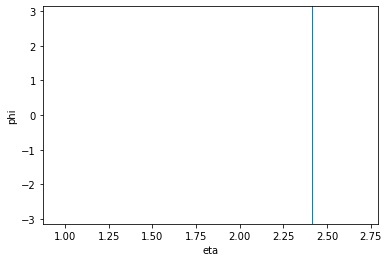

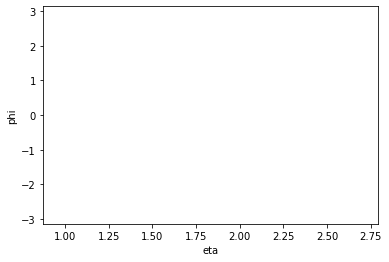

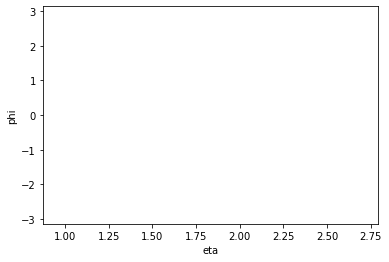

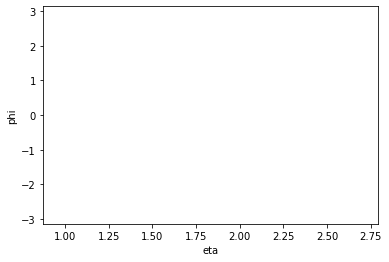

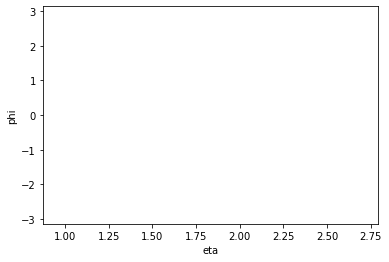

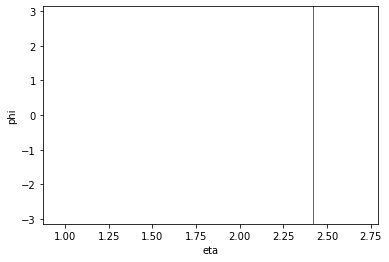

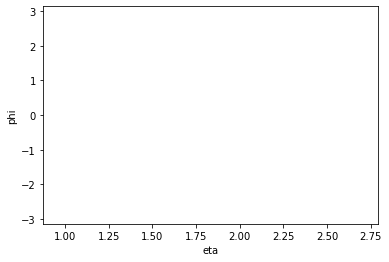

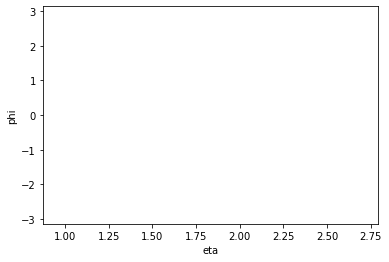

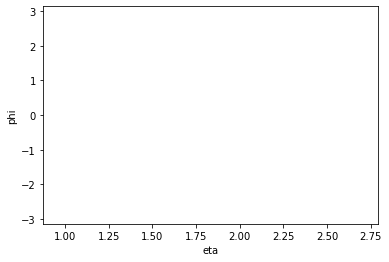

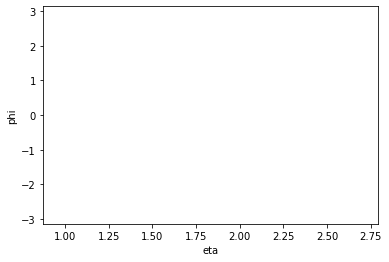

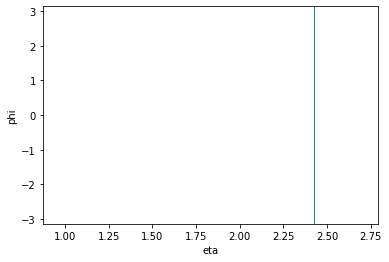

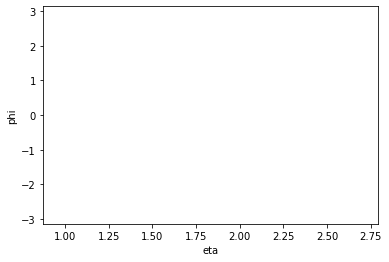

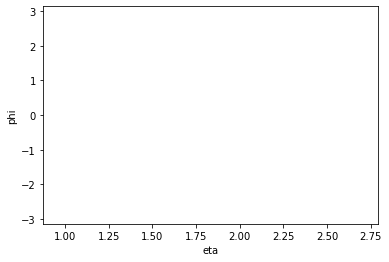

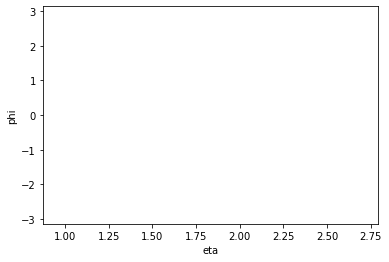

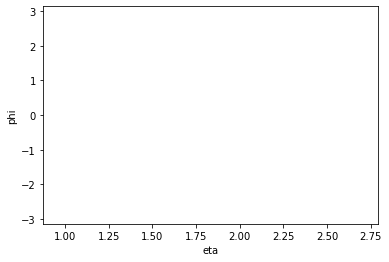

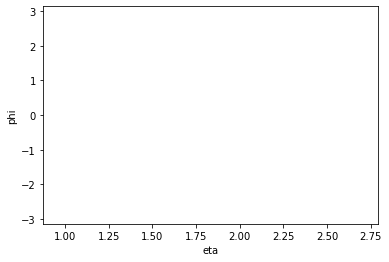

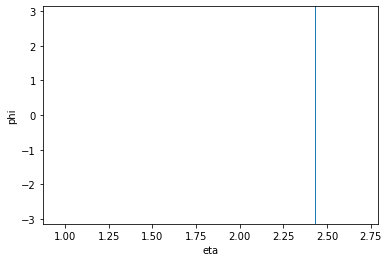

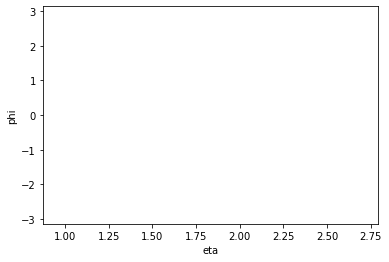

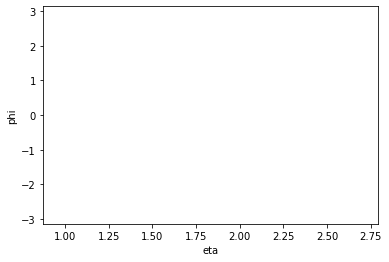

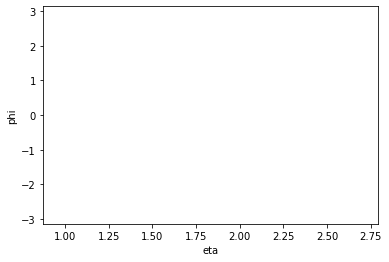

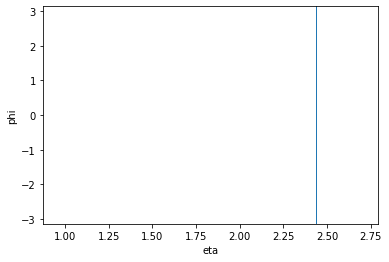

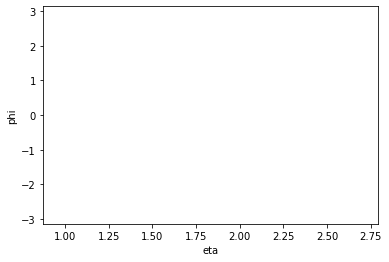

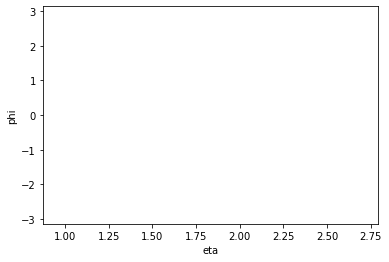

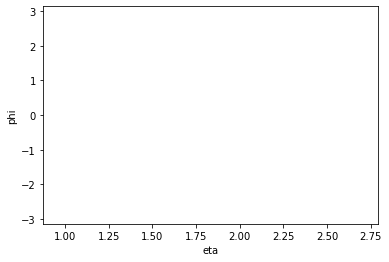

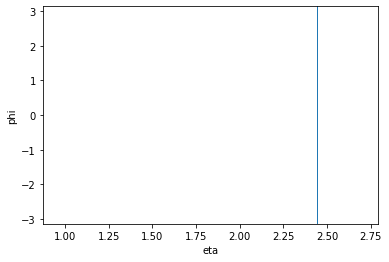

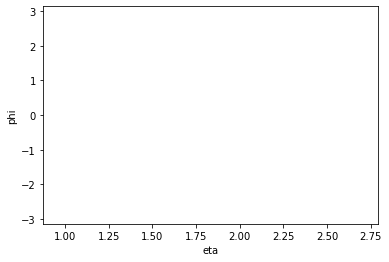

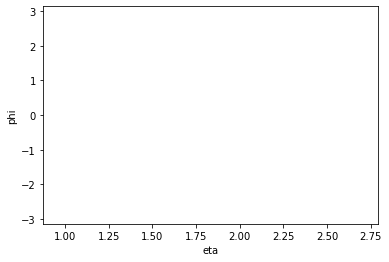

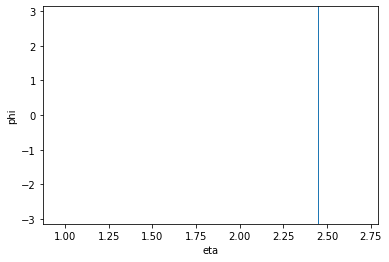

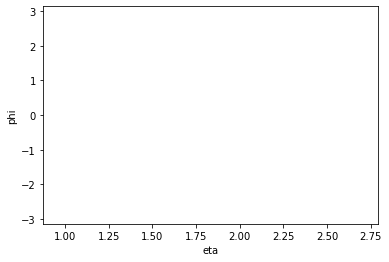

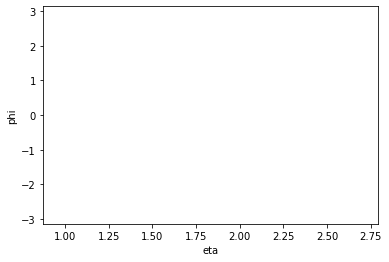

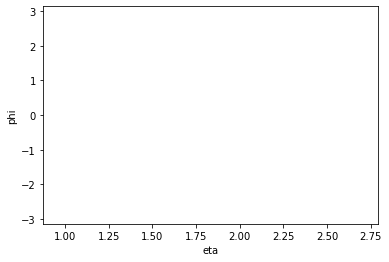

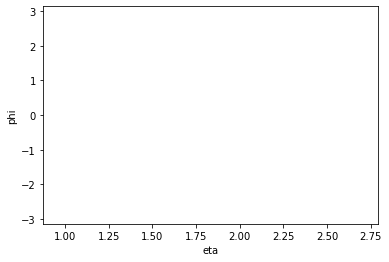

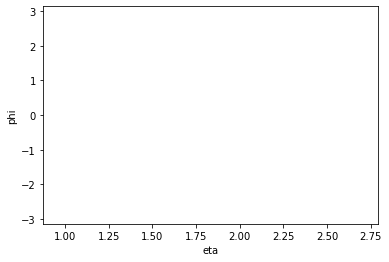

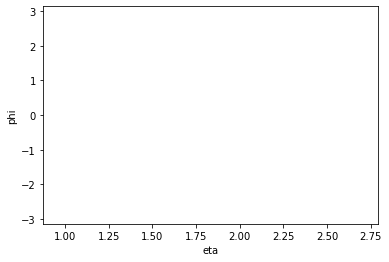

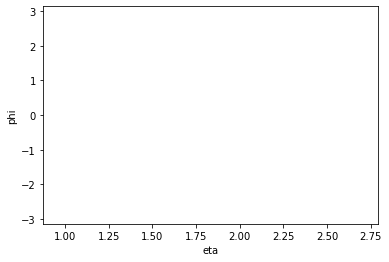

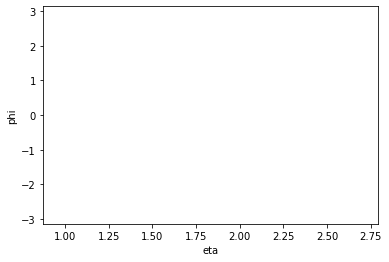

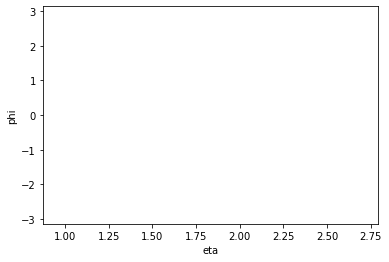

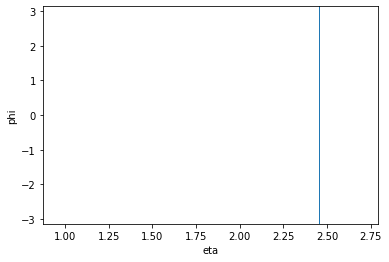

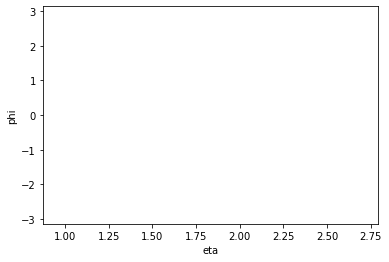

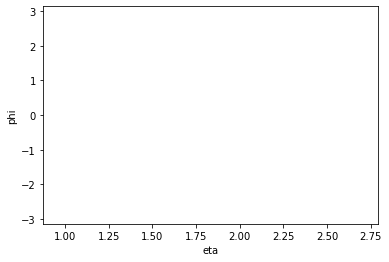

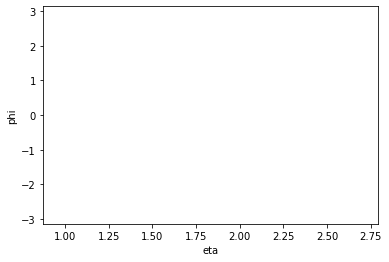

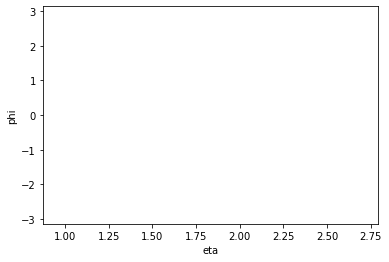

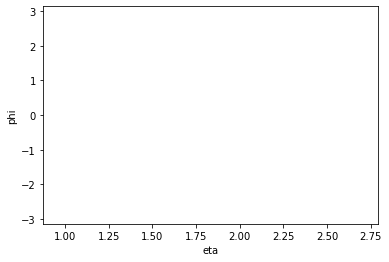

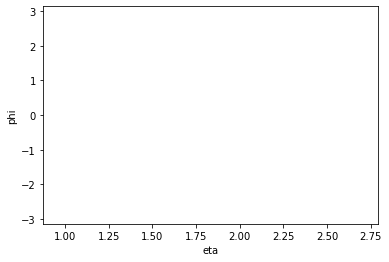

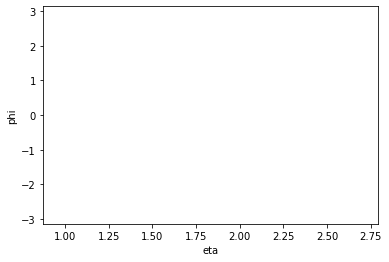

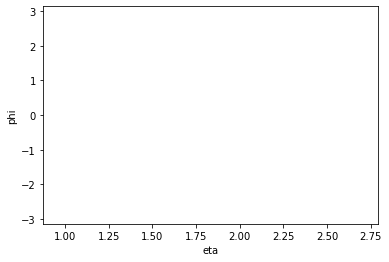

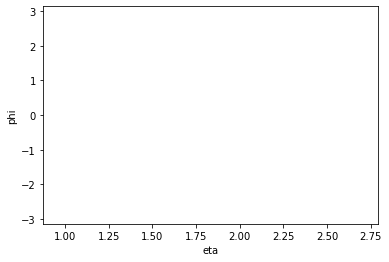

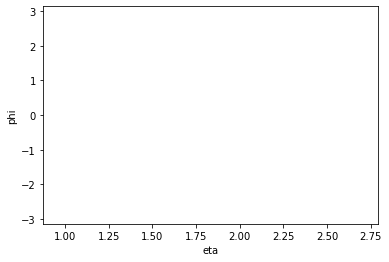

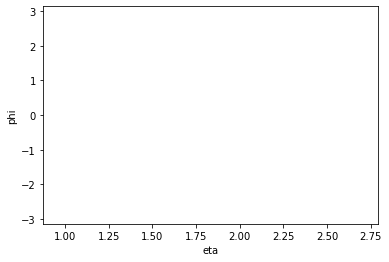

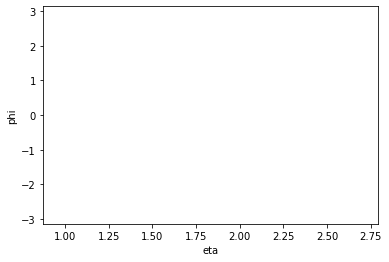

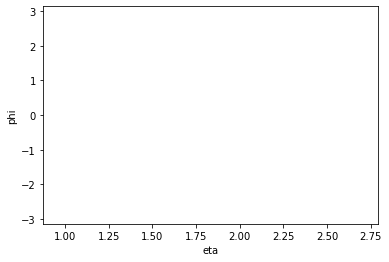

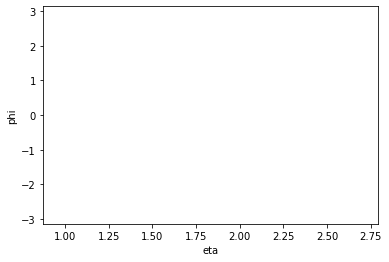

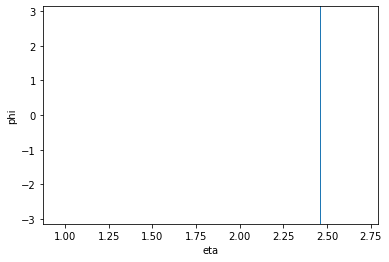

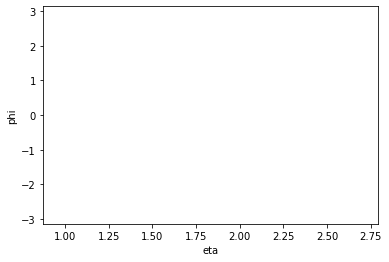

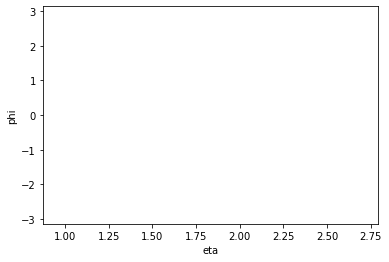

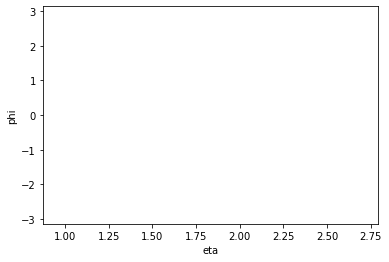

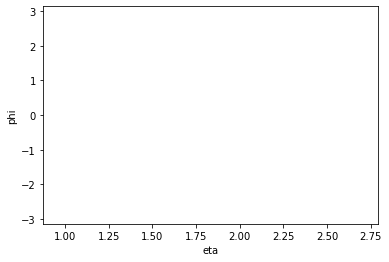

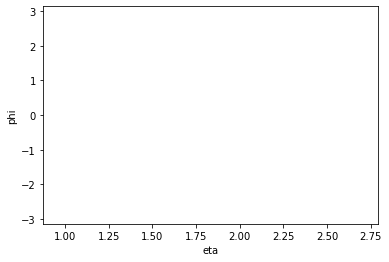

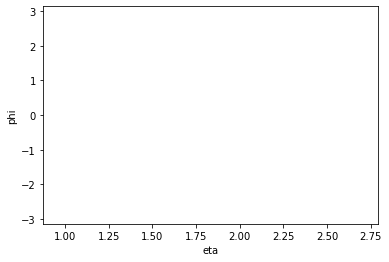

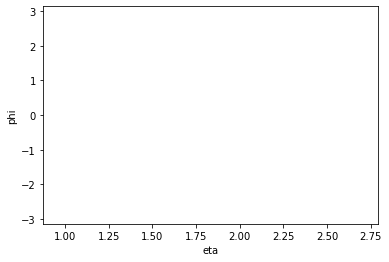

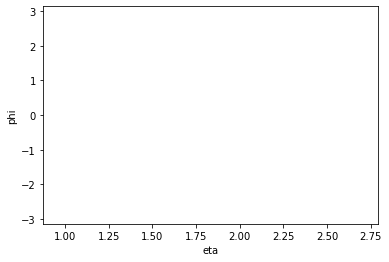

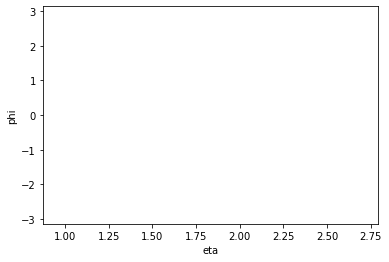

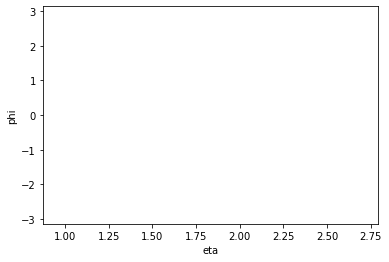

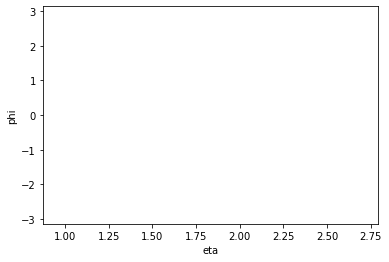

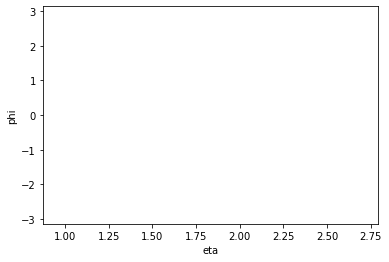

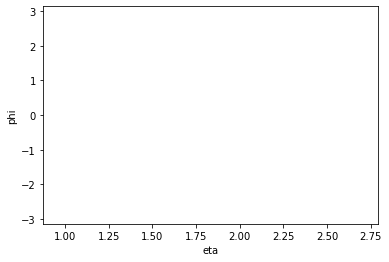

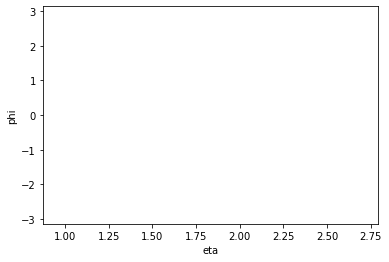

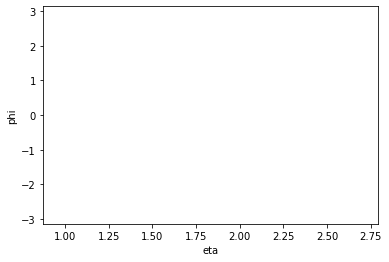

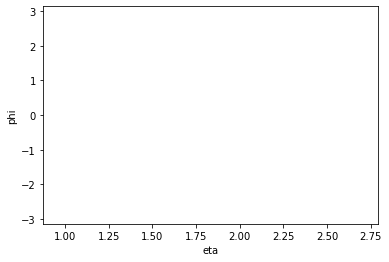

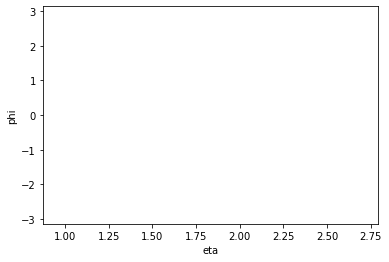

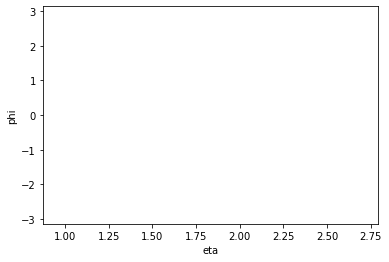

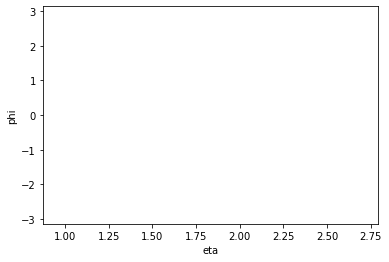

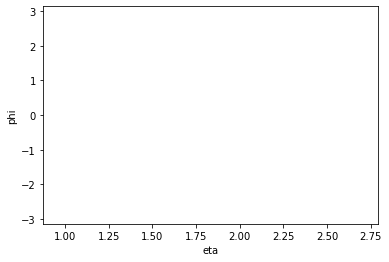

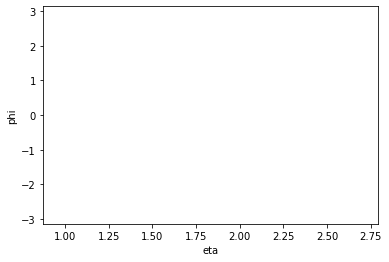

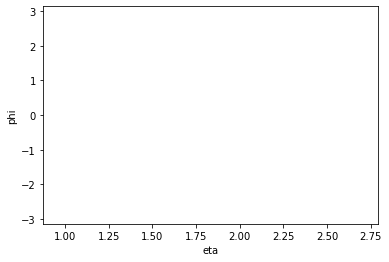

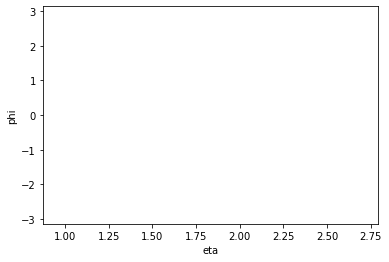

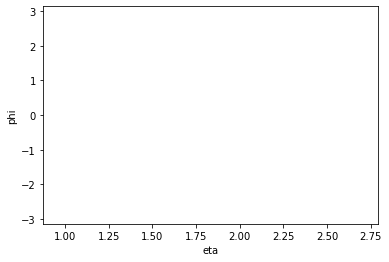

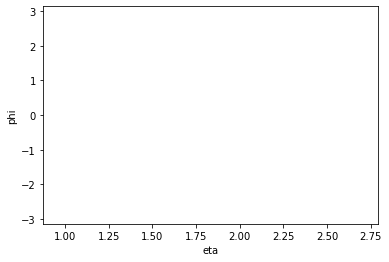

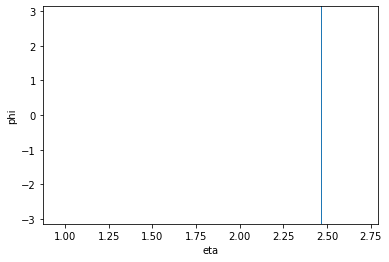

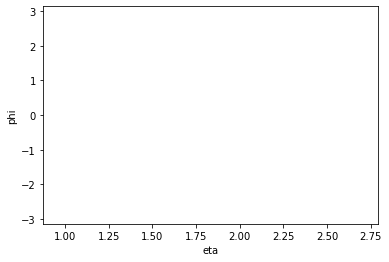

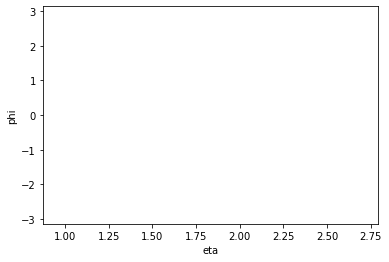

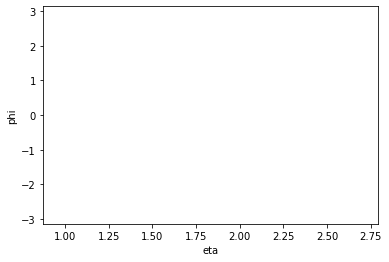

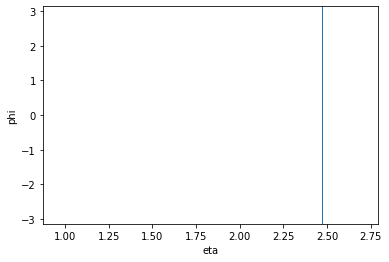

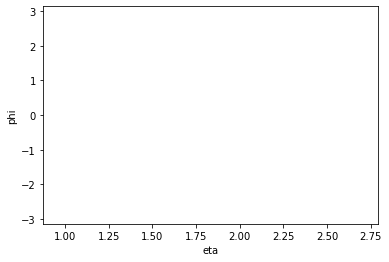

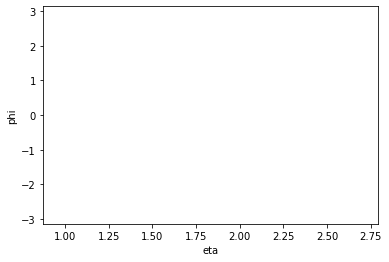

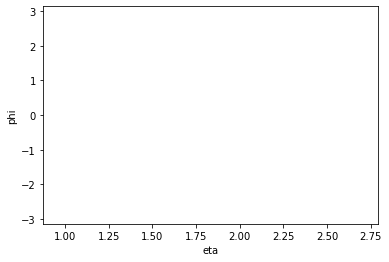

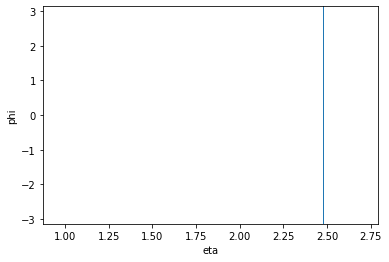

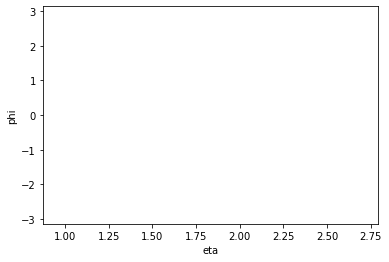

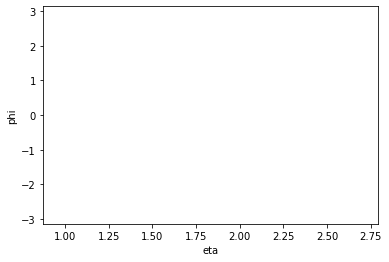

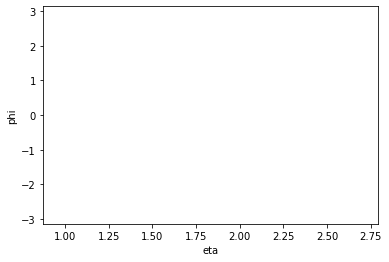

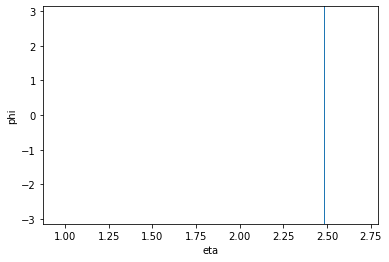

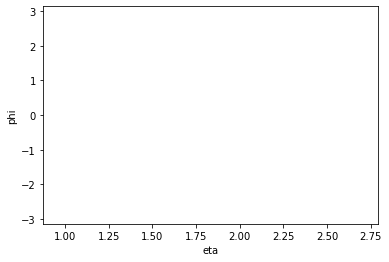

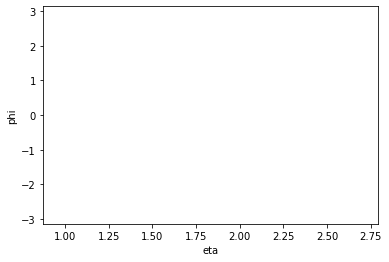

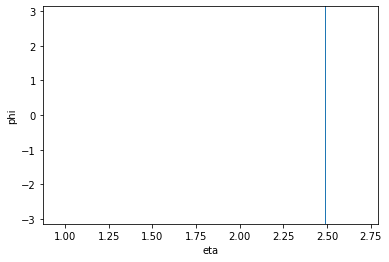

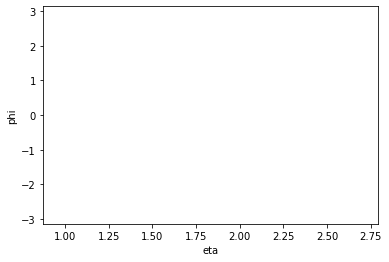

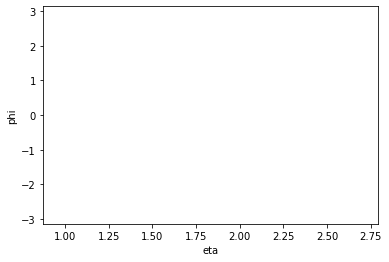

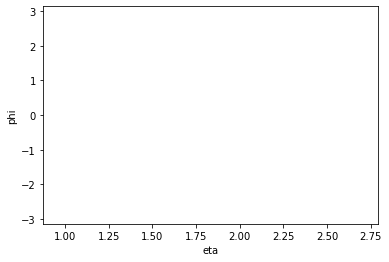

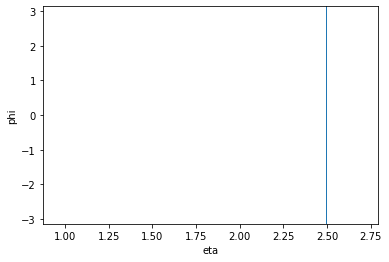

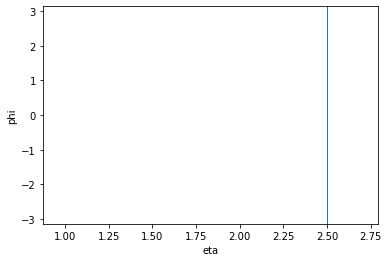

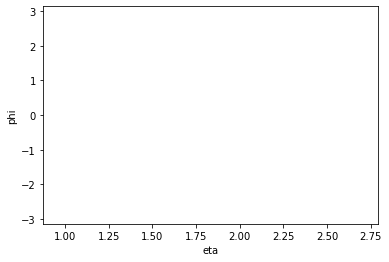

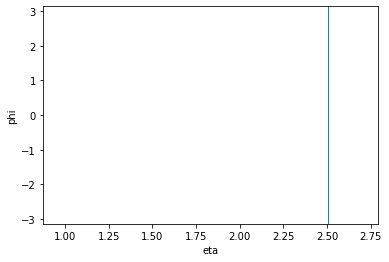

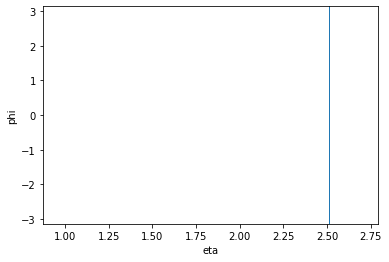

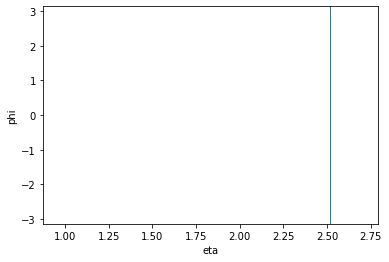

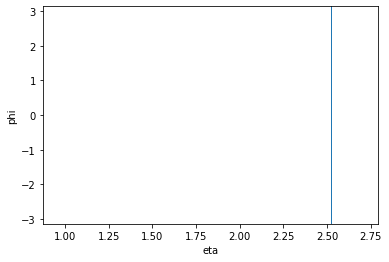

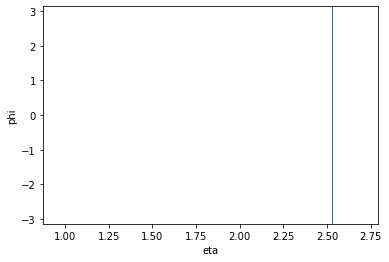

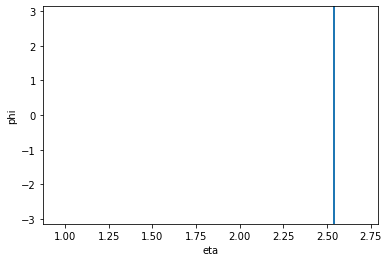

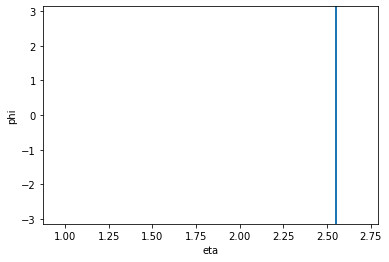

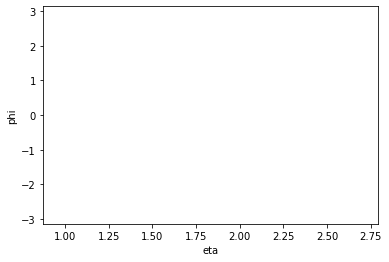

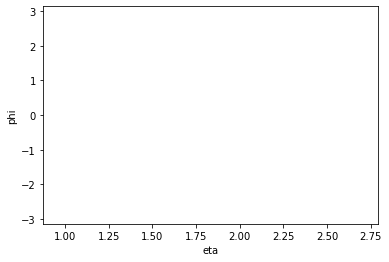

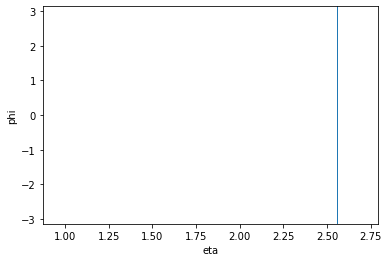

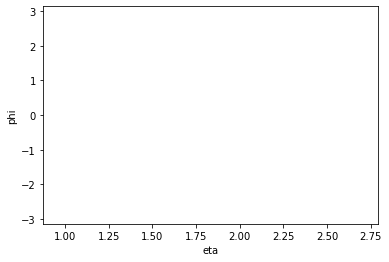

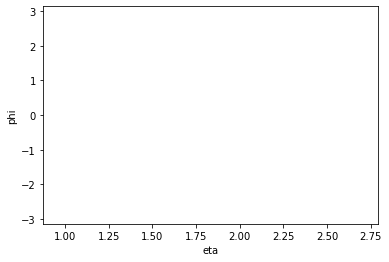

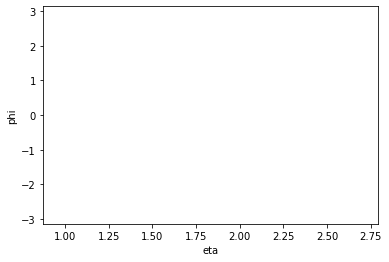

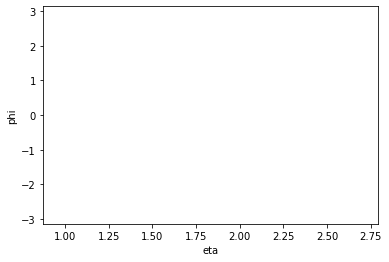

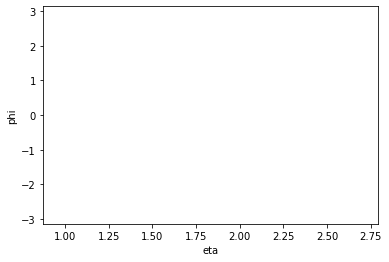

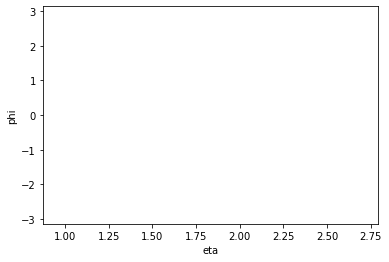

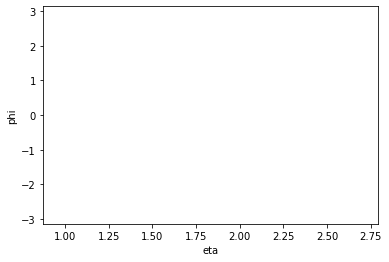

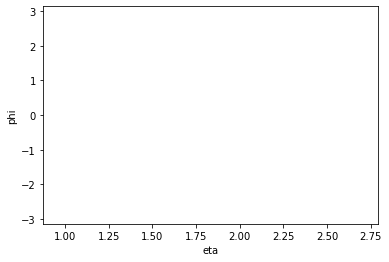

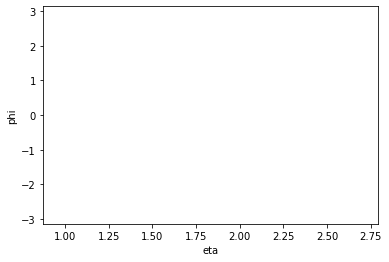

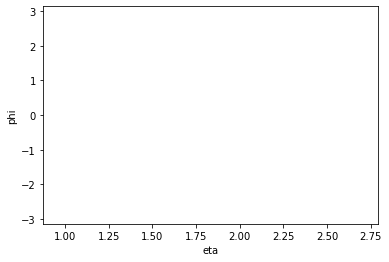

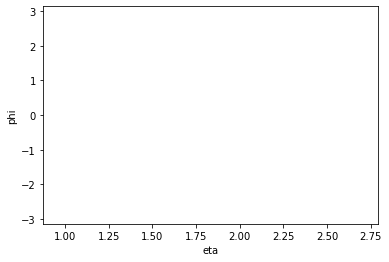

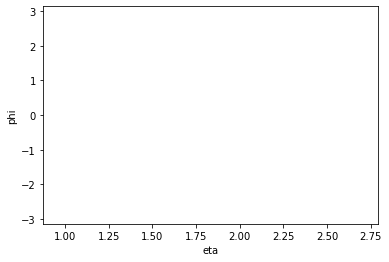

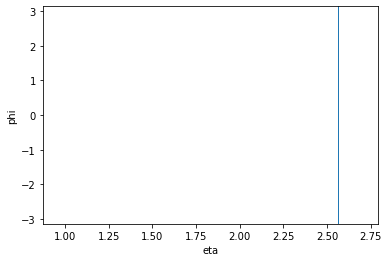

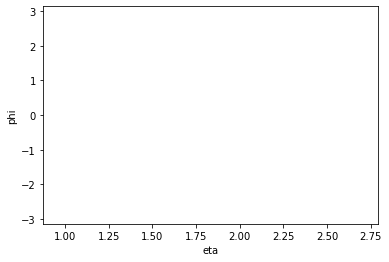

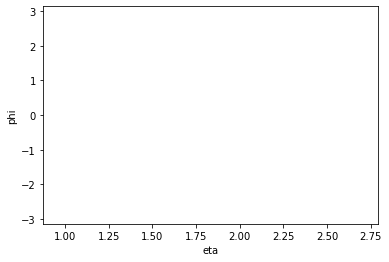

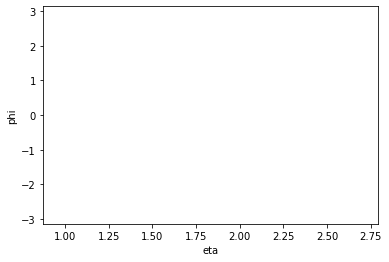

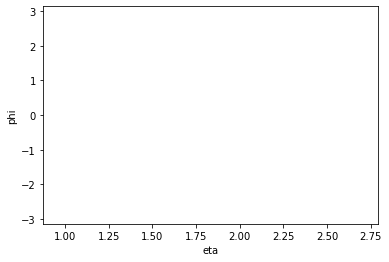

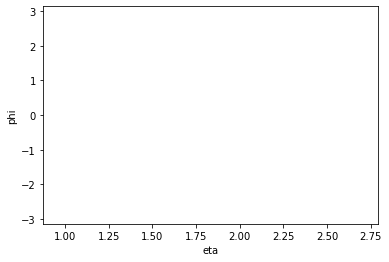

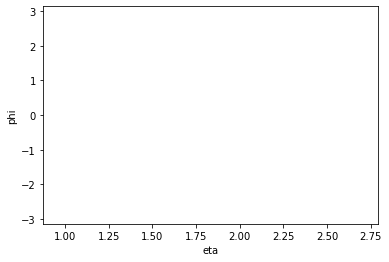

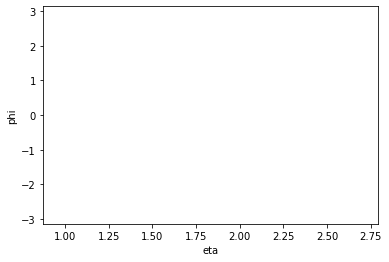

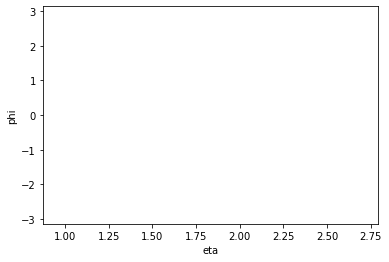

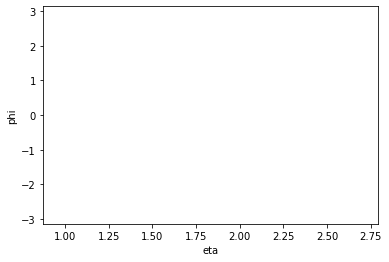

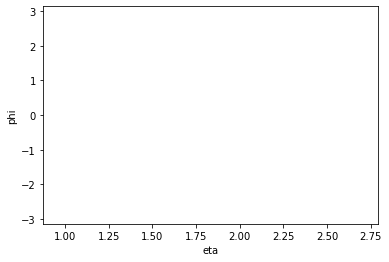

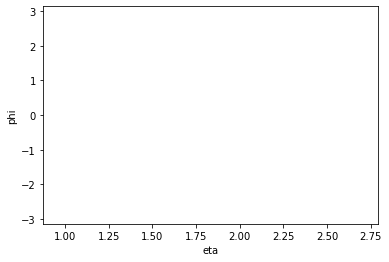

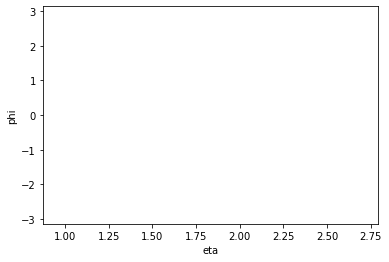

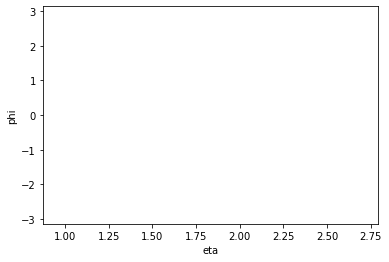

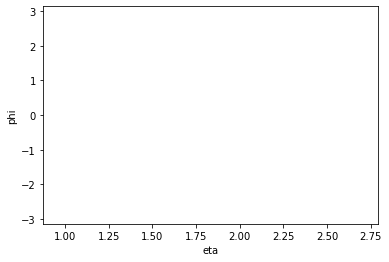

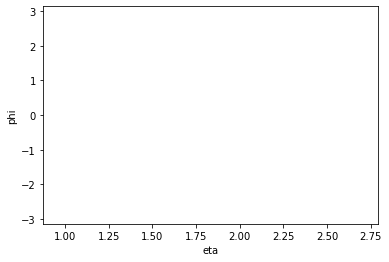

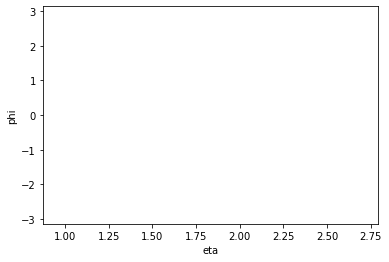

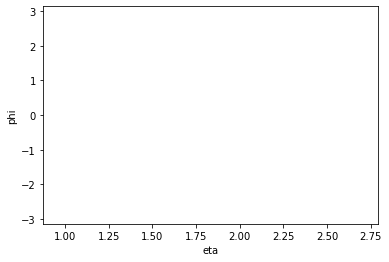

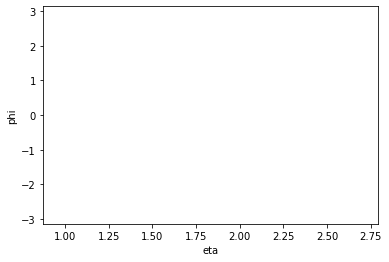

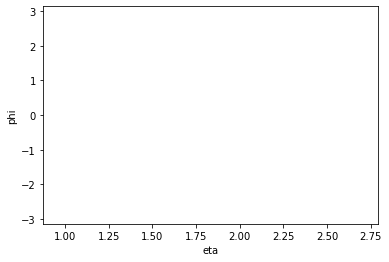

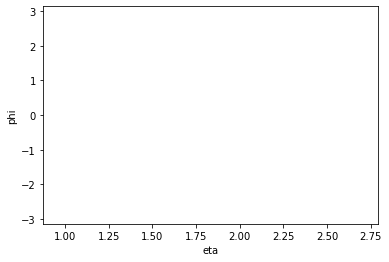

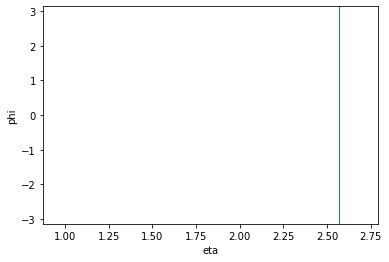

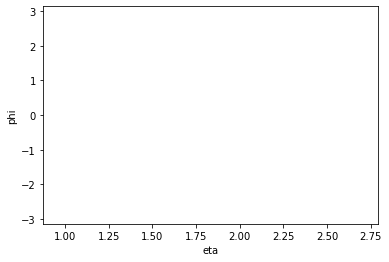

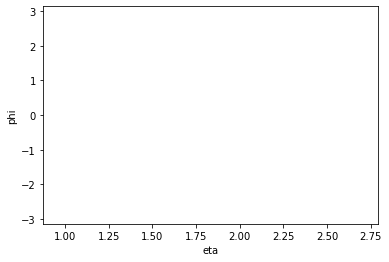

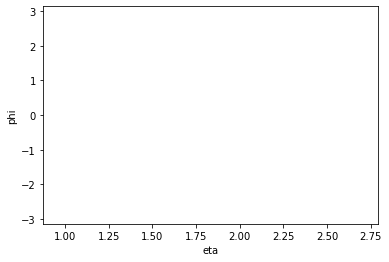

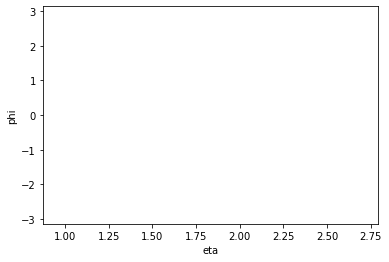

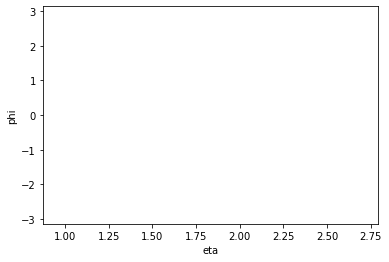

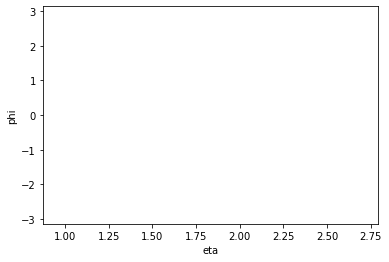

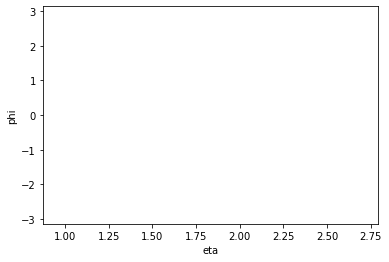

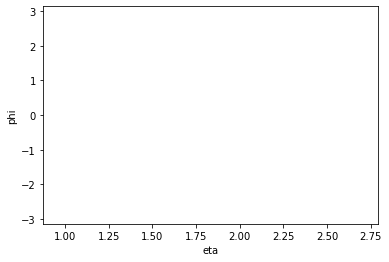

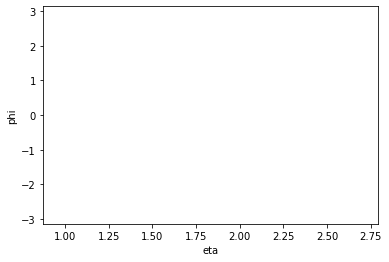

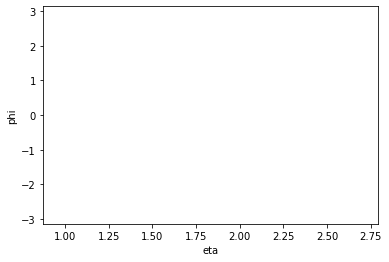

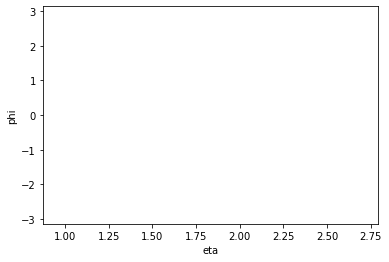

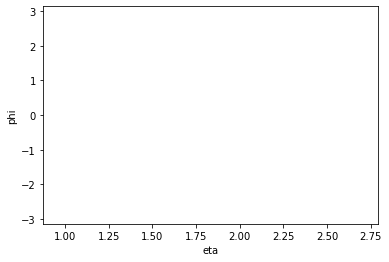

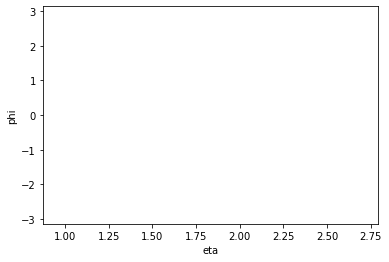

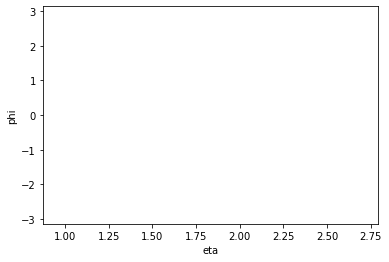

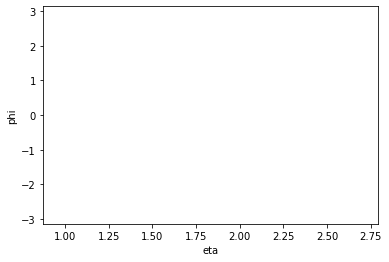

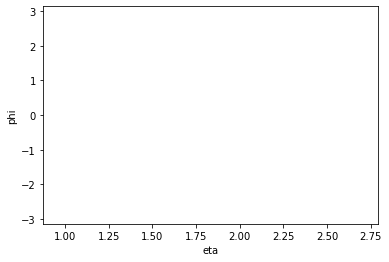

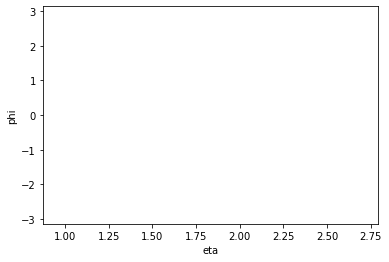

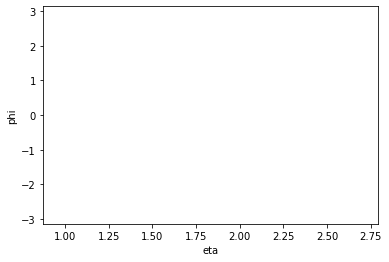

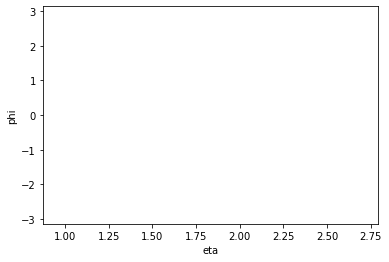

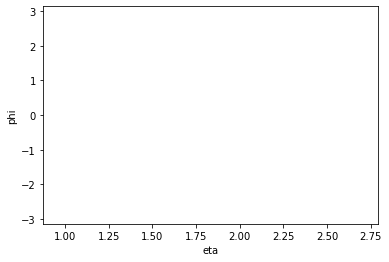

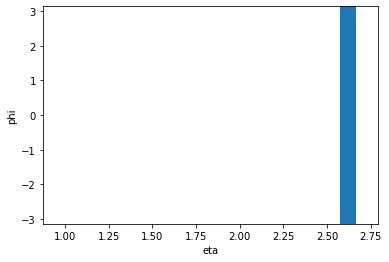

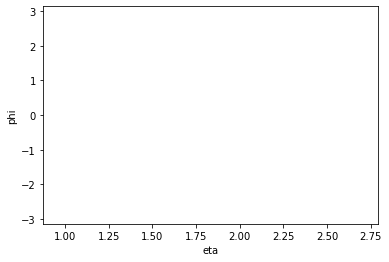

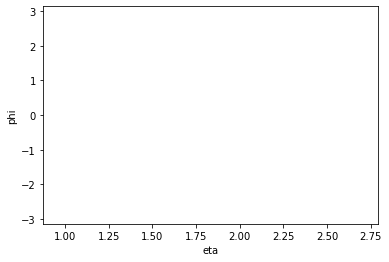

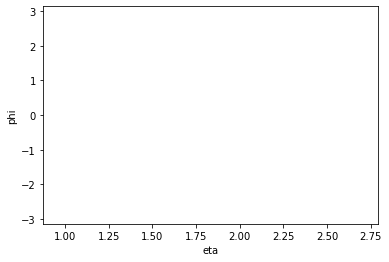

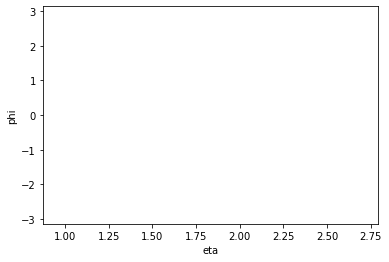

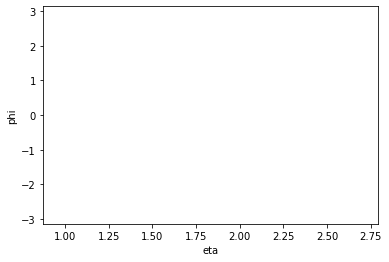

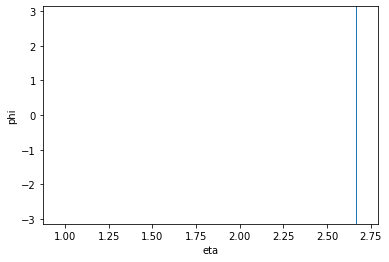

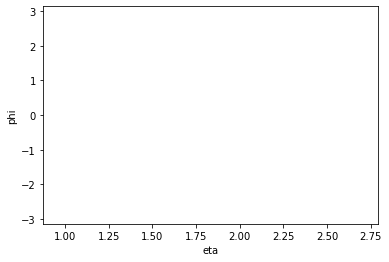

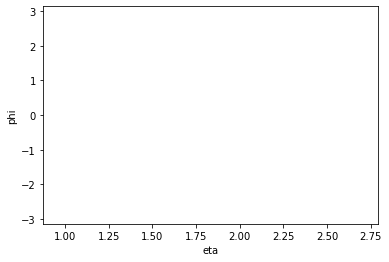

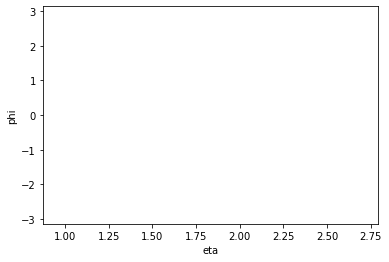

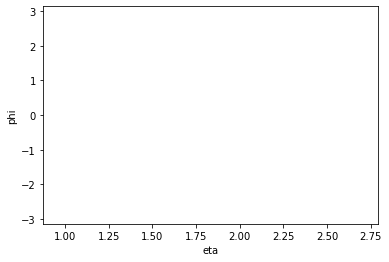

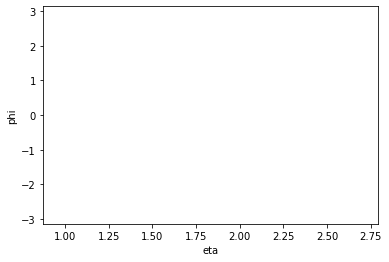

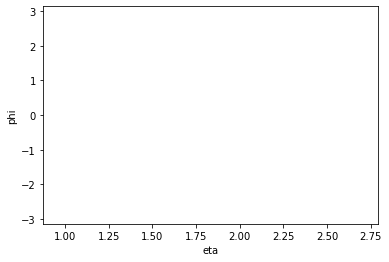

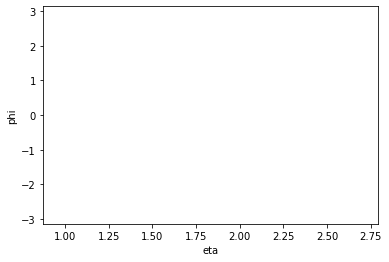

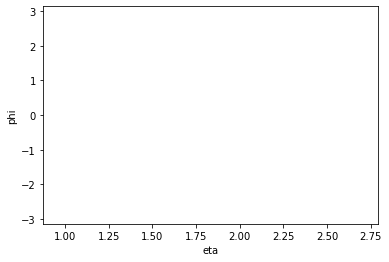

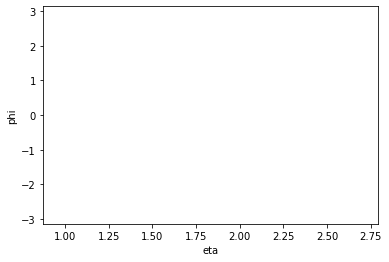

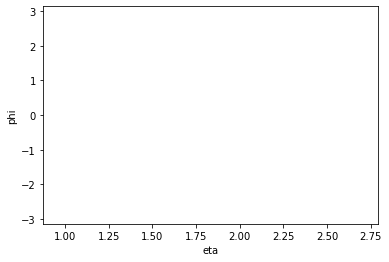

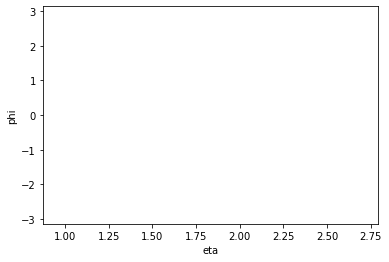

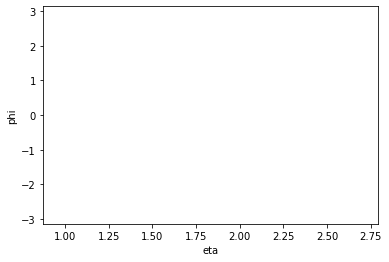

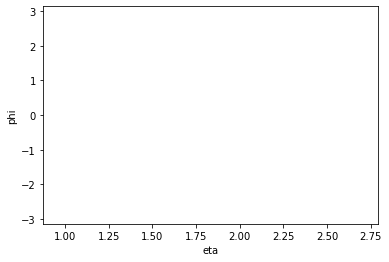

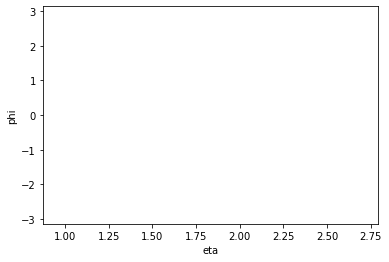

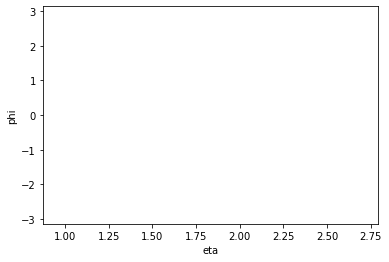

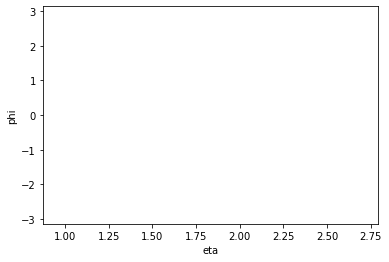

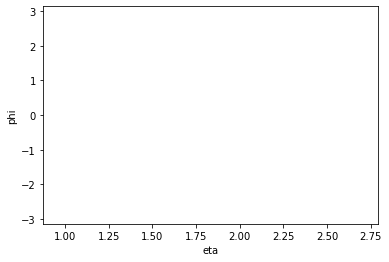

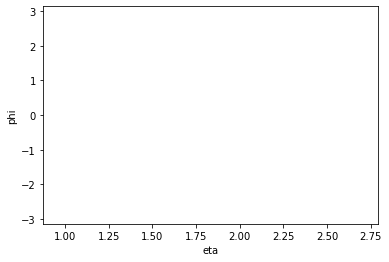

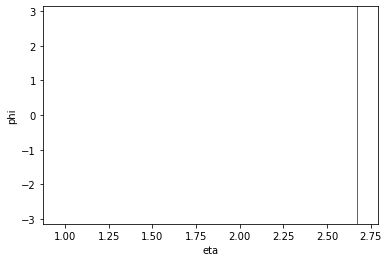

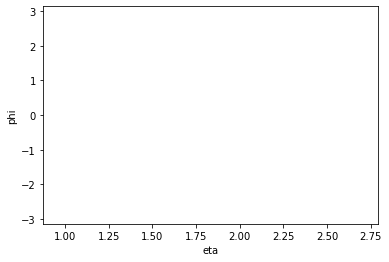

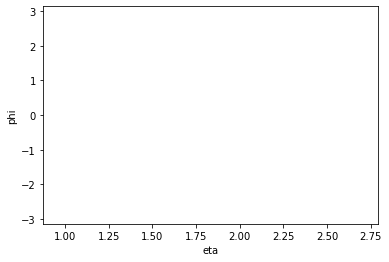

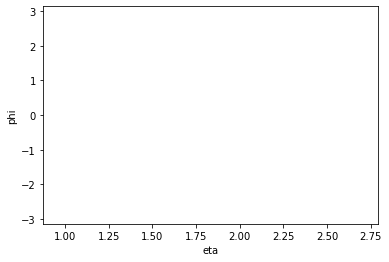

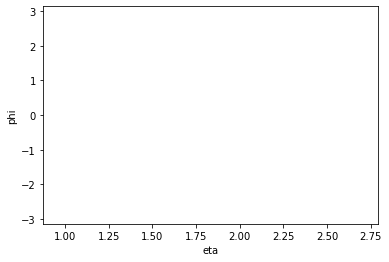

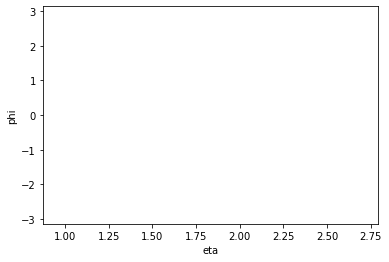

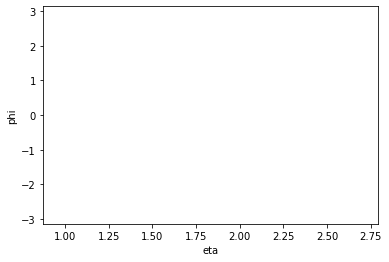

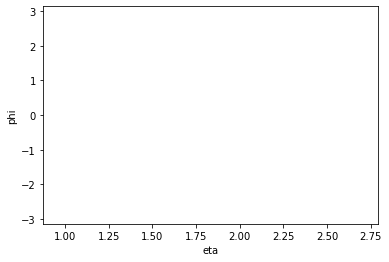

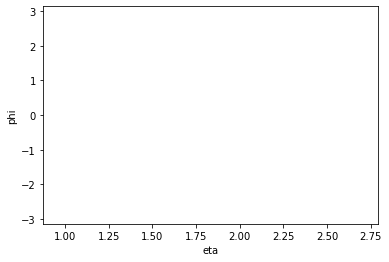

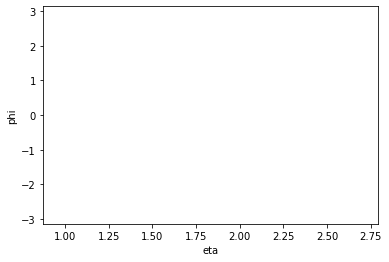

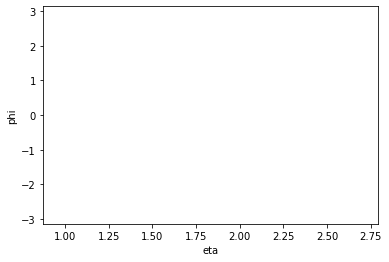

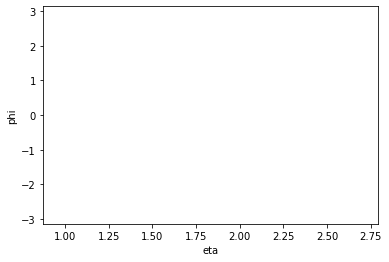

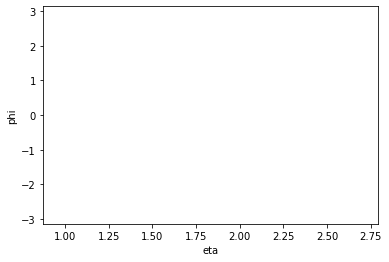

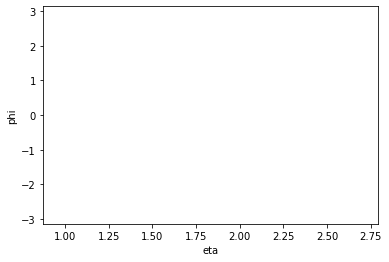

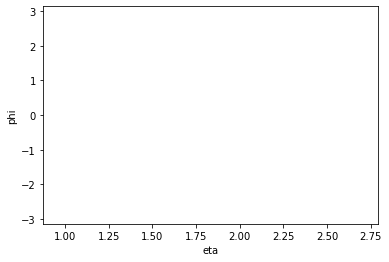

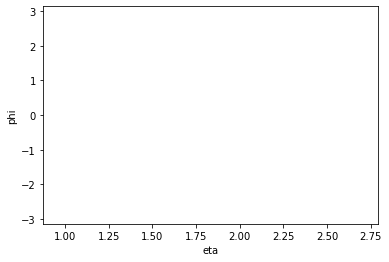

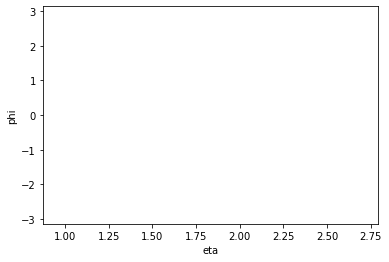

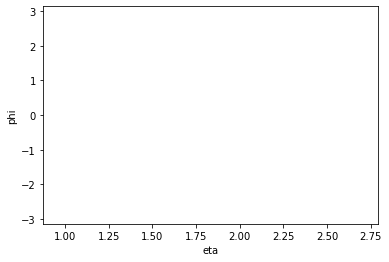

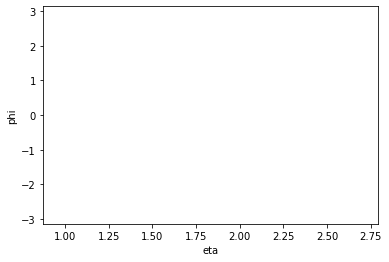

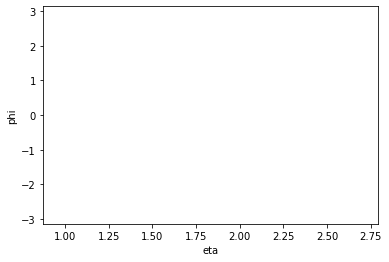

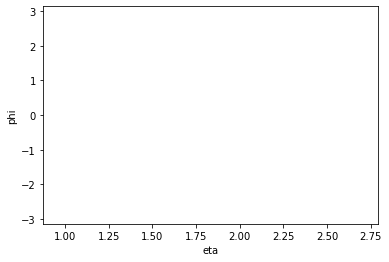

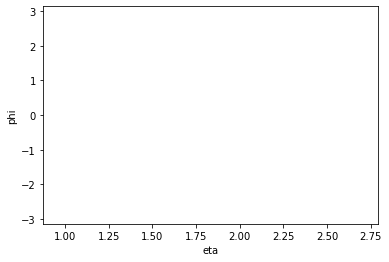

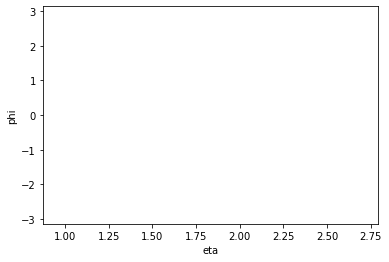

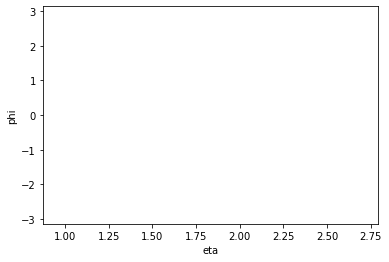

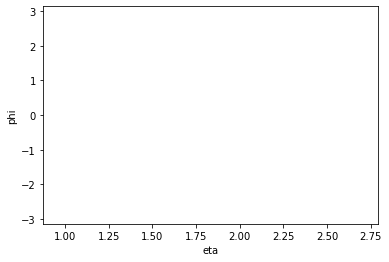

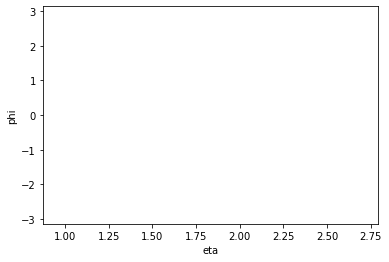

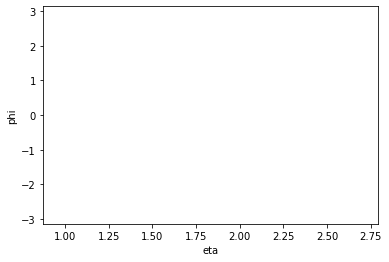

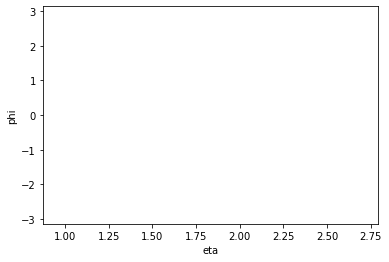

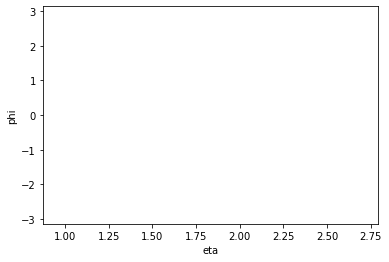

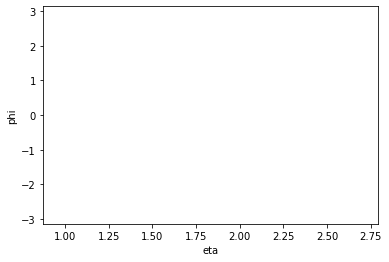

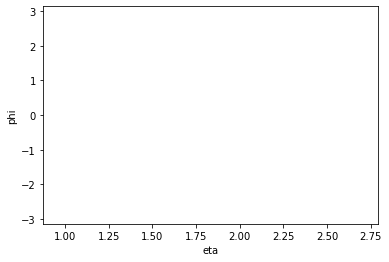

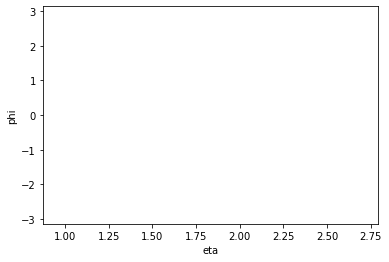

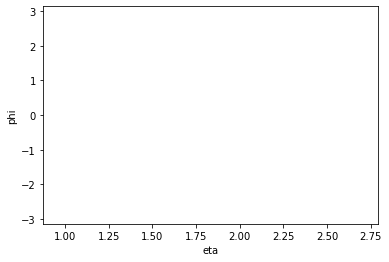

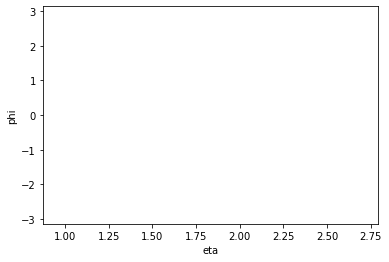

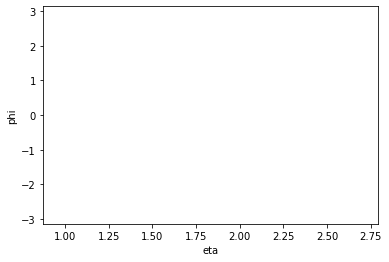

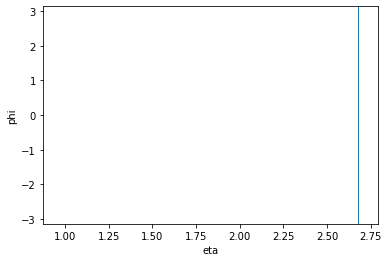

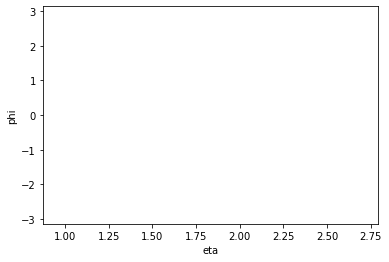

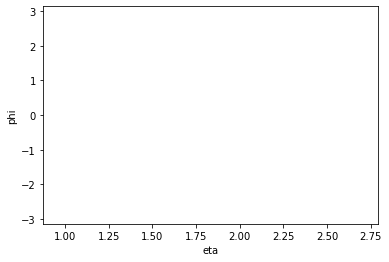

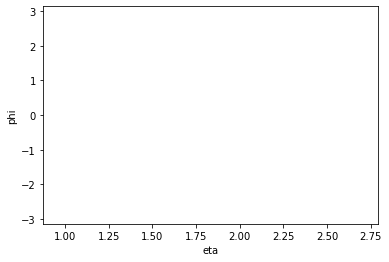

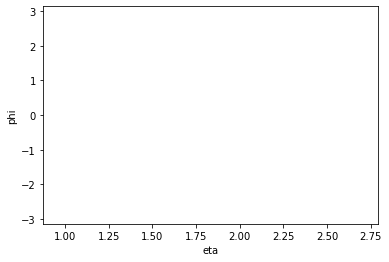

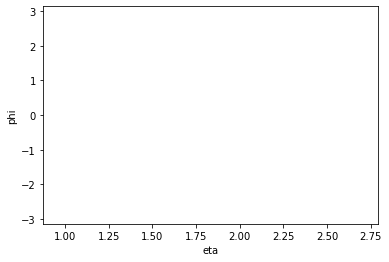

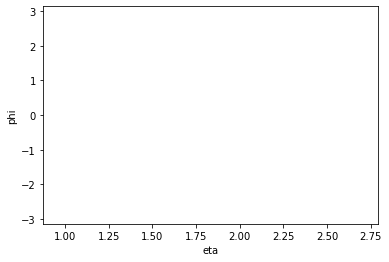

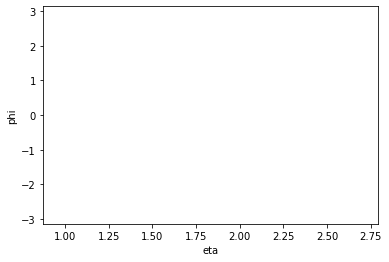

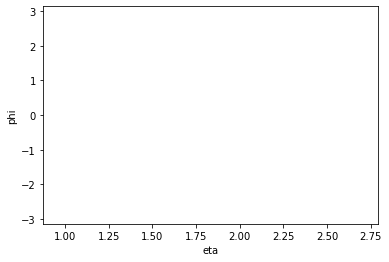

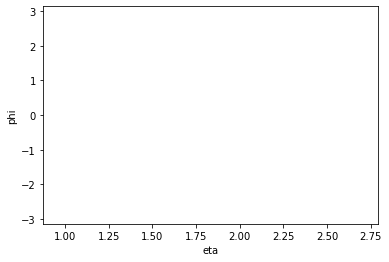

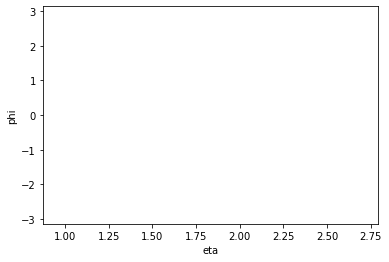

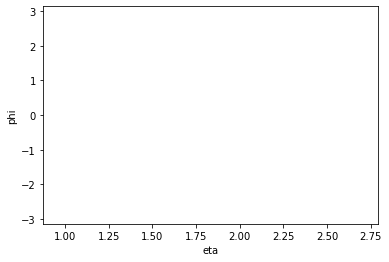

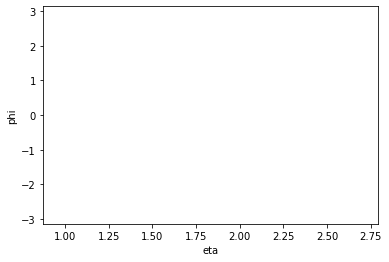

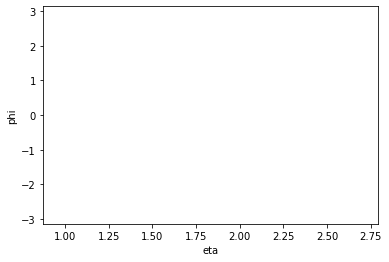

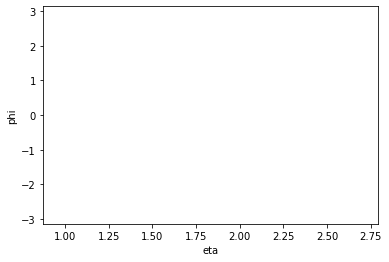

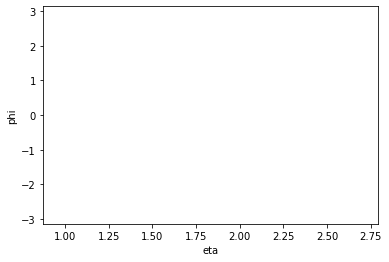

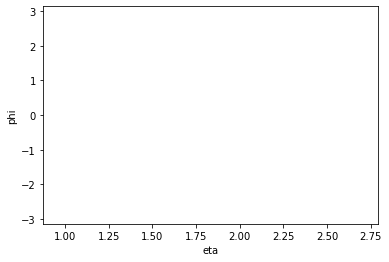

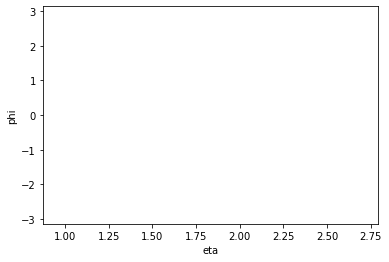

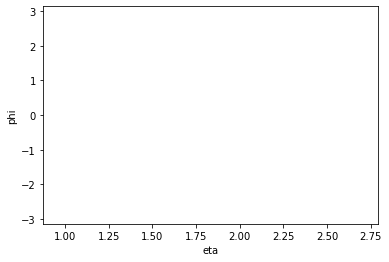

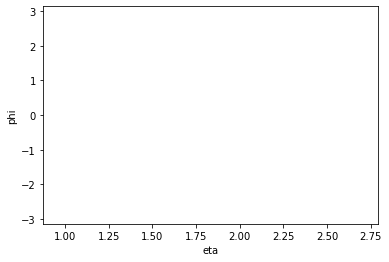

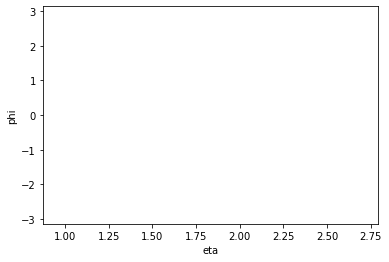

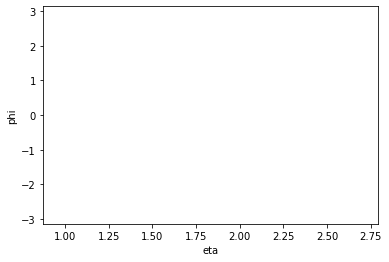

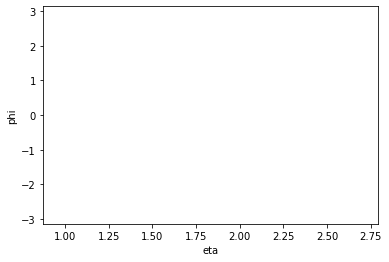

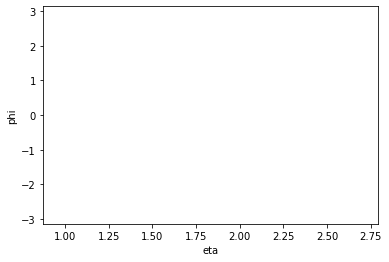

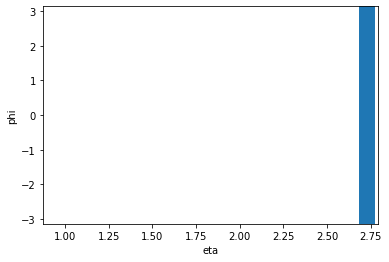

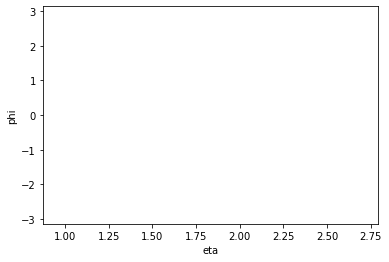

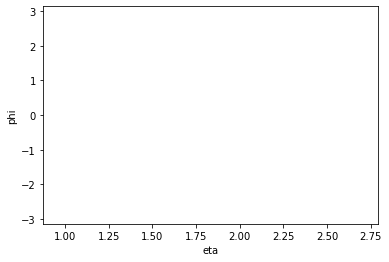

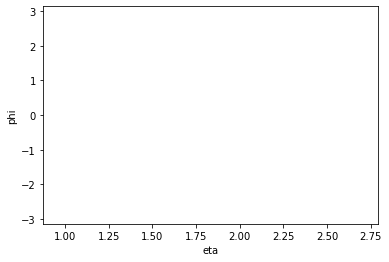

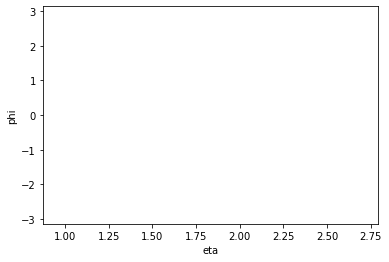

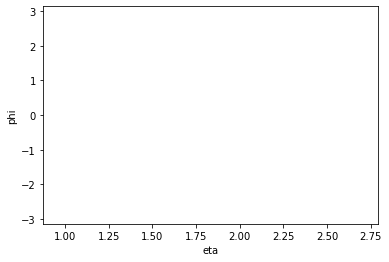

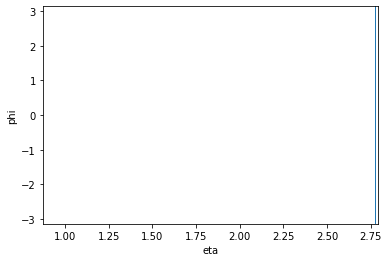

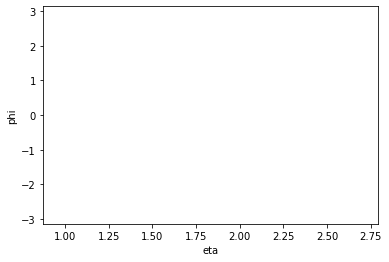

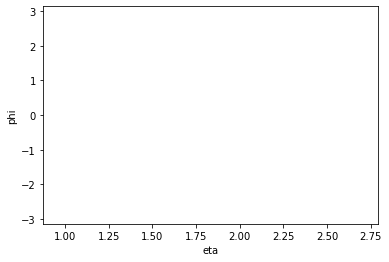

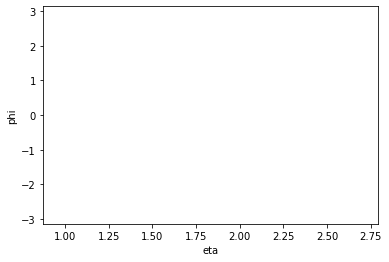

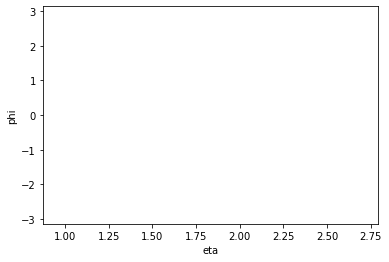

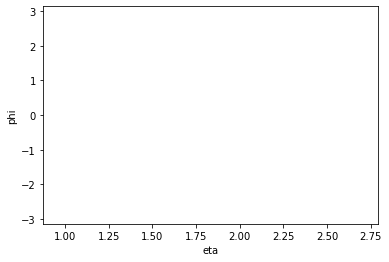

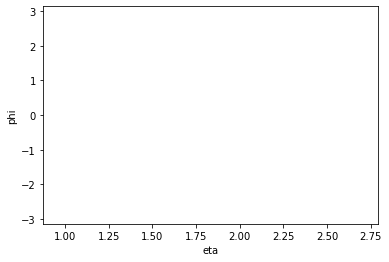

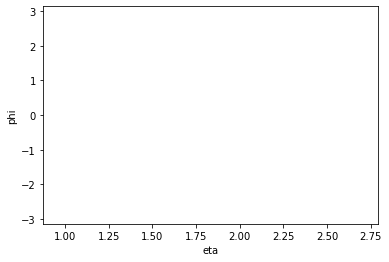

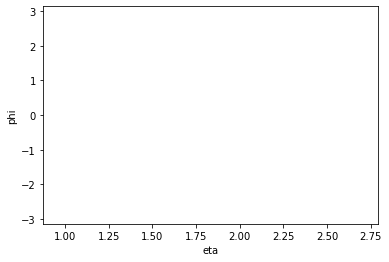

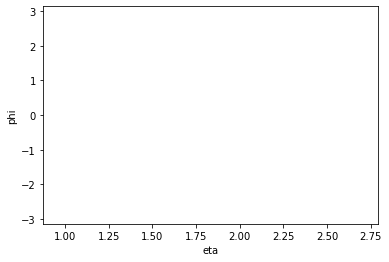

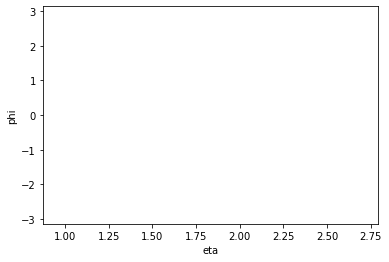

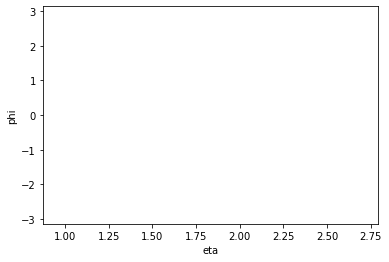

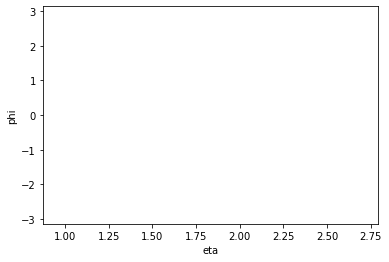

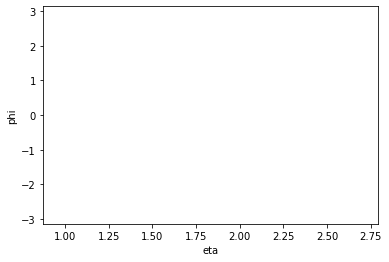

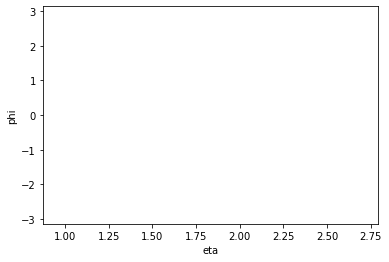

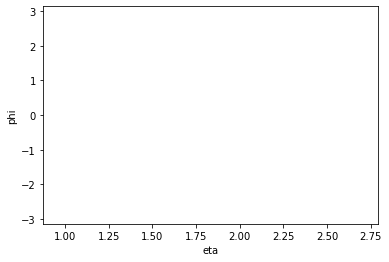

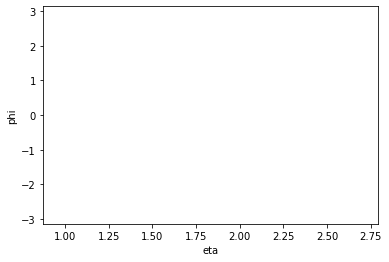

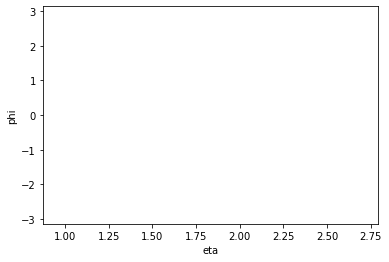

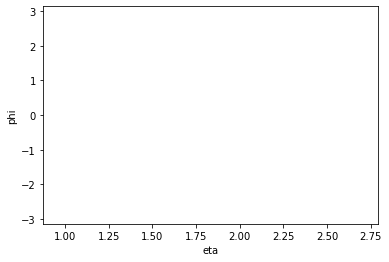

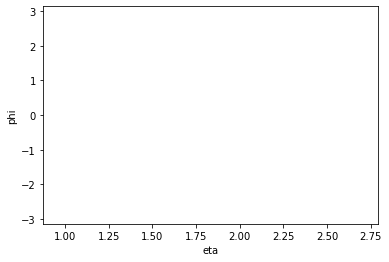

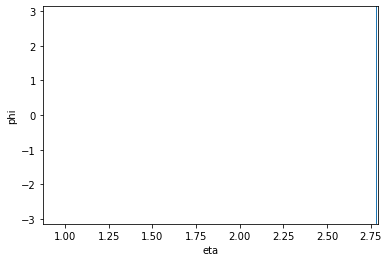

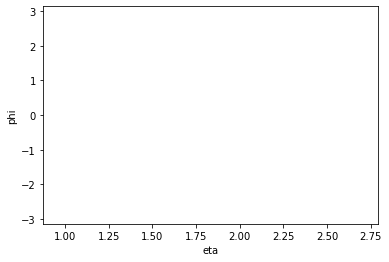

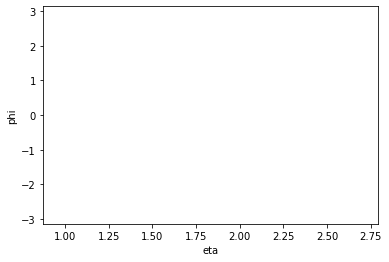

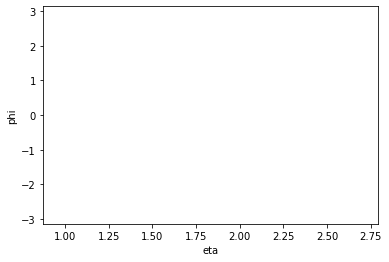

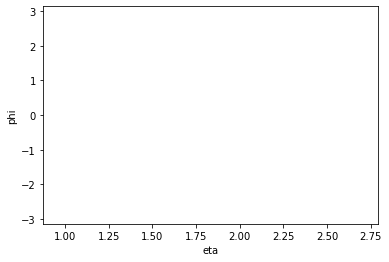

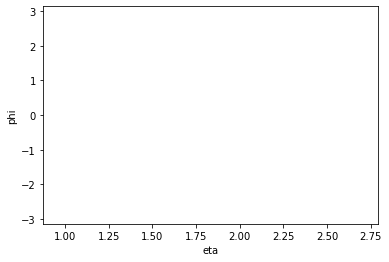

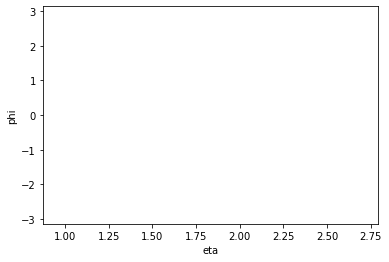

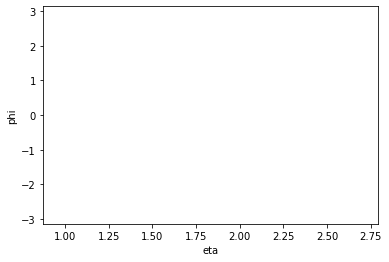

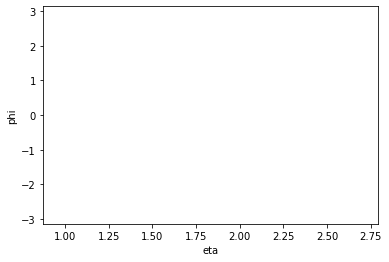

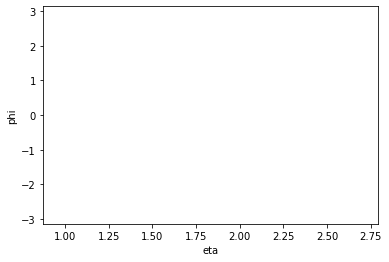

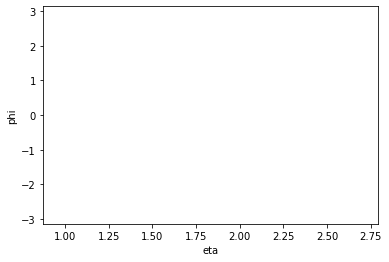

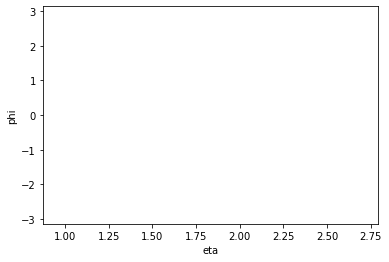

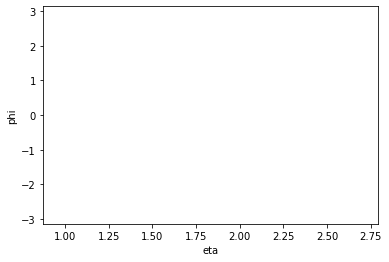

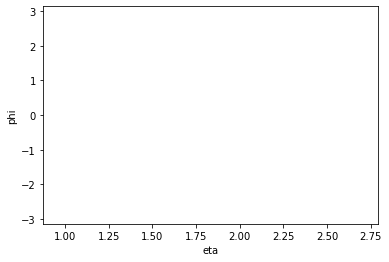

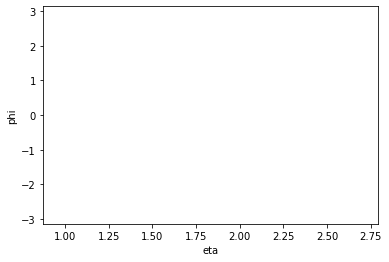

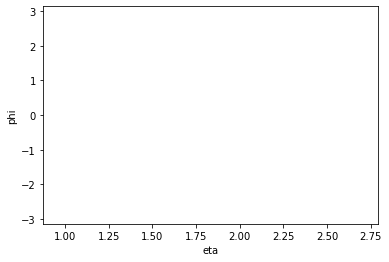

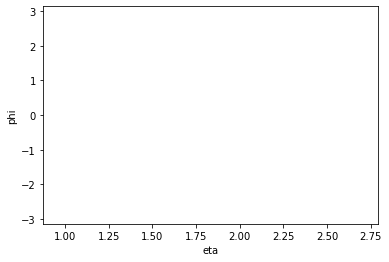

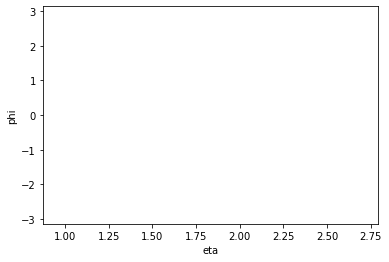

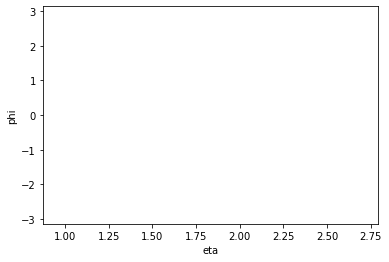

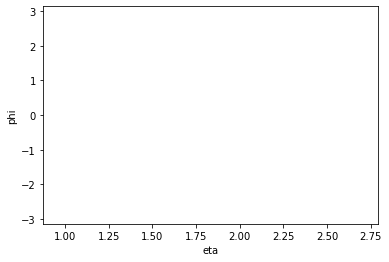

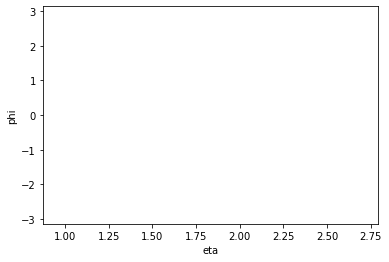

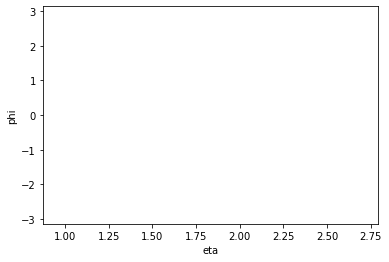

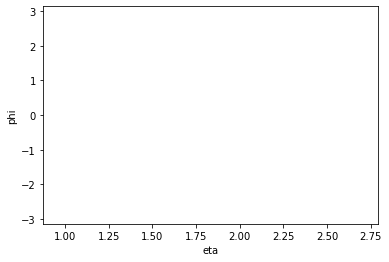

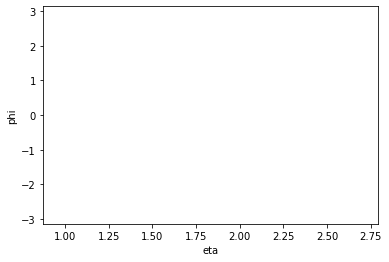

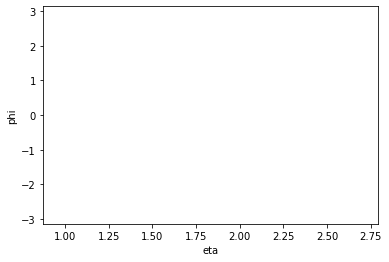

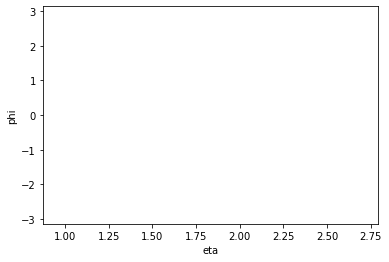

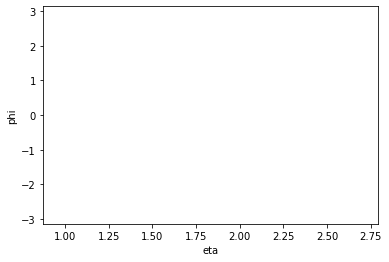

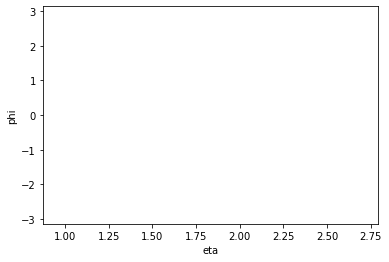

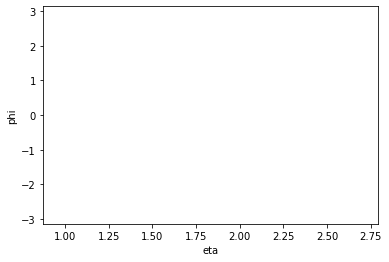

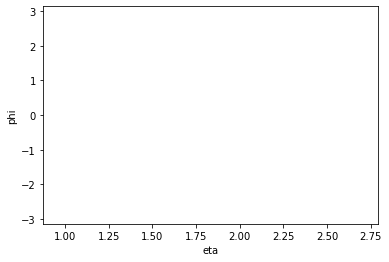

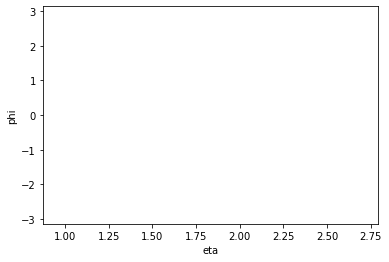

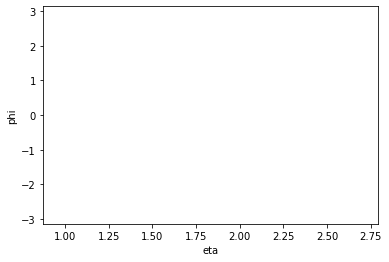

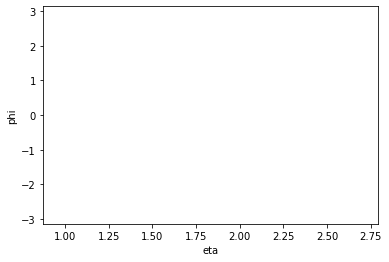

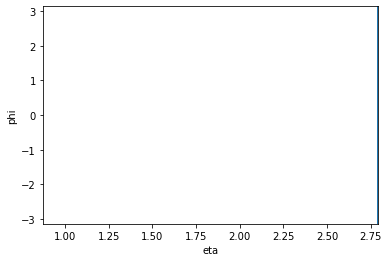

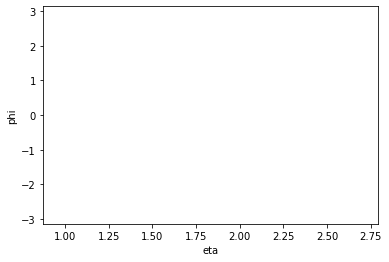

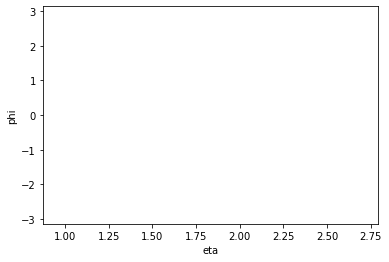

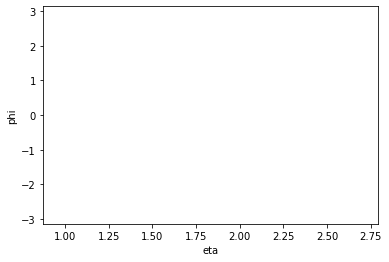

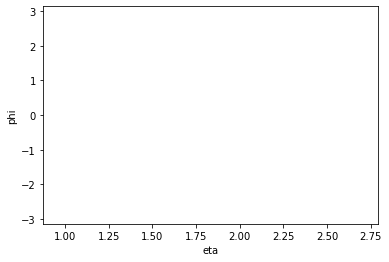

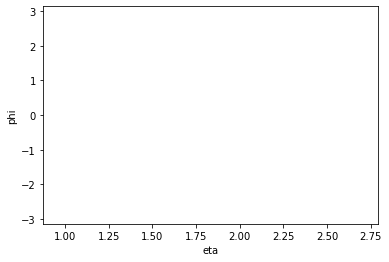

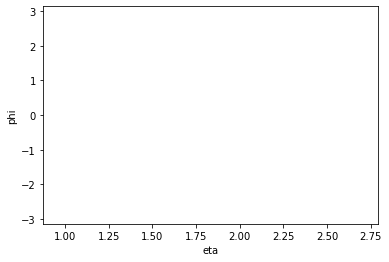

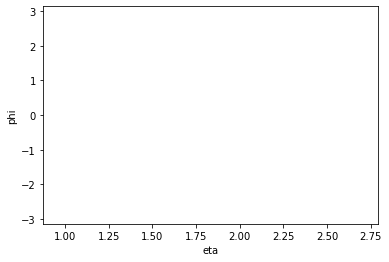

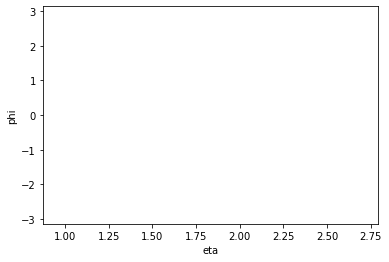

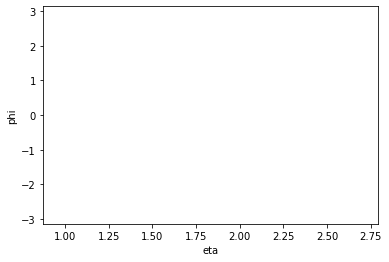

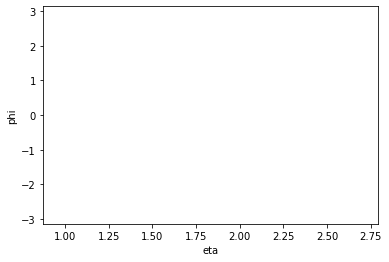

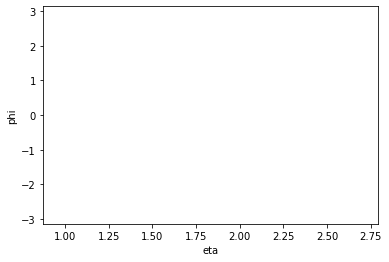

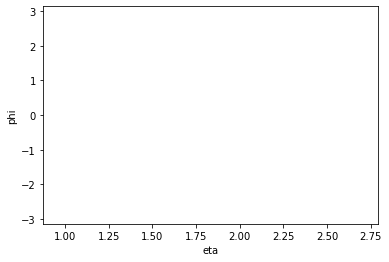

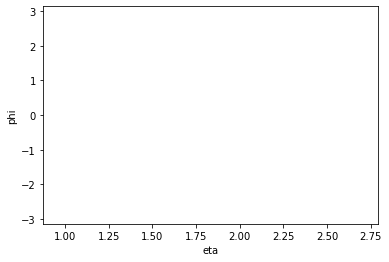

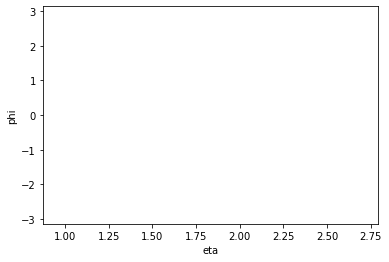

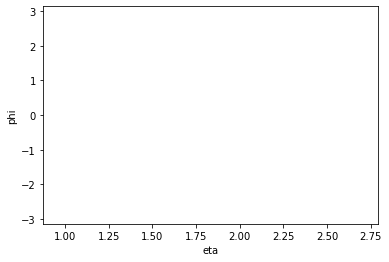

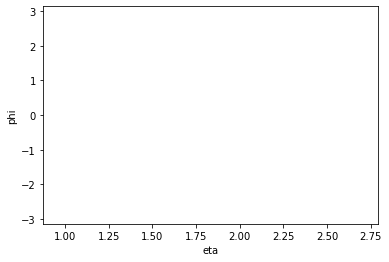

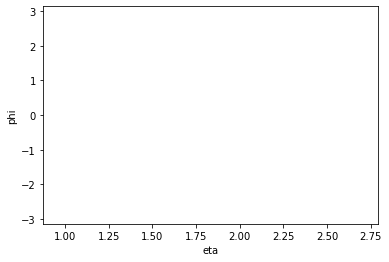

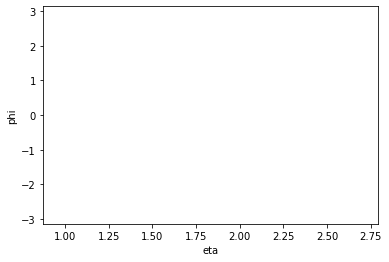

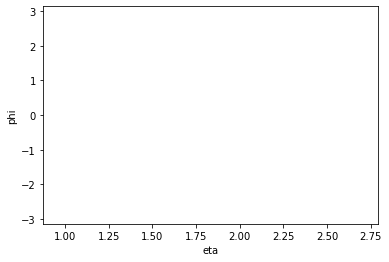

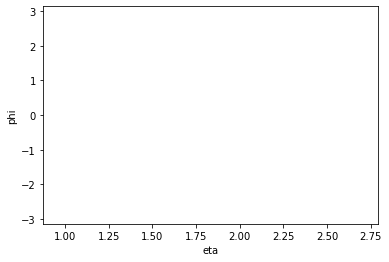

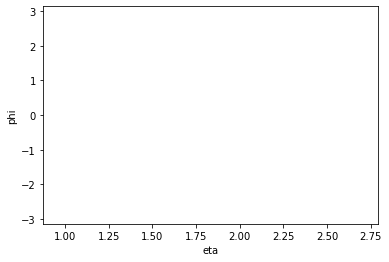

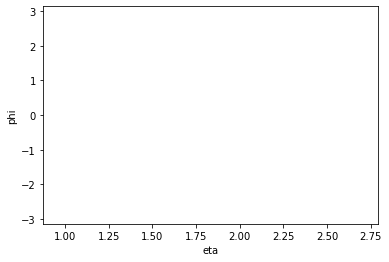

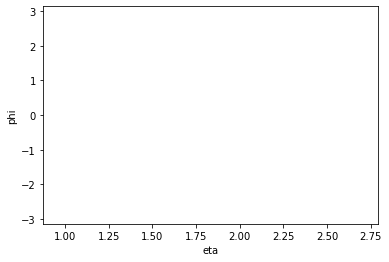

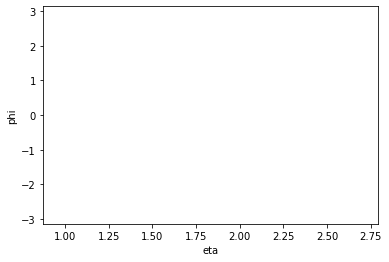

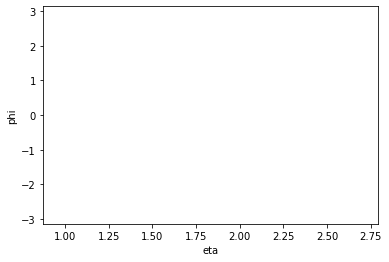

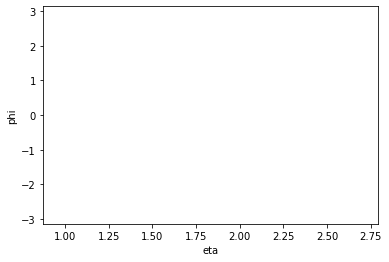

In [59]:
num_bins = {'eta': 1000, 'phi': 1}

eta_bins, size_per_eta_bin = get_bins(all_eta, num_bins['eta'])
phi_bins, size_per_phi_bin = get_bins(all_phi, num_bins['phi'])
feature_names, figs = get_feature_names(eta_bins, phi_bins, num_bins)

In [60]:
pos200['y'] = 1
neg200['y'] = 0

pos_x, pos_y = get_x_from_one_endcap(pos200, eta_bins, phi_bins, num_bins)
neg_x, neg_y = get_x_from_one_endcap(neg200.loc[neg_idx], eta_bins, phi_bins, num_bins)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233649/233649 [34:00<00:00, 114.49it/s]


In [61]:
x = np.concatenate((pos_x, neg_x))
y = np.concatenate((pos_y, neg_y))

In [62]:
idx = np.arange(x.shape[0])
np.random.shuffle(idx)

In [63]:
x = x[idx]
y = y[idx]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

In [72]:
# clf = tree.DecisionTreeClassifier(max_depth=50, criterion='entropy',
#                                   min_samples_leaf=10,
#                                   min_samples_split=5)

# clf = tree.DecisionTreeClassifier()
param_dist = {'objective':'binary:logistic', 'n_estimators':1000, 'n_jobs':6}
clf = xgb.XGBModel(**param_dist)

In [73]:
clf = clf.fit(X_train, y_train.reshape(-1))

[20:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [74]:
pred_y_test = clf.predict(X_test)
pred_y_train = clf.predict(X_train)

In [75]:
print('auroc:', roc_auc_score(y_train, pred_y_train))
print('acc:',(y_train == (pred_y_train > 0.5) ).sum() / len(y_train))
# disp = plot_confusion_matrix(clf, X_train, y_train, cmap=plt.cm.Blues)

auroc: 0.9237417163955823
acc: 0.9141155214791445


In [76]:
print('auroc:', roc_auc_score(y_test, pred_y_test))
print('acc:',(y_test == (pred_y_test > 0.5)).sum() / len(y_test))
# disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)

auroc: 0.8802291043231547
acc: 0.8767387117483415


In [77]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_test)

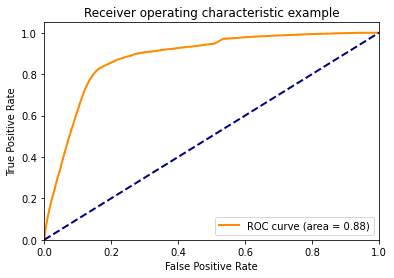

In [80]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, pred_y_test))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 0.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [22]:
fig = plt.figure(figsize=(200, 100))
tree.plot_tree(clf, filled=True, max_depth=6, impurity=False, proportion=False, precision=4,
               class_names=['Bkg', 'Signal'],
               feature_names=feature_names)
fig.savefig("decistion_tree.png")

In [23]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_indicator = clf.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = clf.apply(X_test)
yyy = clf.predict(X_test)



# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

# HERE IS WHAT YOU WANT
sample_id = 100
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:

    if leave_id[sample_id] == node_id:  # <-- changed != to ==
        #continue # <-- comment out
        print("leaf node {} reached, no decision here".format(leave_id[sample_id])) # <--

    else: # < -- added else to iterate through decision nodes
        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("decision id node %s : (X[%s, %s] (= %s) %s %s)"
              % (node_id,
                 sample_id,
                 feature[node_id],
                 X_test[sample_id, feature[node_id]], # <-- changed i to sample_id
                 threshold_sign,
                 threshold[node_id]))
print('pred_y', yyy[sample_id])
print('true_y', y_test[sample_id].item())

Rules used to predict sample 100: 
decision id node 0 : (X[100, 86] (= 0.0) <= 0.5)
decision id node 1 : (X[100, 657] (= 0.0) <= 0.5)
decision id node 2 : (X[100, 22] (= 0.0) <= 0.5)
decision id node 3 : (X[100, 142] (= 0.0) <= 0.5)
decision id node 4 : (X[100, 231] (= 0.0) <= 0.5)
decision id node 5 : (X[100, 747] (= 0.0) <= 0.5)
decision id node 6 : (X[100, 938] (= 0.0) <= 0.5)
decision id node 7 : (X[100, 54] (= 0.0) <= 0.5)
decision id node 8 : (X[100, 55] (= 0.0) <= 0.5)
decision id node 9 : (X[100, 316] (= 0.0) <= 0.5)
decision id node 10 : (X[100, 152] (= 0.0) <= 0.5)
decision id node 11 : (X[100, 813] (= 0.0) <= 0.5)
decision id node 12 : (X[100, 506] (= 0.0) <= 0.5)
decision id node 13 : (X[100, 541] (= 0.0) <= 0.5)
decision id node 14 : (X[100, 434] (= 0.0) <= 0.5)
decision id node 15 : (X[100, 261] (= 0.0) <= 1.5)
decision id node 16 : (X[100, 132] (= 1.0) > 0.5)
decision id node 100540 : (X[100, 256] (= 0.0) <= 0.5)
decision id node 100541 : (X[100, 832] (= 0.0) <= 0.5)
dec

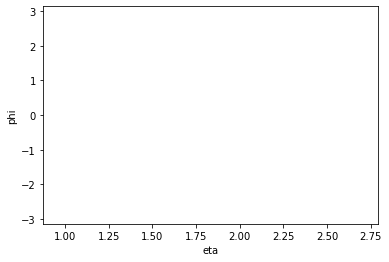

In [24]:
figs[2]

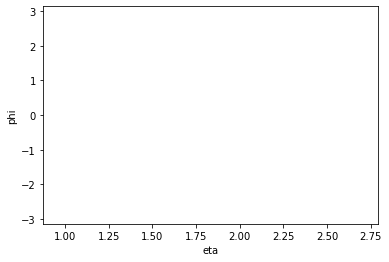

In [25]:
figs[16]

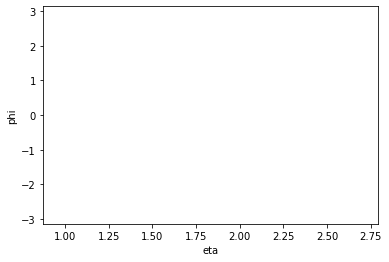

In [26]:
figs[18]